# Quickstart Example of Advanced Off-Policy Evaluation and Selection (continuous)
This notebook provides an example of conducting advanced **Off-policy Evaluation (OPE) and Off-Policy Selection OPS)** with a synthetic simulation dataset.

This example consists of the following 3 steps: 
1. Setup, Synthetic Data Generation, and Offline Policy Learning
2. Various Off-Policy Evaluation (Policy Value Estimate, Cumulative Distribution Function Estimate)
3. Off-Policy Selection

\* This library uses [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementations of offline rl policies and model-based evaluation.  
\* Also, our implementations of OPE are highly inspired by [Open Bandit Pipeline](https://github.com/st-tech/zr-obp).

In [1]:
# delete later
%load_ext autoreload
%autoreload 2

In [2]:
# delete later
import warnings
warnings.simplefilter('ignore')

In [3]:
# delete later
import sys
sys.path.append('../')
sys.path.append('../../')

In [4]:
# import OFRL modules
import ofrl
from syntheticgym import SyntheticEnv
from ofrl.dataset import SyntheticDataset
from ofrl.policy import OnlineHead, ContinuousEvalHead
from ofrl.policy import ContinuousTruncatedGaussianHead as TruncatedGaussianHead
from ofrl.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)
from ofrl.utils import MinMaxScaler, MinMaxActionScaler

# import d3rlpy algorithms
from d3rlpy.algos import RandomPolicy
# from d3rlpy.preprocessing import MinMaxScaler, MinMaxActionScaler
from ofrl.utils import MinMaxScaler, MinMaxActionScaler

# import from other libraries
import gym
import torch
from sklearn.model_selection import train_test_split

In [5]:
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [6]:
# version
print(ofrl.__version__)

0.0.0


In [7]:
# set random state
random_state = 12345

In [8]:
# log directory
from pathlib import Path
Path("logs/").mkdir(exist_ok=True)

## 1. Setup, Synthetic Data Generation, and Offline Policy Learning
To begin with, we briefly describe how the Synthetic environment works.

#### RL setup for Synthetic
In Synthetic, the objective of the RL agent is to maximize some KPIs (number of clicks or conversions) within an episode under given budget constraints.  

We often try to achieve this by adjusting bidding price function parameter $\alpha$. By using $\alpha$, we can adjust the bid price as follows.  
$bid_{t,i} = \alpha \cdot r^{\ast}$, 
where $r^{\ast}$ denotes a predicted or expected reward (KPIs).

We often formulate this Synthetic problem as the following Constrained Markov Decision Process (CMDP):
- `state`: 
- `action`: 
- `reward`: 

<!-- For more about the environmental configuration and its customization, please refer to [examples/quickstart/synthetic_synthetic_customize_env.ipynb](https://github.com/negocia-inc/synthetic_reinforcement_learing/blob/ope/examples/quickstart/synthetic_synthetic_customize_env.ipynb). -->

In [9]:
# standardized environment for continuous action
# env = gym.make("SyntheticEnv-continuous-v0")
env = SyntheticEnv(action_type='continuous', random_state=random_state)

In [10]:
# for api compatibility to d3rlpy
from ofrl.utils import OldGymAPIWrapper
env_ = OldGymAPIWrapper(env)

#### Synthetic Data Generation
Next, we collect logged data with a behavior policy $\pi_0$:

$$\mathcal{D}_0 := \{ \{ s_t, a_t, s_{t+1}, r_t \}_{t=1}^T \}_{i=1}^n \sim \prod_{i=1}^n d_{s_0}(s_0) \prod_{t=1}^T \pi_0(a_t | s_t) p(s_{t+1} | s_t, a_t) p(r_t | s_t, a_t),$$

where $s_t \in \mathcal{S}$ is the state observed at timestep $t$, $a_t$ is the action chosen by the behavior policy $\pi_0$, and $r_t$ is the reward. 

`SyntheticDataset` has the following arguments:
- `env`: Synthetic environment for RL defined in the previous section.
- `state_keys`: Name of the state variable at each dimension.
- `max_episode_steps`: Maximum number of timesteps in an episode.
- `info_keys`: Dictionary containing of key and the type of info components.

For more about the data collection and visualization, please refer to [examples/quickstart/synthetic_synthetic_data_collection.ipynb](https://github.com/negocia-inc/synthetic_reinforcement_learing/blob/ope/examples/quickstart/synthetic_synthetic_data_collection.ipynb).

In [11]:
# behavior policy
from d3rlpy.algos import SAC
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.online.buffers import ReplayBuffer

# model
sac = SAC(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        # minimum=0.1,   # 0.1
        # maximum=10,  # 10
        minimum=env_.action_space.low,   # 0.1
        maximum=env_.action_space.high,  # 10
    ),
)
# setup replay buffer
buffer = ReplayBuffer(
    maxlen=10000,
    env=env_,
)

In [12]:
# start training
# skip if there is a pre-trained model
sac.fit_online(
    env_,
    buffer,
    eval_env=env_,
    n_steps=10000,
    n_steps_per_epoch=100,
    update_start_step=100,
    # n_steps=100000,
    # n_steps_per_epoch=1000,
    # update_start_step=1000,
)

2023-03-13 11:07.50 [info     ] Directory is created at d3rlpy_logs/SAC_online_20230313110750
2023-03-13 11:07.50 [debug    ] Fitting action scaler...       action_scler=min_max
2023-03-13 11:07.50 [debug    ] Building model...
2023-03-13 11:07.50 [debug    ] Model has been built.
2023-03-13 11:07.50 [info     ] Parameters are saved to d3rlpy_logs/SAC_online_20230313110750/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0003, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'batch_size': 256, 'critic_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_r

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 11:07.50 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20230313110750/model_100.pt
2023-03-13 11:07.50 [info     ] SAC_online_20230313110750: epoch=1 step=100 epoch=1 metrics={'time_inference': 0.0006252527236938477, 'time_environment_step': 2.8994083404541015e-05, 'time_step': 0.0006695055961608887, 'rollout_return': 24.21812134009739, 'evaluation': 24.774093440303286} step=100
2023-03-13 11:07.50 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20230313110750/model_200.pt
2023-03-13 11:07.50 [info     ] SAC_online_20230313110750: epoch=2 step=200 epoch=2 metrics={'time_inference': 0.000282282829284668, 'time_environment_step': 2.4192333221435547e-05, 'time_step': 0.0003185272216796875, 'rollout_return': 24.714962913407607, 'evaluation': 24.970081652347424} step=200
2023-03-13 11:07.50 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20230313110750/model_300.pt
2023-03-13 11:07.50 [info     ] SAC_online_20230313110750: epoc

In [13]:
# save model
sac.save_model("d3rlpy_logs/synthetic_sac.pt")

In [14]:
# reload model
sac.build_with_env(env_)
sac.load_model("d3rlpy_logs/synthetic_sac.pt")

2023-03-13 11:08.24 [warning  ] Parameters will be reinitialized.


In [15]:
behavior_policy_05 = TruncatedGaussianHead(
    sac, 
    minimum=env.action_space.low,
    maximum=env.action_space.high,
    sigma=np.array([0.5]),
    name="sac_sigma_0.5",
    random_state=random_state,
)
behavior_policy_10 = TruncatedGaussianHead(
    sac, 
    minimum=env.action_space.low,
    maximum=env.action_space.high,
    sigma=np.array([1.0]),
    name="sac_sigma_1.0",
    random_state=random_state,
)
behavior_policy_20 = TruncatedGaussianHead(
    sac, 
    minimum=env.action_space.low,
    maximum=env.action_space.high,
    sigma=np.array([2.0]),
    name="sac_sigma_2.0",
    random_state=random_state,
)
behavior_policies = [behavior_policy_05, behavior_policy_10, behavior_policy_20]

In [16]:
# initialize dataset class
dataset = SyntheticDataset(
    env=env,
    max_episode_steps=env.step_per_episode,
)

In [17]:
# collect logged data by a behavior policy
# skip if there is a preserved logged dataset
train_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policies, 
    # n_datasets=5, 
    n_datasets=2, 
    n_trajectories=10000, 
    obtain_info=False,
    path="synthetic/logged_dataset/",
    random_state=random_state,
)
test_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policies, 
    # n_datasets=5, 
    n_datasets=2, 
    n_trajectories=10000, 
    obtain_info=False,
    path="synthetic/logged_dataset/",
    random_state=random_state + 1,
)

[obtain_datasets: behavior_policy]:   0%|          | 0/3 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: behavior_policy]:   0%|          | 0/3 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

In [18]:
with open("logs/train_dataset_continuous_synthetic_sac_5.pkl", "wb") as f:
    pickle.dump(train_logged_dataset, f)
with open("logs/test_dataset_continuous_synthetic_sac_5.pkl", "wb") as f:
    pickle.dump(test_logged_dataset, f)

In [19]:
with open("logs/train_dataset_continuous_synthetic_sac_5.pkl", "rb") as f:
    train_logged_dataset = pickle.load(f)
with open("logs/test_dataset_continuous_synthetic_sac_5.pkl", "rb") as f:
    test_logged_dataset = pickle.load(f)

#### Offline Policy Learning
Here, we learn several "candidate" policies to be evaluated and selected using [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementation.

For more about the offline RL procedure, please refer to [examples/quickstart/synthetic_synthetic_continuous_basic.ipynb](https://github.com/negocia-inc/synthetic_reinforcement_learing/blob/ope/examples/quickstart/synthetic_synthetic_continuous_basic.ipynb).

In [20]:
# import modules
from ofrl.policy.opl import OffPolicyLearning
# import models from d3rlpy
from d3rlpy.algos import CQL, IQL

In [21]:
# evaluation policies
cql_b1 = CQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)
cql_b2 = CQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)
cql_b3 = CQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)
iql_b1 = IQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)
iql_b2 = IQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)
iql_b3 = IQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)

algorithms = [cql_b1, cql_b2, cql_b3, iql_b1, iql_b2, iql_b3]
algorithms_name = ["cql_b1", "cql_b2", "cql_b3", "iql_b1", "iql_b2", "iql_b3"]

In [22]:
# initialize OPL class
opl = OffPolicyLearning(
    fitting_args={
        "n_steps": 10000,
        "scorers": {},
    }
)

In [23]:
# obtain base policies
base_policies = opl.learn_base_policy(
    logged_dataset=train_logged_dataset,
    algorithms=algorithms,
    random_state=random_state,
)

[learn_policies: algorithms]:   0%|          | 0/6 [00:00<?, ?it/s]

2023-03-13 11:20.44 [debug    ] RandomIterator is selected.
2023-03-13 11:20.44 [info     ] Directory is created at d3rlpy_logs/CQL_20230313112044
2023-03-13 11:20.44 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 11:20.44 [debug    ] Building models...
2023-03-13 11:20.44 [debug    ] Models have been built.
2023-03-13 11:20.44 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230313112044/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 11:23.04 [info     ] CQL_20230313112044: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005305280447006226, 'time_algorithm_update': 0.012961829566955567, 'temp_loss': 0.1961685858335346, 'temp': 1.0685222113788129, 'alpha_loss': 3.1366315221805126, 'alpha': 0.7280592940747738, 'critic_loss': 424.4541352871418, 'actor_loss': -45.06558874405623, 'time_step': 0.013876969027519226} step=10000
2023-03-13 11:23.04 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230313112044/model_10000.pt
2023-03-13 11:23.04 [debug    ] RandomIterator is selected.
2023-03-13 11:23.04 [info     ] Directory is created at d3rlpy_logs/CQL_20230313112304
2023-03-13 11:23.04 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 11:23.04 [debug    ] Building models...
2023-03-13 11:23.04 [debug    ] Models have been built.
2023-03-13 11:23.04 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230313112304/params.json params={'action_scaler': {'type': 'mi

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 11:25.23 [info     ] CQL_20230313112304: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005441752910614014, 'time_algorithm_update': 0.012923722338676452, 'temp_loss': 0.3296635812347988, 'temp': 0.981516504240036, 'alpha_loss': 1.4393223772255703, 'alpha': 0.7795912099927664, 'critic_loss': 504.9538380689621, 'actor_loss': -48.76353540678024, 'time_step': 0.013866536092758178} step=10000
2023-03-13 11:25.23 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230313112304/model_10000.pt
2023-03-13 11:25.23 [debug    ] RandomIterator is selected.
2023-03-13 11:25.23 [info     ] Directory is created at d3rlpy_logs/CQL_20230313112523
2023-03-13 11:25.23 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 11:25.23 [debug    ] Building models...
2023-03-13 11:25.23 [debug    ] Models have been built.
2023-03-13 11:25.23 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230313112523/params.json params={'action_scaler': {'type': 'min

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 11:27.35 [info     ] CQL_20230313112523: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005376198291778564, 'time_algorithm_update': 0.012194255661964417, 'temp_loss': 0.280630239111511, 'temp': 1.0292658360660076, 'alpha_loss': 3.218329240862746, 'alpha': 0.7392561991423369, 'critic_loss': 394.7096709291101, 'actor_loss': -43.181022253358364, 'time_step': 0.013120015096664429} step=10000
2023-03-13 11:27.35 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230313112523/model_10000.pt
2023-03-13 11:27.35 [debug    ] RandomIterator is selected.
2023-03-13 11:27.35 [info     ] Directory is created at d3rlpy_logs/IQL_20230313112735
2023-03-13 11:27.35 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 11:27.35 [debug    ] Building models...
2023-03-13 11:27.35 [debug    ] Models have been built.
2023-03-13 11:27.35 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230313112735/params.json params={'action_scaler': {'type': 'min

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 11:28.14 [info     ] IQL_20230313112735: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005021968364715576, 'time_algorithm_update': 0.0031165977001190183, 'critic_loss': 269.243527264452, 'value_loss': 0.4679211535933001, 'actor_loss': -27.10191781436559, 'time_step': 0.0038464891910552977} step=10000
2023-03-13 11:28.14 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230313112735/model_10000.pt
2023-03-13 11:28.14 [debug    ] RandomIterator is selected.
2023-03-13 11:28.14 [info     ] Directory is created at d3rlpy_logs/IQL_20230313112814
2023-03-13 11:28.14 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 11:28.14 [debug    ] Building models...
2023-03-13 11:28.14 [debug    ] Models have been built.
2023-03-13 11:28.14 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230313112814/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 11:28.50 [info     ] IQL_20230313112814: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000500053334236145, 'time_algorithm_update': 0.0028512768030166625, 'critic_loss': 292.07637273602484, 'value_loss': 0.608317862722864, 'actor_loss': -35.82868786054533, 'time_step': 0.003580654788017273} step=10000
2023-03-13 11:28.50 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230313112814/model_10000.pt
2023-03-13 11:28.50 [debug    ] RandomIterator is selected.
2023-03-13 11:28.50 [info     ] Directory is created at d3rlpy_logs/IQL_20230313112850
2023-03-13 11:28.50 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 11:28.50 [debug    ] Building models...
2023-03-13 11:28.50 [debug    ] Models have been built.
2023-03-13 11:28.50 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230313112850/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 11:29.29 [info     ] IQL_20230313112850: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005053080320358277, 'time_algorithm_update': 0.0031650627136230467, 'critic_loss': 267.9334398240328, 'value_loss': 0.49534070285014314, 'actor_loss': -28.336644687453283, 'time_step': 0.0039050753831863403} step=10000
2023-03-13 11:29.29 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230313112850/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/6 [00:00<?, ?it/s]

2023-03-13 11:29.29 [debug    ] RandomIterator is selected.
2023-03-13 11:29.29 [info     ] Directory is created at d3rlpy_logs/CQL_20230313112929
2023-03-13 11:29.29 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 11:29.29 [warning  ] Skip building models since they're already built.
2023-03-13 11:29.29 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230313112929/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 11:31.47 [info     ] CQL_20230313112929: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000529921555519104, 'time_algorithm_update': 0.012805866742134095, 'temp_loss': -0.01721345458459109, 'temp': 1.3807541675448418, 'alpha_loss': 0.8763088507443266, 'alpha': 0.32414552530646323, 'critic_loss': 661.7197436920166, 'actor_loss': -59.74915916404724, 'time_step': 0.0137306467294693} step=10000
2023-03-13 11:31.47 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230313112929/model_10000.pt
2023-03-13 11:31.47 [debug    ] RandomIterator is selected.
2023-03-13 11:31.47 [info     ] Directory is created at d3rlpy_logs/CQL_20230313113147
2023-03-13 11:31.47 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 11:31.47 [warning  ] Skip building models since they're already built.
2023-03-13 11:31.47 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230313113147/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minim

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 11:34.04 [info     ] CQL_20230313113147: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005431746959686279, 'time_algorithm_update': 0.012662603712081909, 'temp_loss': 0.010737626772886142, 'temp': 0.982211430633068, 'alpha_loss': 1.341005186754465, 'alpha': 0.3173136114373803, 'critic_loss': 566.5886769775391, 'actor_loss': -55.86552799263001, 'time_step': 0.01361080560684204} step=10000
2023-03-13 11:34.04 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230313113147/model_10000.pt
2023-03-13 11:34.04 [debug    ] RandomIterator is selected.
2023-03-13 11:34.04 [info     ] Directory is created at d3rlpy_logs/CQL_20230313113404
2023-03-13 11:34.04 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 11:34.04 [warning  ] Skip building models since they're already built.
2023-03-13 11:34.04 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230313113404/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimu

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 11:36.10 [info     ] CQL_20230313113404: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005281200408935547, 'time_algorithm_update': 0.0115971586227417, 'temp_loss': -0.002305677088489756, 'temp': 1.2122020010113717, 'alpha_loss': 1.5191871775947512, 'alpha': 0.30582577705979347, 'critic_loss': 532.49730491333, 'actor_loss': -53.74583414955139, 'time_step': 0.012517908120155335} step=10000
2023-03-13 11:36.10 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230313113404/model_10000.pt
2023-03-13 11:36.10 [debug    ] RandomIterator is selected.
2023-03-13 11:36.10 [info     ] Directory is created at d3rlpy_logs/IQL_20230313113610
2023-03-13 11:36.10 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 11:36.10 [warning  ] Skip building models since they're already built.
2023-03-13 11:36.10 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230313113610/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minim

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 11:36.47 [info     ] IQL_20230313113610: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0004896469116210938, 'time_algorithm_update': 0.002950336527824402, 'critic_loss': 327.9928084793091, 'value_loss': 0.6089419497907161, 'actor_loss': -35.55018717565537, 'time_step': 0.0036544658184051513} step=10000
2023-03-13 11:36.47 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230313113610/model_10000.pt
2023-03-13 11:36.47 [debug    ] RandomIterator is selected.
2023-03-13 11:36.47 [info     ] Directory is created at d3rlpy_logs/IQL_20230313113647
2023-03-13 11:36.47 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 11:36.47 [warning  ] Skip building models since they're already built.
2023-03-13 11:36.47 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230313113647/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_facto

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 11:37.22 [info     ] IQL_20230313113647: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0004956765174865723, 'time_algorithm_update': 0.00281217999458313, 'critic_loss': 363.9755196411133, 'value_loss': 0.6881720678925515, 'actor_loss': -42.08066147661209, 'time_step': 0.0035230018377304076} step=10000
2023-03-13 11:37.22 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230313113647/model_10000.pt
2023-03-13 11:37.22 [debug    ] RandomIterator is selected.
2023-03-13 11:37.22 [info     ] Directory is created at d3rlpy_logs/IQL_20230313113722
2023-03-13 11:37.22 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 11:37.22 [warning  ] Skip building models since they're already built.
2023-03-13 11:37.22 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230313113722/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_factor

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 11:38.01 [info     ] IQL_20230313113722: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0004980108976364136, 'time_algorithm_update': 0.0031015666723251344, 'critic_loss': 342.4428031097412, 'value_loss': 0.5760276044517756, 'actor_loss': -34.955671152496336, 'time_step': 0.003822147488594055} step=10000
2023-03-13 11:38.01 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230313113722/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/6 [00:00<?, ?it/s]

2023-03-13 11:38.01 [debug    ] RandomIterator is selected.
2023-03-13 11:38.01 [info     ] Directory is created at d3rlpy_logs/CQL_20230313113801
2023-03-13 11:38.01 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 11:38.01 [warning  ] Skip building models since they're already built.
2023-03-13 11:38.01 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230313113801/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 11:40.18 [info     ] CQL_20230313113801: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005298110246658326, 'time_algorithm_update': 0.012718931555747985, 'temp_loss': 0.520102743436303, 'temp': 0.8871078010499477, 'alpha_loss': -1.8114339858405482, 'alpha': 0.47512889803647995, 'critic_loss': 673.6854819213867, 'actor_loss': -61.334899823379516, 'time_step': 0.013648381757736206} step=10000
2023-03-13 11:40.18 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230313113801/model_10000.pt
2023-03-13 11:40.18 [debug    ] RandomIterator is selected.
2023-03-13 11:40.18 [info     ] Directory is created at d3rlpy_logs/CQL_20230313114018
2023-03-13 11:40.18 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 11:40.18 [warning  ] Skip building models since they're already built.
2023-03-13 11:40.18 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230313114018/params.json params={'action_scaler': {'type': 'min_max', 'params': {'min

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 11:42.32 [info     ] CQL_20230313114018: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000542178726196289, 'time_algorithm_update': 0.012335611534118652, 'temp_loss': 0.09443777142269537, 'temp': 0.7014598937183618, 'alpha_loss': -1.2357564005053137, 'alpha': 0.3480033069759607, 'critic_loss': 691.1850089141846, 'actor_loss': -62.77702728271484, 'time_step': 0.013296794867515564} step=10000
2023-03-13 11:42.32 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230313114018/model_10000.pt
2023-03-13 11:42.32 [debug    ] RandomIterator is selected.
2023-03-13 11:42.32 [info     ] Directory is created at d3rlpy_logs/CQL_20230313114232
2023-03-13 11:42.32 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 11:42.32 [warning  ] Skip building models since they're already built.
2023-03-13 11:42.32 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230313114232/params.json params={'action_scaler': {'type': 'min_max', 'params': {'mini

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 11:44.40 [info     ] CQL_20230313114232: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005344855785369873, 'time_algorithm_update': 0.011829644775390625, 'temp_loss': 0.2880463726460934, 'temp': 0.7642539901673794, 'alpha_loss': -0.9277403724670625, 'alpha': 0.32073997895866635, 'critic_loss': 609.8402409729003, 'actor_loss': -58.80171156768799, 'time_step': 0.012768520498275758} step=10000
2023-03-13 11:44.40 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230313114232/model_10000.pt
2023-03-13 11:44.40 [debug    ] RandomIterator is selected.
2023-03-13 11:44.40 [info     ] Directory is created at d3rlpy_logs/IQL_20230313114440
2023-03-13 11:44.40 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 11:44.40 [warning  ] Skip building models since they're already built.
2023-03-13 11:44.40 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230313114440/params.json params={'action_scaler': {'type': 'min_max', 'params': {'min

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 11:45.20 [info     ] IQL_20230313114440: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005043585777282715, 'time_algorithm_update': 0.003181364321708679, 'critic_loss': 324.3949848388672, 'value_loss': 0.818085789629817, 'actor_loss': -20.535508001822233, 'time_step': 0.0039208816289901735} step=10000
2023-03-13 11:45.20 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230313114440/model_10000.pt
2023-03-13 11:45.20 [debug    ] RandomIterator is selected.
2023-03-13 11:45.20 [info     ] Directory is created at d3rlpy_logs/IQL_20230313114520
2023-03-13 11:45.20 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 11:45.20 [warning  ] Skip building models since they're already built.
2023-03-13 11:45.20 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230313114520/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_facto

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 11:45.57 [info     ] IQL_20230313114520: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000507721757888794, 'time_algorithm_update': 0.002969007420539856, 'critic_loss': 349.6597255584717, 'value_loss': 1.0149737879782914, 'actor_loss': -26.922463376796244, 'time_step': 0.003716442346572876} step=10000
2023-03-13 11:45.57 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230313114520/model_10000.pt
2023-03-13 11:45.57 [debug    ] RandomIterator is selected.
2023-03-13 11:45.57 [info     ] Directory is created at d3rlpy_logs/IQL_20230313114557
2023-03-13 11:45.57 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 11:45.57 [warning  ] Skip building models since they're already built.
2023-03-13 11:45.57 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230313114557/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_factor

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 11:46.35 [info     ] IQL_20230313114557: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0004998390674591064, 'time_algorithm_update': 0.0030451724290847778, 'critic_loss': 332.6569068939209, 'value_loss': 0.7770751760929823, 'actor_loss': -21.5328322335124, 'time_step': 0.0037696068286895753} step=10000
2023-03-13 11:46.35 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230313114557/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/6 [00:00<?, ?it/s]

2023-03-13 11:46.36 [debug    ] RandomIterator is selected.
2023-03-13 11:46.36 [info     ] Directory is created at d3rlpy_logs/CQL_20230313114636
2023-03-13 11:46.36 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 11:46.36 [warning  ] Skip building models since they're already built.
2023-03-13 11:46.36 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230313114636/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 11:48.56 [info     ] CQL_20230313114636: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005282798767089844, 'time_algorithm_update': 0.013020457434654235, 'temp_loss': 0.02634530708133243, 'temp': 0.4958562621951103, 'alpha_loss': 0.21472232456588863, 'alpha': 0.4346550371348858, 'critic_loss': 457.234716015625, 'actor_loss': -52.064522943496705, 'time_step': 0.013947282075881959} step=10000
2023-03-13 11:48.56 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230313114636/model_10000.pt
2023-03-13 11:48.56 [debug    ] RandomIterator is selected.
2023-03-13 11:48.56 [info     ] Directory is created at d3rlpy_logs/CQL_20230313114856
2023-03-13 11:48.56 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 11:48.56 [warning  ] Skip building models since they're already built.
2023-03-13 11:48.56 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230313114856/params.json params={'action_scaler': {'type': 'min_max', 'params': {'min

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 11:51.22 [info     ] CQL_20230313114856: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005532592535018921, 'time_algorithm_update': 0.013554333233833314, 'temp_loss': 0.011865367619786411, 'temp': 0.43281484811306, 'alpha_loss': 0.10678062252145978, 'alpha': 0.46133952040076254, 'critic_loss': 489.6057255264282, 'actor_loss': -53.62648268966675, 'time_step': 0.014530579090118408} step=10000
2023-03-13 11:51.22 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230313114856/model_10000.pt
2023-03-13 11:51.22 [debug    ] RandomIterator is selected.
2023-03-13 11:51.22 [info     ] Directory is created at d3rlpy_logs/CQL_20230313115122
2023-03-13 11:51.22 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 11:51.22 [warning  ] Skip building models since they're already built.
2023-03-13 11:51.22 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230313115122/params.json params={'action_scaler': {'type': 'min_max', 'params': {'min

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 11:53.38 [info     ] CQL_20230313115122: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005436427831649781, 'time_algorithm_update': 0.012613492870330811, 'temp_loss': 0.009847080742497929, 'temp': 0.4801014788448811, 'alpha_loss': 0.054838415935225746, 'alpha': 0.3239194879114628, 'critic_loss': 465.43611298980716, 'actor_loss': -52.44027879981994, 'time_step': 0.013574328565597534} step=10000
2023-03-13 11:53.38 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230313115122/model_10000.pt
2023-03-13 11:53.38 [debug    ] RandomIterator is selected.
2023-03-13 11:53.38 [info     ] Directory is created at d3rlpy_logs/IQL_20230313115338
2023-03-13 11:53.38 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 11:53.38 [warning  ] Skip building models since they're already built.
2023-03-13 11:53.38 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230313115338/params.json params={'action_scaler': {'type': 'min_max', 'params': {'

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 11:54.18 [info     ] IQL_20230313115338: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005024806261062622, 'time_algorithm_update': 0.0031815042734146116, 'critic_loss': 316.9488717025757, 'value_loss': 0.5453754485011101, 'actor_loss': -17.197938793098928, 'time_step': 0.00391441798210144} step=10000
2023-03-13 11:54.18 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230313115338/model_10000.pt
2023-03-13 11:54.18 [debug    ] RandomIterator is selected.
2023-03-13 11:54.18 [info     ] Directory is created at d3rlpy_logs/IQL_20230313115418
2023-03-13 11:54.18 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 11:54.18 [warning  ] Skip building models since they're already built.
2023-03-13 11:54.18 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230313115418/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_facto

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 11:54.56 [info     ] IQL_20230313115418: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005060986280441284, 'time_algorithm_update': 0.0030343992710113524, 'critic_loss': 335.75806705322265, 'value_loss': 0.5744778923809528, 'actor_loss': -19.16002420707941, 'time_step': 0.00378623743057251} step=10000
2023-03-13 11:54.56 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230313115418/model_10000.pt
2023-03-13 11:54.56 [debug    ] RandomIterator is selected.
2023-03-13 11:54.56 [info     ] Directory is created at d3rlpy_logs/IQL_20230313115456
2023-03-13 11:54.56 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 11:54.56 [warning  ] Skip building models since they're already built.
2023-03-13 11:54.56 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230313115456/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_facto

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 11:55.37 [info     ] IQL_20230313115456: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005076888084411621, 'time_algorithm_update': 0.0032970995903015138, 'critic_loss': 322.91780613708494, 'value_loss': 0.4978713853955269, 'actor_loss': -17.226897420907022, 'time_step': 0.0040519071578979495} step=10000
2023-03-13 11:55.37 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230313115456/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/6 [00:00<?, ?it/s]

2023-03-13 11:55.37 [debug    ] RandomIterator is selected.
2023-03-13 11:55.37 [info     ] Directory is created at d3rlpy_logs/CQL_20230313115537
2023-03-13 11:55.37 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 11:55.37 [warning  ] Skip building models since they're already built.
2023-03-13 11:55.37 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230313115537/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 11:57.56 [info     ] CQL_20230313115537: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005337339162826538, 'time_algorithm_update': 0.012922769141197204, 'temp_loss': 0.21303253755720797, 'temp': 0.2978896515414119, 'alpha_loss': -4.140735613441468, 'alpha': 0.621503375929594, 'critic_loss': 416.81610455322266, 'actor_loss': -49.09992961502075, 'time_step': 0.013846955037117005} step=10000
2023-03-13 11:57.56 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230313115537/model_10000.pt
2023-03-13 11:57.56 [debug    ] RandomIterator is selected.
2023-03-13 11:57.56 [info     ] Directory is created at d3rlpy_logs/CQL_20230313115756
2023-03-13 11:57.56 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 11:57.56 [warning  ] Skip building models since they're already built.
2023-03-13 11:57.56 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230313115756/params.json params={'action_scaler': {'type': 'min_max', 'params': {'mini

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 12:00.23 [info     ] CQL_20230313115756: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005576949596405029, 'time_algorithm_update': 0.0136793053150177, 'temp_loss': 0.23050987879536114, 'temp': 0.24650192407071592, 'alpha_loss': -4.459610005617142, 'alpha': 0.678475049290061, 'critic_loss': 413.1817179641724, 'actor_loss': -48.97179525413513, 'time_step': 0.014650336408615112} step=10000
2023-03-13 12:00.23 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230313115756/model_10000.pt
2023-03-13 12:00.23 [debug    ] RandomIterator is selected.
2023-03-13 12:00.23 [info     ] Directory is created at d3rlpy_logs/CQL_20230313120023
2023-03-13 12:00.23 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:00.23 [warning  ] Skip building models since they're already built.
2023-03-13 12:00.23 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230313120023/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimu

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 12:02.32 [info     ] CQL_20230313120023: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005273097038269043, 'time_algorithm_update': 0.011894371199607848, 'temp_loss': 0.16686537622984032, 'temp': 0.28642963870763777, 'alpha_loss': -4.0935420035839085, 'alpha': 0.5738750053822994, 'critic_loss': 443.32506446533205, 'actor_loss': -50.58043050956726, 'time_step': 0.012813115167617798} step=10000
2023-03-13 12:02.32 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230313120023/model_10000.pt
2023-03-13 12:02.32 [debug    ] RandomIterator is selected.
2023-03-13 12:02.32 [info     ] Directory is created at d3rlpy_logs/IQL_20230313120232
2023-03-13 12:02.32 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:02.32 [warning  ] Skip building models since they're already built.
2023-03-13 12:02.32 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230313120232/params.json params={'action_scaler': {'type': 'min_max', 'params': {'m

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 12:03.09 [info     ] IQL_20230313120232: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0004883663654327393, 'time_algorithm_update': 0.0029448240756988525, 'critic_loss': 280.4675954299927, 'value_loss': 0.40213985705971717, 'actor_loss': -1.0759362074814738, 'time_step': 0.0036628885984420776} step=10000
2023-03-13 12:03.09 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230313120232/model_10000.pt
2023-03-13 12:03.09 [debug    ] RandomIterator is selected.
2023-03-13 12:03.09 [info     ] Directory is created at d3rlpy_logs/IQL_20230313120309
2023-03-13 12:03.09 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:03.09 [warning  ] Skip building models since they're already built.
2023-03-13 12:03.09 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230313120309/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_fa

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 12:03.43 [info     ] IQL_20230313120309: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00048604962825775144, 'time_algorithm_update': 0.0026435209274291993, 'critic_loss': 293.6415923812866, 'value_loss': 0.40452109399288894, 'actor_loss': -2.3728961768701673, 'time_step': 0.003344051504135132} step=10000
2023-03-13 12:03.43 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230313120309/model_10000.pt
2023-03-13 12:03.43 [debug    ] RandomIterator is selected.
2023-03-13 12:03.43 [info     ] Directory is created at d3rlpy_logs/IQL_20230313120343
2023-03-13 12:03.43 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:03.43 [warning  ] Skip building models since they're already built.
2023-03-13 12:03.43 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230313120343/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_fa

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 12:04.21 [info     ] IQL_20230313120343: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0004989307880401611, 'time_algorithm_update': 0.0030613646507263183, 'critic_loss': 286.5655043075561, 'value_loss': 0.4458078407630324, 'actor_loss': -0.8955728864519857, 'time_step': 0.0038086265802383425} step=10000
2023-03-13 12:04.21 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230313120343/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/6 [00:00<?, ?it/s]

2023-03-13 12:04.21 [debug    ] RandomIterator is selected.
2023-03-13 12:04.21 [info     ] Directory is created at d3rlpy_logs/CQL_20230313120421
2023-03-13 12:04.21 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:04.21 [warning  ] Skip building models since they're already built.
2023-03-13 12:04.21 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230313120421/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 12:06.37 [info     ] CQL_20230313120421: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005186373472213746, 'time_algorithm_update': 0.012606663990020752, 'temp_loss': 0.016886293764563742, 'temp': 0.16143589634746314, 'alpha_loss': -8.829129402256012, 'alpha': 1.8134403907775878, 'critic_loss': 367.6197849975586, 'actor_loss': -46.44365119895935, 'time_step': 0.013505480432510377} step=10000
2023-03-13 12:06.37 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230313120421/model_10000.pt
2023-03-13 12:06.37 [debug    ] RandomIterator is selected.
2023-03-13 12:06.37 [info     ] Directory is created at d3rlpy_logs/CQL_20230313120637
2023-03-13 12:06.37 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:06.37 [warning  ] Skip building models since they're already built.
2023-03-13 12:06.37 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230313120637/params.json params={'action_scaler': {'type': 'min_max', 'params': {'mi

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 12:08.49 [info     ] CQL_20230313120637: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005327948808670044, 'time_algorithm_update': 0.012246451830863953, 'temp_loss': 0.016745254249632125, 'temp': 0.12680752146691085, 'alpha_loss': -9.1366862950325, 'alpha': 1.9740783624887466, 'critic_loss': 375.52259360809325, 'actor_loss': -46.835349060440066, 'time_step': 0.013166418385505677} step=10000
2023-03-13 12:08.49 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230313120637/model_10000.pt
2023-03-13 12:08.49 [debug    ] RandomIterator is selected.
2023-03-13 12:08.49 [info     ] Directory is created at d3rlpy_logs/CQL_20230313120849
2023-03-13 12:08.49 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:08.49 [warning  ] Skip building models since they're already built.
2023-03-13 12:08.49 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230313120849/params.json params={'action_scaler': {'type': 'min_max', 'params': {'mi

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 12:10.50 [info     ] CQL_20230313120849: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0005092137098312377, 'time_algorithm_update': 0.011117431831359863, 'temp_loss': 0.018420699408228394, 'temp': 0.14754244810789824, 'alpha_loss': -8.27551893529892, 'alpha': 1.6672555527746677, 'critic_loss': 380.0534331665039, 'actor_loss': -47.1064119644165, 'time_step': 0.011989133286476135} step=10000
2023-03-13 12:10.50 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230313120849/model_10000.pt
2023-03-13 12:10.50 [debug    ] RandomIterator is selected.
2023-03-13 12:10.50 [info     ] Directory is created at d3rlpy_logs/IQL_20230313121050
2023-03-13 12:10.50 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:10.50 [warning  ] Skip building models since they're already built.
2023-03-13 12:10.50 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230313121050/params.json params={'action_scaler': {'type': 'min_max', 'params': {'mini

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 12:11.25 [info     ] IQL_20230313121050: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00047436447143554686, 'time_algorithm_update': 0.0028947633504867554, 'critic_loss': 266.2701863105774, 'value_loss': 0.2637763715669513, 'actor_loss': -2.685447743943706, 'time_step': 0.0035307176113128663} step=10000
2023-03-13 12:11.25 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230313121050/model_10000.pt
2023-03-13 12:11.25 [debug    ] RandomIterator is selected.
2023-03-13 12:11.25 [info     ] Directory is created at d3rlpy_logs/IQL_20230313121125
2023-03-13 12:11.25 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:11.26 [warning  ] Skip building models since they're already built.
2023-03-13 12:11.26 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230313121125/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_fac

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 12:11.59 [info     ] IQL_20230313121125: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00047482106685638425, 'time_algorithm_update': 0.0027118506908416747, 'critic_loss': 281.2674612640381, 'value_loss': 0.27025261902958153, 'actor_loss': -3.2190482478726654, 'time_step': 0.0033466516733169555} step=10000
2023-03-13 12:11.59 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230313121125/model_10000.pt
2023-03-13 12:11.59 [debug    ] RandomIterator is selected.
2023-03-13 12:11.59 [info     ] Directory is created at d3rlpy_logs/IQL_20230313121159
2023-03-13 12:11.59 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:11.59 [warning  ] Skip building models since they're already built.
2023-03-13 12:11.59 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230313121159/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'actor_encoder_f

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-13 12:12.37 [info     ] IQL_20230313121159: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0004752157926559448, 'time_algorithm_update': 0.003125606632232666, 'critic_loss': 270.9769122650147, 'value_loss': 0.2970332619458437, 'actor_loss': -3.7636305300951003, 'time_step': 0.0037604697465896605} step=10000
2023-03-13 12:12.37 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230313121159/model_10000.pt


In [24]:
with open("d3rlpy_logs/multiple_continuous_synthetic_base_policies.pkl", "wb") as f:
    pickle.dump(base_policies, f)

In [25]:
with open("d3rlpy_logs/multiple_continuous_synthetic_base_policies.pkl", "rb") as f:
    base_policies = pickle.load(f)

In [26]:
# policy wrapper
policy_wrappers = {
    "gauss_05": (
        TruncatedGaussianHead, {
            "sigma": np.array([0.5]),
            "minimum": env.action_space.low,
            "maximum": env.action_space.high,
        }
    ),
    "gauss_10": (
        TruncatedGaussianHead, {
            "sigma": np.array([1.0]),
            "minimum": env.action_space.low,
            "maximum": env.action_space.high,
        }
    ),
}

In [27]:
eval_policies = opl.apply_head(
    base_policies=base_policies,
    base_policies_name=algorithms_name,
    policy_wrappers=policy_wrappers,
    random_state=random_state,
)

In [28]:
[eval_policy.name for eval_policy in eval_policies[behavior_policies[0].name][0]]

['cql_b1_gauss_05',
 'cql_b1_gauss_10',
 'cql_b2_gauss_05',
 'cql_b2_gauss_10',
 'cql_b3_gauss_05',
 'cql_b3_gauss_10',
 'iql_b1_gauss_05',
 'iql_b1_gauss_10',
 'iql_b2_gauss_05',
 'iql_b2_gauss_10',
 'iql_b3_gauss_05',
 'iql_b3_gauss_10']

## 2. Various Off-Policy Evaluation
In this section, we aim at evaluating the various performance statistics of policies in an offline manner.

### Preparation: Create OPE Input

First, we obtain input dictionary using the CreateOPEInput class.

In [29]:
# import ope modules from OFRL
from ofrl.ope import CreateOPEInput

In [30]:
# first, prepare OPE inputs
prep = CreateOPEInput(
    env=env,
    model_args={
        "fqe": {
            "encoder_factory": VectorEncoderFactory(hidden_units=[30, 30]),
            "q_func_factory": MeanQFunctionFactory(),
            "learning_rate": 1e-4,
            "use_gpu": torch.cuda.is_available(),
        }
    },
    state_scaler=MinMaxScaler(
        minimum=test_logged_dataset.get(behavior_policy_name=behavior_policies[0].name, dataset_id=0)["state"].min(axis=0),
        maximum=test_logged_dataset.get(behavior_policy_name=behavior_policies[0].name, dataset_id=0)["state"].max(axis=0),
    ),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  # minimum value that policy can take
        maximum=env.action_space.high,  # maximum value that policy can take
    ),
    sigma=0.1,
)

In [31]:
test_logged_dataset.behavior_policy_names

['sac_sigma_0.5', 'sac_sigma_1.0', 'sac_sigma_2.0']

In [32]:
# takes time
input_dict = prep.obtain_whole_inputs(
    logged_dataset=test_logged_dataset,
    evaluation_policies=eval_policies,
    require_value_prediction=True,
    n_trajectories_on_policy_evaluation=100,
    path="synthetic/input_dict/",
    random_state=random_state,
)

[collect input data: behavior_policy]:   0%|          | 0/3 [00:00<?, ?it/s]

[collect input data: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-03-13 12:12.38 [debug    ] RoundIterator is selected.
2023-03-13 12:12.38 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121238
2023-03-13 12:12.38 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:12.38 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:12.38 [debug    ] Building models...
2023-03-13 12:12.38 [debug    ] Models have been built.
2023-03-13 12:12.38 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121238/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.9

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:12.39 [info     ] FQE_20230313121238: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.669949531555176e-05, 'time_algorithm_update': 0.0008179876804351807, 'loss': 319.7597717704773, 'time_step': 0.0009249284267425537} step=1000
2023-03-13 12:12.39 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121238/model_1000.pt
2023-03-13 12:12.39 [debug    ] RoundIterator is selected.
2023-03-13 12:12.39 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121239
2023-03-13 12:12.39 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:12.39 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:12.39 [debug    ] Building models...
2023-03-13 12:12.39 [debug    ] Models have been built.
2023-03-13 12:12.39 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121239/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:12.40 [info     ] FQE_20230313121239: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.438302040100098e-05, 'time_algorithm_update': 0.0008109960556030273, 'loss': 527.2535492782592, 'time_step': 0.0009153451919555664} step=1000
2023-03-13 12:12.40 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121239/model_1000.pt
2023-03-13 12:12.40 [debug    ] RoundIterator is selected.
2023-03-13 12:12.40 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121240
2023-03-13 12:12.40 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:12.40 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:12.40 [debug    ] Building models...
2023-03-13 12:12.40 [debug    ] Models have been built.
2023-03-13 12:12.40 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121240/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:12.41 [info     ] FQE_20230313121240: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.460641860961915e-05, 'time_algorithm_update': 0.0007915821075439453, 'loss': 216.06454695129395, 'time_step': 0.000894885778427124} step=1000
2023-03-13 12:12.41 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121240/model_1000.pt
2023-03-13 12:12.41 [debug    ] RoundIterator is selected.
2023-03-13 12:12.41 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121241
2023-03-13 12:12.41 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:12.41 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:12.41 [debug    ] Building models...
2023-03-13 12:12.41 [debug    ] Models have been built.
2023-03-13 12:12.41 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121241/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:12.42 [info     ] FQE_20230313121241: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.46448040008545e-05, 'time_algorithm_update': 0.0007923033237457276, 'loss': 153.55387908172608, 'time_step': 0.0008974969387054443} step=1000
2023-03-13 12:12.42 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121241/model_1000.pt
2023-03-13 12:12.42 [debug    ] RoundIterator is selected.
2023-03-13 12:12.42 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121242
2023-03-13 12:12.42 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:12.42 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:12.42 [debug    ] Building models...
2023-03-13 12:12.42 [debug    ] Models have been built.
2023-03-13 12:12.42 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121242/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:12.43 [info     ] FQE_20230313121242: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.432126998901367e-05, 'time_algorithm_update': 0.0008067984580993653, 'loss': 1011.7830883674621, 'time_step': 0.0009116008281707764} step=1000
2023-03-13 12:12.43 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121242/model_1000.pt
2023-03-13 12:12.43 [debug    ] RoundIterator is selected.
2023-03-13 12:12.43 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121243
2023-03-13 12:12.43 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:12.43 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:12.43 [debug    ] Building models...
2023-03-13 12:12.43 [debug    ] Models have been built.
2023-03-13 12:12.43 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121243/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:12.44 [info     ] FQE_20230313121243: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.461023330688476e-05, 'time_algorithm_update': 0.0008061156272888184, 'loss': 317.93155300331114, 'time_step': 0.0009106855392456055} step=1000
2023-03-13 12:12.44 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121243/model_1000.pt
2023-03-13 12:12.44 [debug    ] RoundIterator is selected.
2023-03-13 12:12.44 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121244
2023-03-13 12:12.44 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:12.44 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:12.44 [debug    ] Building models...
2023-03-13 12:12.44 [debug    ] Models have been built.
2023-03-13 12:12.44 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121244/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:12.45 [info     ] FQE_20230313121244: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.47840404510498e-05, 'time_algorithm_update': 0.0008016412258148194, 'loss': 342.15527685928345, 'time_step': 0.0009069178104400635} step=1000
2023-03-13 12:12.45 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121244/model_1000.pt
2023-03-13 12:12.45 [debug    ] RoundIterator is selected.
2023-03-13 12:12.45 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121245
2023-03-13 12:12.45 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:12.45 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:12.45 [debug    ] Building models...
2023-03-13 12:12.45 [debug    ] Models have been built.
2023-03-13 12:12.45 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121245/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:12.46 [info     ] FQE_20230313121245: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.265639305114746e-05, 'time_algorithm_update': 0.0007909295558929443, 'loss': 300.4273751144409, 'time_step': 0.0008927428722381592} step=1000
2023-03-13 12:12.46 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121245/model_1000.pt
2023-03-13 12:12.46 [debug    ] RoundIterator is selected.
2023-03-13 12:12.46 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121246
2023-03-13 12:12.46 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:12.46 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:12.46 [debug    ] Building models...
2023-03-13 12:12.46 [debug    ] Models have been built.
2023-03-13 12:12.46 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121246/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:12.47 [info     ] FQE_20230313121246: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.362627983093261e-05, 'time_algorithm_update': 0.0007816035747528076, 'loss': 1092.7549478530884, 'time_step': 0.0008854537010192871} step=1000
2023-03-13 12:12.47 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121246/model_1000.pt
2023-03-13 12:12.47 [debug    ] RoundIterator is selected.
2023-03-13 12:12.47 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121247
2023-03-13 12:12.47 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:12.47 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:12.47 [debug    ] Building models...
2023-03-13 12:12.47 [debug    ] Models have been built.
2023-03-13 12:12.47 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121247/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:12.48 [info     ] FQE_20230313121247: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.374072074890137e-05, 'time_algorithm_update': 0.0007803153991699219, 'loss': 321.3450861053467, 'time_step': 0.0008844196796417237} step=1000
2023-03-13 12:12.48 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121247/model_1000.pt
2023-03-13 12:12.48 [debug    ] RoundIterator is selected.
2023-03-13 12:12.48 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121248
2023-03-13 12:12.48 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:12.48 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:12.48 [debug    ] Building models...
2023-03-13 12:12.48 [debug    ] Models have been built.
2023-03-13 12:12.48 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121248/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:12.48 [info     ] FQE_20230313121248: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.371044158935547e-05, 'time_algorithm_update': 0.00079703950881958, 'loss': 1200.3928579444885, 'time_step': 0.0009007432460784912} step=1000
2023-03-13 12:12.48 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121248/model_1000.pt
2023-03-13 12:12.48 [debug    ] RoundIterator is selected.
2023-03-13 12:12.49 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121249
2023-03-13 12:12.49 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:12.49 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:12.49 [debug    ] Building models...
2023-03-13 12:12.49 [debug    ] Models have been built.
2023-03-13 12:12.49 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121249/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:12.50 [info     ] FQE_20230313121249: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.376241683959961e-05, 'time_algorithm_update': 0.0007945971488952637, 'loss': 298.9349360561371, 'time_step': 0.0008974072933197021} step=1000
2023-03-13 12:12.50 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121249/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-03-13 12:12.57 [debug    ] RoundIterator is selected.
2023-03-13 12:12.57 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121257
2023-03-13 12:12.57 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:12.57 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:12.57 [debug    ] Building models...
2023-03-13 12:12.57 [debug    ] Models have been built.
2023-03-13 12:12.57 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121257/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.9

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:12.58 [info     ] FQE_20230313121257: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.62796401977539e-05, 'time_algorithm_update': 0.0008150880336761474, 'loss': 1001.9817279968262, 'time_step': 0.0009218735694885254} step=1000
2023-03-13 12:12.58 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121257/model_1000.pt
2023-03-13 12:12.58 [debug    ] RoundIterator is selected.
2023-03-13 12:12.58 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121258
2023-03-13 12:12.58 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:12.58 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:12.58 [debug    ] Building models...
2023-03-13 12:12.58 [debug    ] Models have been built.
2023-03-13 12:12.58 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121258/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:12.59 [info     ] FQE_20230313121258: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.580971717834473e-05, 'time_algorithm_update': 0.0008148586750030517, 'loss': 547.758765323639, 'time_step': 0.0009211192131042481} step=1000
2023-03-13 12:12.59 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121258/model_1000.pt
2023-03-13 12:12.59 [debug    ] RoundIterator is selected.
2023-03-13 12:12.59 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121259
2023-03-13 12:12.59 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:12.59 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:12.59 [debug    ] Building models...
2023-03-13 12:12.59 [debug    ] Models have been built.
2023-03-13 12:12.59 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121259/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:13.00 [info     ] FQE_20230313121259: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.541298866271973e-05, 'time_algorithm_update': 0.0007891831398010254, 'loss': 361.3785824775696, 'time_step': 0.0008951466083526611} step=1000
2023-03-13 12:13.00 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121259/model_1000.pt
2023-03-13 12:13.00 [debug    ] RoundIterator is selected.
2023-03-13 12:13.00 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121300
2023-03-13 12:13.00 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:13.00 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:13.00 [debug    ] Building models...
2023-03-13 12:13.00 [debug    ] Models have been built.
2023-03-13 12:13.00 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121300/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:13.01 [info     ] FQE_20230313121300: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.522463798522949e-05, 'time_algorithm_update': 0.000784339427947998, 'loss': 834.6459477920532, 'time_step': 0.0008897225856781005} step=1000
2023-03-13 12:13.01 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121300/model_1000.pt
2023-03-13 12:13.01 [debug    ] RoundIterator is selected.
2023-03-13 12:13.01 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121301
2023-03-13 12:13.01 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:13.01 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:13.01 [debug    ] Building models...
2023-03-13 12:13.01 [debug    ] Models have been built.
2023-03-13 12:13.01 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121301/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:13.02 [info     ] FQE_20230313121301: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.505416870117188e-05, 'time_algorithm_update': 0.0008039352893829346, 'loss': 639.2232131233216, 'time_step': 0.0009091765880584716} step=1000
2023-03-13 12:13.02 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121301/model_1000.pt
2023-03-13 12:13.02 [debug    ] RoundIterator is selected.
2023-03-13 12:13.02 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121302
2023-03-13 12:13.02 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:13.02 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:13.02 [debug    ] Building models...
2023-03-13 12:13.02 [debug    ] Models have been built.
2023-03-13 12:13.02 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121302/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:13.03 [info     ] FQE_20230313121302: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.498717308044434e-05, 'time_algorithm_update': 0.0008011796474456787, 'loss': 221.1893044986725, 'time_step': 0.0009053821563720703} step=1000
2023-03-13 12:13.03 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121302/model_1000.pt
2023-03-13 12:13.03 [debug    ] RoundIterator is selected.
2023-03-13 12:13.03 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121303
2023-03-13 12:13.03 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:13.03 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:13.03 [debug    ] Building models...
2023-03-13 12:13.03 [debug    ] Models have been built.
2023-03-13 12:13.03 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121303/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:13.04 [info     ] FQE_20230313121303: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.474350929260254e-05, 'time_algorithm_update': 0.0008057708740234375, 'loss': 432.96117004776, 'time_step': 0.0009100387096405029} step=1000
2023-03-13 12:13.04 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121303/model_1000.pt
2023-03-13 12:13.04 [debug    ] RoundIterator is selected.
2023-03-13 12:13.04 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121304
2023-03-13 12:13.04 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:13.04 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:13.04 [debug    ] Building models...
2023-03-13 12:13.04 [debug    ] Models have been built.
2023-03-13 12:13.04 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121304/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:13.05 [info     ] FQE_20230313121304: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.47082233428955e-05, 'time_algorithm_update': 0.0007979969978332519, 'loss': 281.9402886886597, 'time_step': 0.0009027724266052246} step=1000
2023-03-13 12:13.05 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121304/model_1000.pt
2023-03-13 12:13.05 [debug    ] RoundIterator is selected.
2023-03-13 12:13.05 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121305
2023-03-13 12:13.05 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:13.05 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:13.05 [debug    ] Building models...
2023-03-13 12:13.05 [debug    ] Models have been built.
2023-03-13 12:13.05 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121305/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:13.06 [info     ] FQE_20230313121305: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.443594932556152e-05, 'time_algorithm_update': 0.0007785143852233887, 'loss': 273.92488359069824, 'time_step': 0.0008824388980865479} step=1000
2023-03-13 12:13.06 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121305/model_1000.pt
2023-03-13 12:13.06 [debug    ] RoundIterator is selected.
2023-03-13 12:13.06 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121306
2023-03-13 12:13.06 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:13.06 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:13.06 [debug    ] Building models...
2023-03-13 12:13.06 [debug    ] Models have been built.
2023-03-13 12:13.06 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121306/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:13.07 [info     ] FQE_20230313121306: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.558941841125489e-05, 'time_algorithm_update': 0.0007844984531402588, 'loss': 481.84517529678345, 'time_step': 0.0008901650905609131} step=1000
2023-03-13 12:13.07 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121306/model_1000.pt
2023-03-13 12:13.07 [debug    ] RoundIterator is selected.
2023-03-13 12:13.07 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121307
2023-03-13 12:13.07 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:13.07 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:13.07 [debug    ] Building models...
2023-03-13 12:13.07 [debug    ] Models have been built.
2023-03-13 12:13.07 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121307/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:13.08 [info     ] FQE_20230313121307: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.497406005859375e-05, 'time_algorithm_update': 0.0007971653938293457, 'loss': 488.72180430603026, 'time_step': 0.0009024522304534912} step=1000
2023-03-13 12:13.08 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121307/model_1000.pt
2023-03-13 12:13.08 [debug    ] RoundIterator is selected.
2023-03-13 12:13.08 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121308
2023-03-13 12:13.08 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:13.08 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:13.08 [debug    ] Building models...
2023-03-13 12:13.08 [debug    ] Models have been built.
2023-03-13 12:13.08 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121308/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:13.08 [info     ] FQE_20230313121308: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.5028657913208e-05, 'time_algorithm_update': 0.0007958483695983887, 'loss': 157.714146194458, 'time_step': 0.0009007079601287841} step=1000
2023-03-13 12:13.08 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121308/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

['sac_sigma_0.5']


[collect input data: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-03-13 12:13.15 [debug    ] RoundIterator is selected.
2023-03-13 12:13.15 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121315
2023-03-13 12:13.15 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:13.15 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:13.15 [debug    ] Building models...
2023-03-13 12:13.15 [debug    ] Models have been built.
2023-03-13 12:13.15 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121315/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.9

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:13.16 [info     ] FQE_20230313121315: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.47387409210205e-05, 'time_algorithm_update': 0.0008096365928649903, 'loss': 325.7341861190796, 'time_step': 0.0009137766361236573} step=1000
2023-03-13 12:13.16 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121315/model_1000.pt
2023-03-13 12:13.16 [debug    ] RoundIterator is selected.
2023-03-13 12:13.16 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121316
2023-03-13 12:13.16 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:13.16 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:13.16 [debug    ] Building models...
2023-03-13 12:13.16 [debug    ] Models have been built.
2023-03-13 12:13.16 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121316/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:13.17 [info     ] FQE_20230313121316: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.462525367736816e-05, 'time_algorithm_update': 0.0008096272945404052, 'loss': 518.8481531543732, 'time_step': 0.0009143600463867187} step=1000
2023-03-13 12:13.17 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121316/model_1000.pt
2023-03-13 12:13.17 [debug    ] RoundIterator is selected.
2023-03-13 12:13.17 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121317
2023-03-13 12:13.17 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:13.17 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:13.17 [debug    ] Building models...
2023-03-13 12:13.17 [debug    ] Models have been built.
2023-03-13 12:13.17 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121317/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:13.18 [info     ] FQE_20230313121317: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.315516471862792e-05, 'time_algorithm_update': 0.0007785615921020508, 'loss': 132.47042141723634, 'time_step': 0.0008794522285461426} step=1000
2023-03-13 12:13.18 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121317/model_1000.pt
2023-03-13 12:13.18 [debug    ] RoundIterator is selected.
2023-03-13 12:13.18 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121318
2023-03-13 12:13.18 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:13.18 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:13.18 [debug    ] Building models...
2023-03-13 12:13.18 [debug    ] Models have been built.
2023-03-13 12:13.18 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121318/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:13.19 [info     ] FQE_20230313121318: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.42785930633545e-05, 'time_algorithm_update': 0.000790147066116333, 'loss': 226.13832750701906, 'time_step': 0.0008948493003845215} step=1000
2023-03-13 12:13.19 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121318/model_1000.pt
2023-03-13 12:13.19 [debug    ] RoundIterator is selected.
2023-03-13 12:13.19 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121319
2023-03-13 12:13.19 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:13.19 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:13.19 [debug    ] Building models...
2023-03-13 12:13.19 [debug    ] Models have been built.
2023-03-13 12:13.19 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121319/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:13.20 [info     ] FQE_20230313121319: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.517623901367188e-05, 'time_algorithm_update': 0.0008033640384674072, 'loss': 682.8675903739929, 'time_step': 0.0009085695743560791} step=1000
2023-03-13 12:13.20 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121319/model_1000.pt
2023-03-13 12:13.20 [debug    ] RoundIterator is selected.
2023-03-13 12:13.20 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121320
2023-03-13 12:13.20 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:13.20 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:13.20 [debug    ] Building models...
2023-03-13 12:13.20 [debug    ] Models have been built.
2023-03-13 12:13.20 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121320/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:13.21 [info     ] FQE_20230313121320: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.511639595031738e-05, 'time_algorithm_update': 0.0008039460182189942, 'loss': 590.9044607200623, 'time_step': 0.0009088768959045411} step=1000
2023-03-13 12:13.21 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121320/model_1000.pt
2023-03-13 12:13.21 [debug    ] RoundIterator is selected.
2023-03-13 12:13.21 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121321
2023-03-13 12:13.21 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:13.21 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:13.21 [debug    ] Building models...
2023-03-13 12:13.21 [debug    ] Models have been built.
2023-03-13 12:13.21 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121321/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:13.22 [info     ] FQE_20230313121321: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.451128959655762e-05, 'time_algorithm_update': 0.0008029358386993408, 'loss': 739.2850571594238, 'time_step': 0.0009075026512145996} step=1000
2023-03-13 12:13.22 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121321/model_1000.pt
2023-03-13 12:13.22 [debug    ] RoundIterator is selected.
2023-03-13 12:13.22 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121322
2023-03-13 12:13.22 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:13.22 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:13.22 [debug    ] Building models...
2023-03-13 12:13.22 [debug    ] Models have been built.
2023-03-13 12:13.22 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121322/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:13.23 [info     ] FQE_20230313121322: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.471871376037597e-05, 'time_algorithm_update': 0.0008004391193389892, 'loss': 350.9502261123657, 'time_step': 0.0009049580097198486} step=1000
2023-03-13 12:13.23 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121322/model_1000.pt
2023-03-13 12:13.23 [debug    ] RoundIterator is selected.
2023-03-13 12:13.23 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121323
2023-03-13 12:13.23 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:13.23 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:13.23 [debug    ] Building models...
2023-03-13 12:13.23 [debug    ] Models have been built.
2023-03-13 12:13.23 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121323/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:13.24 [info     ] FQE_20230313121323: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.386279106140137e-05, 'time_algorithm_update': 0.0007789154052734375, 'loss': 404.0226998195648, 'time_step': 0.00088222074508667} step=1000
2023-03-13 12:13.24 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121323/model_1000.pt
2023-03-13 12:13.24 [debug    ] RoundIterator is selected.
2023-03-13 12:13.24 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121324
2023-03-13 12:13.24 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:13.24 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:13.24 [debug    ] Building models...
2023-03-13 12:13.24 [debug    ] Models have been built.
2023-03-13 12:13.24 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121324/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:13.25 [info     ] FQE_20230313121324: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.362484931945801e-05, 'time_algorithm_update': 0.000778947114944458, 'loss': 315.98484686660765, 'time_step': 0.0008816957473754883} step=1000
2023-03-13 12:13.25 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121324/model_1000.pt
2023-03-13 12:13.25 [debug    ] RoundIterator is selected.
2023-03-13 12:13.25 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121325
2023-03-13 12:13.25 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:13.25 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:13.25 [debug    ] Building models...
2023-03-13 12:13.25 [debug    ] Models have been built.
2023-03-13 12:13.25 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121325/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:13.26 [info     ] FQE_20230313121325: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.456779479980469e-05, 'time_algorithm_update': 0.0007964720726013184, 'loss': 152.7874334411621, 'time_step': 0.0009009191989898681} step=1000
2023-03-13 12:13.26 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121325/model_1000.pt
2023-03-13 12:13.26 [debug    ] RoundIterator is selected.
2023-03-13 12:13.26 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121326
2023-03-13 12:13.26 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:13.26 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:13.26 [debug    ] Building models...
2023-03-13 12:13.26 [debug    ] Models have been built.
2023-03-13 12:13.26 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121326/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:13.27 [info     ] FQE_20230313121326: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.426238059997558e-05, 'time_algorithm_update': 0.0007935357093811035, 'loss': 148.82935724067687, 'time_step': 0.0008969724178314209} step=1000
2023-03-13 12:13.27 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121326/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-03-13 12:13.33 [debug    ] RoundIterator is selected.
2023-03-13 12:13.33 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121333
2023-03-13 12:13.33 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:13.33 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:13.33 [debug    ] Building models...
2023-03-13 12:13.33 [debug    ] Models have been built.
2023-03-13 12:13.33 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121333/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.9

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:13.34 [info     ] FQE_20230313121333: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.518458366394042e-05, 'time_algorithm_update': 0.0008191781044006348, 'loss': 329.00179941368106, 'time_step': 0.0009247581958770752} step=1000
2023-03-13 12:13.34 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121333/model_1000.pt
2023-03-13 12:13.34 [debug    ] RoundIterator is selected.
2023-03-13 12:13.34 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121334
2023-03-13 12:13.34 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:13.34 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:13.34 [debug    ] Building models...
2023-03-13 12:13.34 [debug    ] Models have been built.
2023-03-13 12:13.34 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121334/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:13.35 [info     ] FQE_20230313121334: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.444238662719726e-05, 'time_algorithm_update': 0.0008121178150177001, 'loss': 486.6229420070648, 'time_step': 0.0009167830944061279} step=1000
2023-03-13 12:13.35 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121334/model_1000.pt
2023-03-13 12:13.35 [debug    ] RoundIterator is selected.
2023-03-13 12:13.35 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121335
2023-03-13 12:13.35 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:13.35 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:13.35 [debug    ] Building models...
2023-03-13 12:13.35 [debug    ] Models have been built.
2023-03-13 12:13.35 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121335/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:13.36 [info     ] FQE_20230313121335: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.345676422119141e-05, 'time_algorithm_update': 0.0007765295505523682, 'loss': 364.93830412483214, 'time_step': 0.0008792734146118164} step=1000
2023-03-13 12:13.36 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121335/model_1000.pt
2023-03-13 12:13.36 [debug    ] RoundIterator is selected.
2023-03-13 12:13.36 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121336
2023-03-13 12:13.36 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:13.36 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:13.36 [debug    ] Building models...
2023-03-13 12:13.36 [debug    ] Models have been built.
2023-03-13 12:13.36 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121336/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:13.37 [info     ] FQE_20230313121336: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.318782806396484e-05, 'time_algorithm_update': 0.0007840135097503662, 'loss': 196.33475241470336, 'time_step': 0.0008873071670532226} step=1000
2023-03-13 12:13.37 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121336/model_1000.pt
2023-03-13 12:13.37 [debug    ] RoundIterator is selected.
2023-03-13 12:13.37 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121337
2023-03-13 12:13.37 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:13.37 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:13.37 [debug    ] Building models...
2023-03-13 12:13.37 [debug    ] Models have been built.
2023-03-13 12:13.37 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121337/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:13.38 [info     ] FQE_20230313121337: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.421016693115234e-05, 'time_algorithm_update': 0.0008080189228057862, 'loss': 758.8135513305664, 'time_step': 0.0009129984378814697} step=1000
2023-03-13 12:13.38 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121337/model_1000.pt
2023-03-13 12:13.38 [debug    ] RoundIterator is selected.
2023-03-13 12:13.38 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121338
2023-03-13 12:13.38 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:13.38 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:13.38 [debug    ] Building models...
2023-03-13 12:13.38 [debug    ] Models have been built.
2023-03-13 12:13.38 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121338/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:13.39 [info     ] FQE_20230313121338: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.421016693115234e-05, 'time_algorithm_update': 0.0007998671531677246, 'loss': 559.1515715827942, 'time_step': 0.0009036078453063965} step=1000
2023-03-13 12:13.39 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121338/model_1000.pt
2023-03-13 12:13.39 [debug    ] RoundIterator is selected.
2023-03-13 12:13.39 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121339
2023-03-13 12:13.39 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:13.39 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:13.39 [debug    ] Building models...
2023-03-13 12:13.39 [debug    ] Models have been built.
2023-03-13 12:13.39 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121339/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:13.40 [info     ] FQE_20230313121339: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.450222969055176e-05, 'time_algorithm_update': 0.0007982175350189209, 'loss': 468.34437356185913, 'time_step': 0.0009034891128540039} step=1000
2023-03-13 12:13.40 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121339/model_1000.pt
2023-03-13 12:13.40 [debug    ] RoundIterator is selected.
2023-03-13 12:13.40 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121340
2023-03-13 12:13.40 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:13.40 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:13.40 [debug    ] Building models...
2023-03-13 12:13.40 [debug    ] Models have been built.
2023-03-13 12:13.40 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121340/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:13.41 [info     ] FQE_20230313121340: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.561039924621582e-05, 'time_algorithm_update': 0.0008049924373626709, 'loss': 349.2641398620606, 'time_step': 0.0009115097522735595} step=1000
2023-03-13 12:13.41 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121340/model_1000.pt
2023-03-13 12:13.41 [debug    ] RoundIterator is selected.
2023-03-13 12:13.41 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121341
2023-03-13 12:13.41 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:13.41 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:13.41 [debug    ] Building models...
2023-03-13 12:13.41 [debug    ] Models have been built.
2023-03-13 12:13.41 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121341/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:13.42 [info     ] FQE_20230313121341: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.38511085510254e-05, 'time_algorithm_update': 0.0007798333168029786, 'loss': 208.01137775421142, 'time_step': 0.0008838717937469482} step=1000
2023-03-13 12:13.42 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121341/model_1000.pt
2023-03-13 12:13.42 [debug    ] RoundIterator is selected.
2023-03-13 12:13.42 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121342
2023-03-13 12:13.42 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:13.42 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:13.42 [debug    ] Building models...
2023-03-13 12:13.42 [debug    ] Models have been built.
2023-03-13 12:13.42 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121342/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:13.43 [info     ] FQE_20230313121342: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.32123851776123e-05, 'time_algorithm_update': 0.0007770555019378662, 'loss': 99.15514274024963, 'time_step': 0.0008797259330749512} step=1000
2023-03-13 12:13.43 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121342/model_1000.pt
2023-03-13 12:13.43 [debug    ] RoundIterator is selected.
2023-03-13 12:13.43 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121343
2023-03-13 12:13.43 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:13.43 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:13.43 [debug    ] Building models...
2023-03-13 12:13.43 [debug    ] Models have been built.
2023-03-13 12:13.43 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121343/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:13.44 [info     ] FQE_20230313121343: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.385659217834472e-05, 'time_algorithm_update': 0.0007915899753570556, 'loss': 767.128467306137, 'time_step': 0.0008953304290771484} step=1000
2023-03-13 12:13.44 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121343/model_1000.pt
2023-03-13 12:13.44 [debug    ] RoundIterator is selected.
2023-03-13 12:13.44 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121344
2023-03-13 12:13.44 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:13.44 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:13.44 [debug    ] Building models...
2023-03-13 12:13.44 [debug    ] Models have been built.
2023-03-13 12:13.44 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121344/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:13.45 [info     ] FQE_20230313121344: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.671666145324708e-05, 'time_algorithm_update': 0.0008106110095977783, 'loss': 430.08404388237, 'time_step': 0.0009189999103546143} step=1000
2023-03-13 12:13.45 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121344/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

['sac_sigma_0.5', 'sac_sigma_1.0']


[collect input data: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-03-13 12:13.51 [debug    ] RoundIterator is selected.
2023-03-13 12:13.51 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121351
2023-03-13 12:13.51 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:13.51 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:13.51 [debug    ] Building models...
2023-03-13 12:13.51 [debug    ] Models have been built.
2023-03-13 12:13.51 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121351/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.9

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:13.52 [info     ] FQE_20230313121351: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.538390159606933e-05, 'time_algorithm_update': 0.0008116726875305176, 'loss': 915.2003175983428, 'time_step': 0.0009176015853881836} step=1000
2023-03-13 12:13.52 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121351/model_1000.pt
2023-03-13 12:13.52 [debug    ] RoundIterator is selected.
2023-03-13 12:13.52 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121352
2023-03-13 12:13.52 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:13.52 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:13.52 [debug    ] Building models...
2023-03-13 12:13.52 [debug    ] Models have been built.
2023-03-13 12:13.52 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121352/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:13.53 [info     ] FQE_20230313121352: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.559156417846679e-05, 'time_algorithm_update': 0.0008148274421691895, 'loss': 600.4956322975158, 'time_step': 0.0009212241172790527} step=1000
2023-03-13 12:13.53 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121352/model_1000.pt
2023-03-13 12:13.53 [debug    ] RoundIterator is selected.
2023-03-13 12:13.53 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121353
2023-03-13 12:13.53 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:13.53 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:13.53 [debug    ] Building models...
2023-03-13 12:13.53 [debug    ] Models have been built.
2023-03-13 12:13.53 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121353/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:13.54 [info     ] FQE_20230313121353: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.476615905761718e-05, 'time_algorithm_update': 0.0007838053703308106, 'loss': 632.4081418933869, 'time_step': 0.0008880898952484131} step=1000
2023-03-13 12:13.54 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121353/model_1000.pt
2023-03-13 12:13.54 [debug    ] RoundIterator is selected.
2023-03-13 12:13.54 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121354
2023-03-13 12:13.54 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:13.54 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:13.54 [debug    ] Building models...
2023-03-13 12:13.54 [debug    ] Models have been built.
2023-03-13 12:13.54 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121354/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:13.55 [info     ] FQE_20230313121354: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.393050193786621e-05, 'time_algorithm_update': 0.0007791190147399903, 'loss': 398.342988653183, 'time_step': 0.000882659912109375} step=1000
2023-03-13 12:13.55 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121354/model_1000.pt
2023-03-13 12:13.55 [debug    ] RoundIterator is selected.
2023-03-13 12:13.55 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121355
2023-03-13 12:13.55 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:13.55 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:13.55 [debug    ] Building models...
2023-03-13 12:13.55 [debug    ] Models have been built.
2023-03-13 12:13.55 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121355/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:13.56 [info     ] FQE_20230313121355: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.328391075134277e-05, 'time_algorithm_update': 0.0007935078144073487, 'loss': 559.9857406616211, 'time_step': 0.0008964097499847412} step=1000
2023-03-13 12:13.56 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121355/model_1000.pt
2023-03-13 12:13.56 [debug    ] RoundIterator is selected.
2023-03-13 12:13.56 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121356
2023-03-13 12:13.56 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:13.56 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:13.56 [debug    ] Building models...
2023-03-13 12:13.56 [debug    ] Models have been built.
2023-03-13 12:13.56 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121356/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:13.57 [info     ] FQE_20230313121356: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.476401329040528e-05, 'time_algorithm_update': 0.0008052141666412354, 'loss': 712.8436093902587, 'time_step': 0.0009106795787811279} step=1000
2023-03-13 12:13.57 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121356/model_1000.pt
2023-03-13 12:13.57 [debug    ] RoundIterator is selected.
2023-03-13 12:13.57 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121357
2023-03-13 12:13.57 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:13.57 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:13.57 [debug    ] Building models...
2023-03-13 12:13.57 [debug    ] Models have been built.
2023-03-13 12:13.57 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121357/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:13.58 [info     ] FQE_20230313121357: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.47535228729248e-05, 'time_algorithm_update': 0.0007983639240264893, 'loss': 290.56953003501894, 'time_step': 0.0009034895896911622} step=1000
2023-03-13 12:13.58 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121357/model_1000.pt
2023-03-13 12:13.58 [debug    ] RoundIterator is selected.
2023-03-13 12:13.58 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121358
2023-03-13 12:13.58 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:13.58 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:13.58 [debug    ] Building models...
2023-03-13 12:13.58 [debug    ] Models have been built.
2023-03-13 12:13.58 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121358/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:13.59 [info     ] FQE_20230313121358: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.397913932800293e-05, 'time_algorithm_update': 0.0007975897789001464, 'loss': 541.9517654361725, 'time_step': 0.0009017188549041748} step=1000
2023-03-13 12:13.59 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121358/model_1000.pt
2023-03-13 12:13.59 [debug    ] RoundIterator is selected.
2023-03-13 12:13.59 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121359
2023-03-13 12:13.59 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:13.59 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:13.59 [debug    ] Building models...
2023-03-13 12:13.59 [debug    ] Models have been built.
2023-03-13 12:13.59 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121359/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:14.00 [info     ] FQE_20230313121359: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.510781288146972e-05, 'time_algorithm_update': 0.0007836027145385742, 'loss': 571.8779012050628, 'time_step': 0.0008886256217956543} step=1000
2023-03-13 12:14.00 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121359/model_1000.pt
2023-03-13 12:14.00 [debug    ] RoundIterator is selected.
2023-03-13 12:14.00 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121400
2023-03-13 12:14.00 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:14.00 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:14.00 [debug    ] Building models...
2023-03-13 12:14.00 [debug    ] Models have been built.
2023-03-13 12:14.00 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121400/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:14.01 [info     ] FQE_20230313121400: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.384920120239257e-05, 'time_algorithm_update': 0.0007764277458190918, 'loss': 213.19864459609985, 'time_step': 0.0008800787925720215} step=1000
2023-03-13 12:14.01 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121400/model_1000.pt
2023-03-13 12:14.01 [debug    ] RoundIterator is selected.
2023-03-13 12:14.01 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121401
2023-03-13 12:14.01 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:14.01 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:14.01 [debug    ] Building models...
2023-03-13 12:14.01 [debug    ] Models have been built.
2023-03-13 12:14.01 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121401/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:14.02 [info     ] FQE_20230313121401: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.390165328979492e-05, 'time_algorithm_update': 0.0007929515838623047, 'loss': 616.0974989185333, 'time_step': 0.000896784782409668} step=1000
2023-03-13 12:14.02 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121401/model_1000.pt
2023-03-13 12:14.02 [debug    ] RoundIterator is selected.
2023-03-13 12:14.02 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121402
2023-03-13 12:14.02 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:14.02 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:14.02 [debug    ] Building models...
2023-03-13 12:14.02 [debug    ] Models have been built.
2023-03-13 12:14.02 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121402/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:14.02 [info     ] FQE_20230313121402: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.368135452270507e-05, 'time_algorithm_update': 0.0007908494472503662, 'loss': 171.89394020271303, 'time_step': 0.0008938133716583252} step=1000
2023-03-13 12:14.02 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121402/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-03-13 12:14.09 [debug    ] RoundIterator is selected.
2023-03-13 12:14.09 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121409
2023-03-13 12:14.09 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:14.09 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:14.09 [debug    ] Building models...
2023-03-13 12:14.09 [debug    ] Models have been built.
2023-03-13 12:14.09 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121409/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.9

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:14.10 [info     ] FQE_20230313121409: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.522416114807128e-05, 'time_algorithm_update': 0.0008117983341217041, 'loss': 322.6681119670868, 'time_step': 0.00091731858253479} step=1000
2023-03-13 12:14.10 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121409/model_1000.pt
2023-03-13 12:14.10 [debug    ] RoundIterator is selected.
2023-03-13 12:14.10 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121410
2023-03-13 12:14.10 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:14.10 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:14.10 [debug    ] Building models...
2023-03-13 12:14.10 [debug    ] Models have been built.
2023-03-13 12:14.10 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121410/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])}

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:14.11 [info     ] FQE_20230313121410: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.744574546813965e-05, 'time_algorithm_update': 0.0008231294155120849, 'loss': 377.0122887992859, 'time_step': 0.0009314970970153809} step=1000
2023-03-13 12:14.11 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121410/model_1000.pt
2023-03-13 12:14.11 [debug    ] RoundIterator is selected.
2023-03-13 12:14.11 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121411
2023-03-13 12:14.11 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:14.11 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:14.11 [debug    ] Building models...
2023-03-13 12:14.11 [debug    ] Models have been built.
2023-03-13 12:14.11 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121411/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:14.12 [info     ] FQE_20230313121411: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.659363746643067e-05, 'time_algorithm_update': 0.0007882418632507325, 'loss': 1485.7559785747528, 'time_step': 0.0008954706192016602} step=1000
2023-03-13 12:14.12 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121411/model_1000.pt
2023-03-13 12:14.12 [debug    ] RoundIterator is selected.
2023-03-13 12:14.12 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121412
2023-03-13 12:14.12 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:14.12 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:14.12 [debug    ] Building models...
2023-03-13 12:14.12 [debug    ] Models have been built.
2023-03-13 12:14.12 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121412/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:14.13 [info     ] FQE_20230313121412: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.471013069152833e-05, 'time_algorithm_update': 0.0007794265747070313, 'loss': 486.1670706100464, 'time_step': 0.0008840234279632568} step=1000
2023-03-13 12:14.13 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121412/model_1000.pt
2023-03-13 12:14.13 [debug    ] RoundIterator is selected.
2023-03-13 12:14.13 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121413
2023-03-13 12:14.13 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:14.13 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:14.13 [debug    ] Building models...
2023-03-13 12:14.13 [debug    ] Models have been built.
2023-03-13 12:14.13 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121413/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:14.14 [info     ] FQE_20230313121413: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.373595237731934e-05, 'time_algorithm_update': 0.000798473596572876, 'loss': 759.4980997009277, 'time_step': 0.0009019663333892822} step=1000
2023-03-13 12:14.14 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121413/model_1000.pt
2023-03-13 12:14.14 [debug    ] RoundIterator is selected.
2023-03-13 12:14.14 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121414
2023-03-13 12:14.14 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:14.14 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:14.14 [debug    ] Building models...
2023-03-13 12:14.14 [debug    ] Models have been built.
2023-03-13 12:14.14 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121414/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:14.15 [info     ] FQE_20230313121414: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.403945922851562e-05, 'time_algorithm_update': 0.000798353910446167, 'loss': 715.0020188503265, 'time_step': 0.0009025399684906006} step=1000
2023-03-13 12:14.15 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121414/model_1000.pt
2023-03-13 12:14.15 [debug    ] RoundIterator is selected.
2023-03-13 12:14.15 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121415
2023-03-13 12:14.15 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:14.15 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:14.15 [debug    ] Building models...
2023-03-13 12:14.15 [debug    ] Models have been built.
2023-03-13 12:14.15 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121415/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:14.16 [info     ] FQE_20230313121415: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.322287559509278e-05, 'time_algorithm_update': 0.0007952923774719238, 'loss': 455.06088126373294, 'time_step': 0.0008987352848052978} step=1000
2023-03-13 12:14.16 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121415/model_1000.pt
2023-03-13 12:14.16 [debug    ] RoundIterator is selected.
2023-03-13 12:14.16 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121416
2023-03-13 12:14.16 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:14.16 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:14.16 [debug    ] Building models...
2023-03-13 12:14.16 [debug    ] Models have been built.
2023-03-13 12:14.16 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121416/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:14.17 [info     ] FQE_20230313121416: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.377433776855469e-05, 'time_algorithm_update': 0.0007935023307800293, 'loss': 392.65046089172364, 'time_step': 0.0008960785865783691} step=1000
2023-03-13 12:14.17 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121416/model_1000.pt
2023-03-13 12:14.17 [debug    ] RoundIterator is selected.
2023-03-13 12:14.17 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121417
2023-03-13 12:14.17 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:14.17 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:14.17 [debug    ] Building models...
2023-03-13 12:14.17 [debug    ] Models have been built.
2023-03-13 12:14.17 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121417/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:14.18 [info     ] FQE_20230313121417: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.401776313781738e-05, 'time_algorithm_update': 0.0007754645347595215, 'loss': 680.344303024292, 'time_step': 0.0008789908885955811} step=1000
2023-03-13 12:14.18 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121417/model_1000.pt
2023-03-13 12:14.18 [debug    ] RoundIterator is selected.
2023-03-13 12:14.18 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121418
2023-03-13 12:14.18 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:14.18 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:14.18 [debug    ] Building models...
2023-03-13 12:14.18 [debug    ] Models have been built.
2023-03-13 12:14.18 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121418/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.])

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:14.19 [info     ] FQE_20230313121418: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.410550117492676e-05, 'time_algorithm_update': 0.0007747666835784912, 'loss': 693.7571049461365, 'time_step': 0.0008787686824798584} step=1000
2023-03-13 12:14.19 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121418/model_1000.pt
2023-03-13 12:14.19 [debug    ] RoundIterator is selected.
2023-03-13 12:14.19 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121419
2023-03-13 12:14.19 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:14.19 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:14.19 [debug    ] Building models...
2023-03-13 12:14.19 [debug    ] Models have been built.
2023-03-13 12:14.19 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121419/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:14.20 [info     ] FQE_20230313121419: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.522249221801757e-05, 'time_algorithm_update': 0.0008002057075500488, 'loss': 785.8392404708862, 'time_step': 0.0009062871932983399} step=1000
2023-03-13 12:14.20 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121419/model_1000.pt
2023-03-13 12:14.20 [debug    ] RoundIterator is selected.
2023-03-13 12:14.20 [info     ] Directory is created at d3rlpy_logs/FQE_20230313121420
2023-03-13 12:14.20 [debug    ] Fitting scaler...              scaler=min_max
2023-03-13 12:14.20 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-13 12:14.20 [debug    ] Building models...
2023-03-13 12:14.20 [debug    ] Models have been built.
2023-03-13 12:14.20 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230313121420/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-0.1, -0.1, -0.1]), 'maximum': array([10., 10., 10.]

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-13 12:14.20 [info     ] FQE_20230313121420: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.353496551513672e-05, 'time_algorithm_update': 0.0007850227355957031, 'loss': 416.2965823688507, 'time_step': 0.0008882882595062256} step=1000
2023-03-13 12:14.20 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230313121420/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

['sac_sigma_0.5', 'sac_sigma_1.0', 'sac_sigma_2.0']


In [33]:
with open("logs/ope_input_dict_continuous_synthetic_multiple_datasets.pkl", "wb") as f:
    pickle.dump(input_dict, f)

In [34]:
with open("logs/ope_input_dict_continuous_synthetic_multiple_datasets.pkl", "rb") as f:
    input_dict = pickle.load(f)

#### Basic Estimation

The most common approach in OPE is to estimate the estimators' average policy performance, the *policy value*.

$$ V(\pi) := \mathbb{E}\left[\sum_{t=1}^T \gamma^{t-1} r_t \mid \pi \right] $$

In [35]:
# import ope modules from OFRL
from ofrl.ope import OffPolicyEvaluation as BasicOPE
from ofrl.ope import ContinuousDirectMethod as DM
from ofrl.ope import ContinuousTrajectoryWiseImportanceSampling as TIS
from ofrl.ope import ContinuousPerDecisionImportanceSampling as PDIS
from ofrl.ope import ContinuousDoublyRobust as DR
from ofrl.ope import ContinuousSelfNormalizedTrajectoryWiseImportanceSampling as SNTIS
from ofrl.ope import ContinuousSelfNormalizedPerDecisionImportanceSampling as SNPDIS
from ofrl.ope import ContinuousSelfNormalizedDoublyRobust as SNDR

In [36]:
ope = BasicOPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=[DM(), TIS(), PDIS(), DR(), SNTIS(), SNPDIS(), SNDR()],
)

In [37]:
# policy value estimation by ope
policy_value_df_dict, policy_value_interval_df_dict = ope.summarize_off_policy_estimates(input_dict, random_state=random_state)
# dictionary of the estimation
policy_value_df_dict[behavior_policies[0].name][0]

{'cql_b1_gauss_05':            policy_value  relative_policy_value
 on_policy  5.761582e+01           1.000000e+00
 dm         2.008158e+01           3.485428e-01
 tis        2.891534e+29           5.018647e+27
 pdis       2.966479e+28           5.148723e+26
 dr        -6.477492e+28          -1.124256e+27
 sntis      5.568655e+01           9.665150e-01
 snpdis     5.658491e+01           9.821072e-01
 sndr       6.298990e+01           1.093274e+00,
 'cql_b1_gauss_10':            policy_value  relative_policy_value
 on_policy  5.518238e+01           1.000000e+00
 dm         2.554988e+01           4.630080e-01
 tis        5.746071e+29           1.041287e+28
 pdis       5.379609e+28           9.748781e+26
 dr        -1.881284e+29          -3.409211e+27
 sntis      5.783716e+01           1.048109e+00
 snpdis     5.636224e+01           1.021381e+00
 sndr       5.692329e+01           1.031548e+00,
 'cql_b2_gauss_05':            policy_value  relative_policy_value
 on_policy  5.729015e+01     

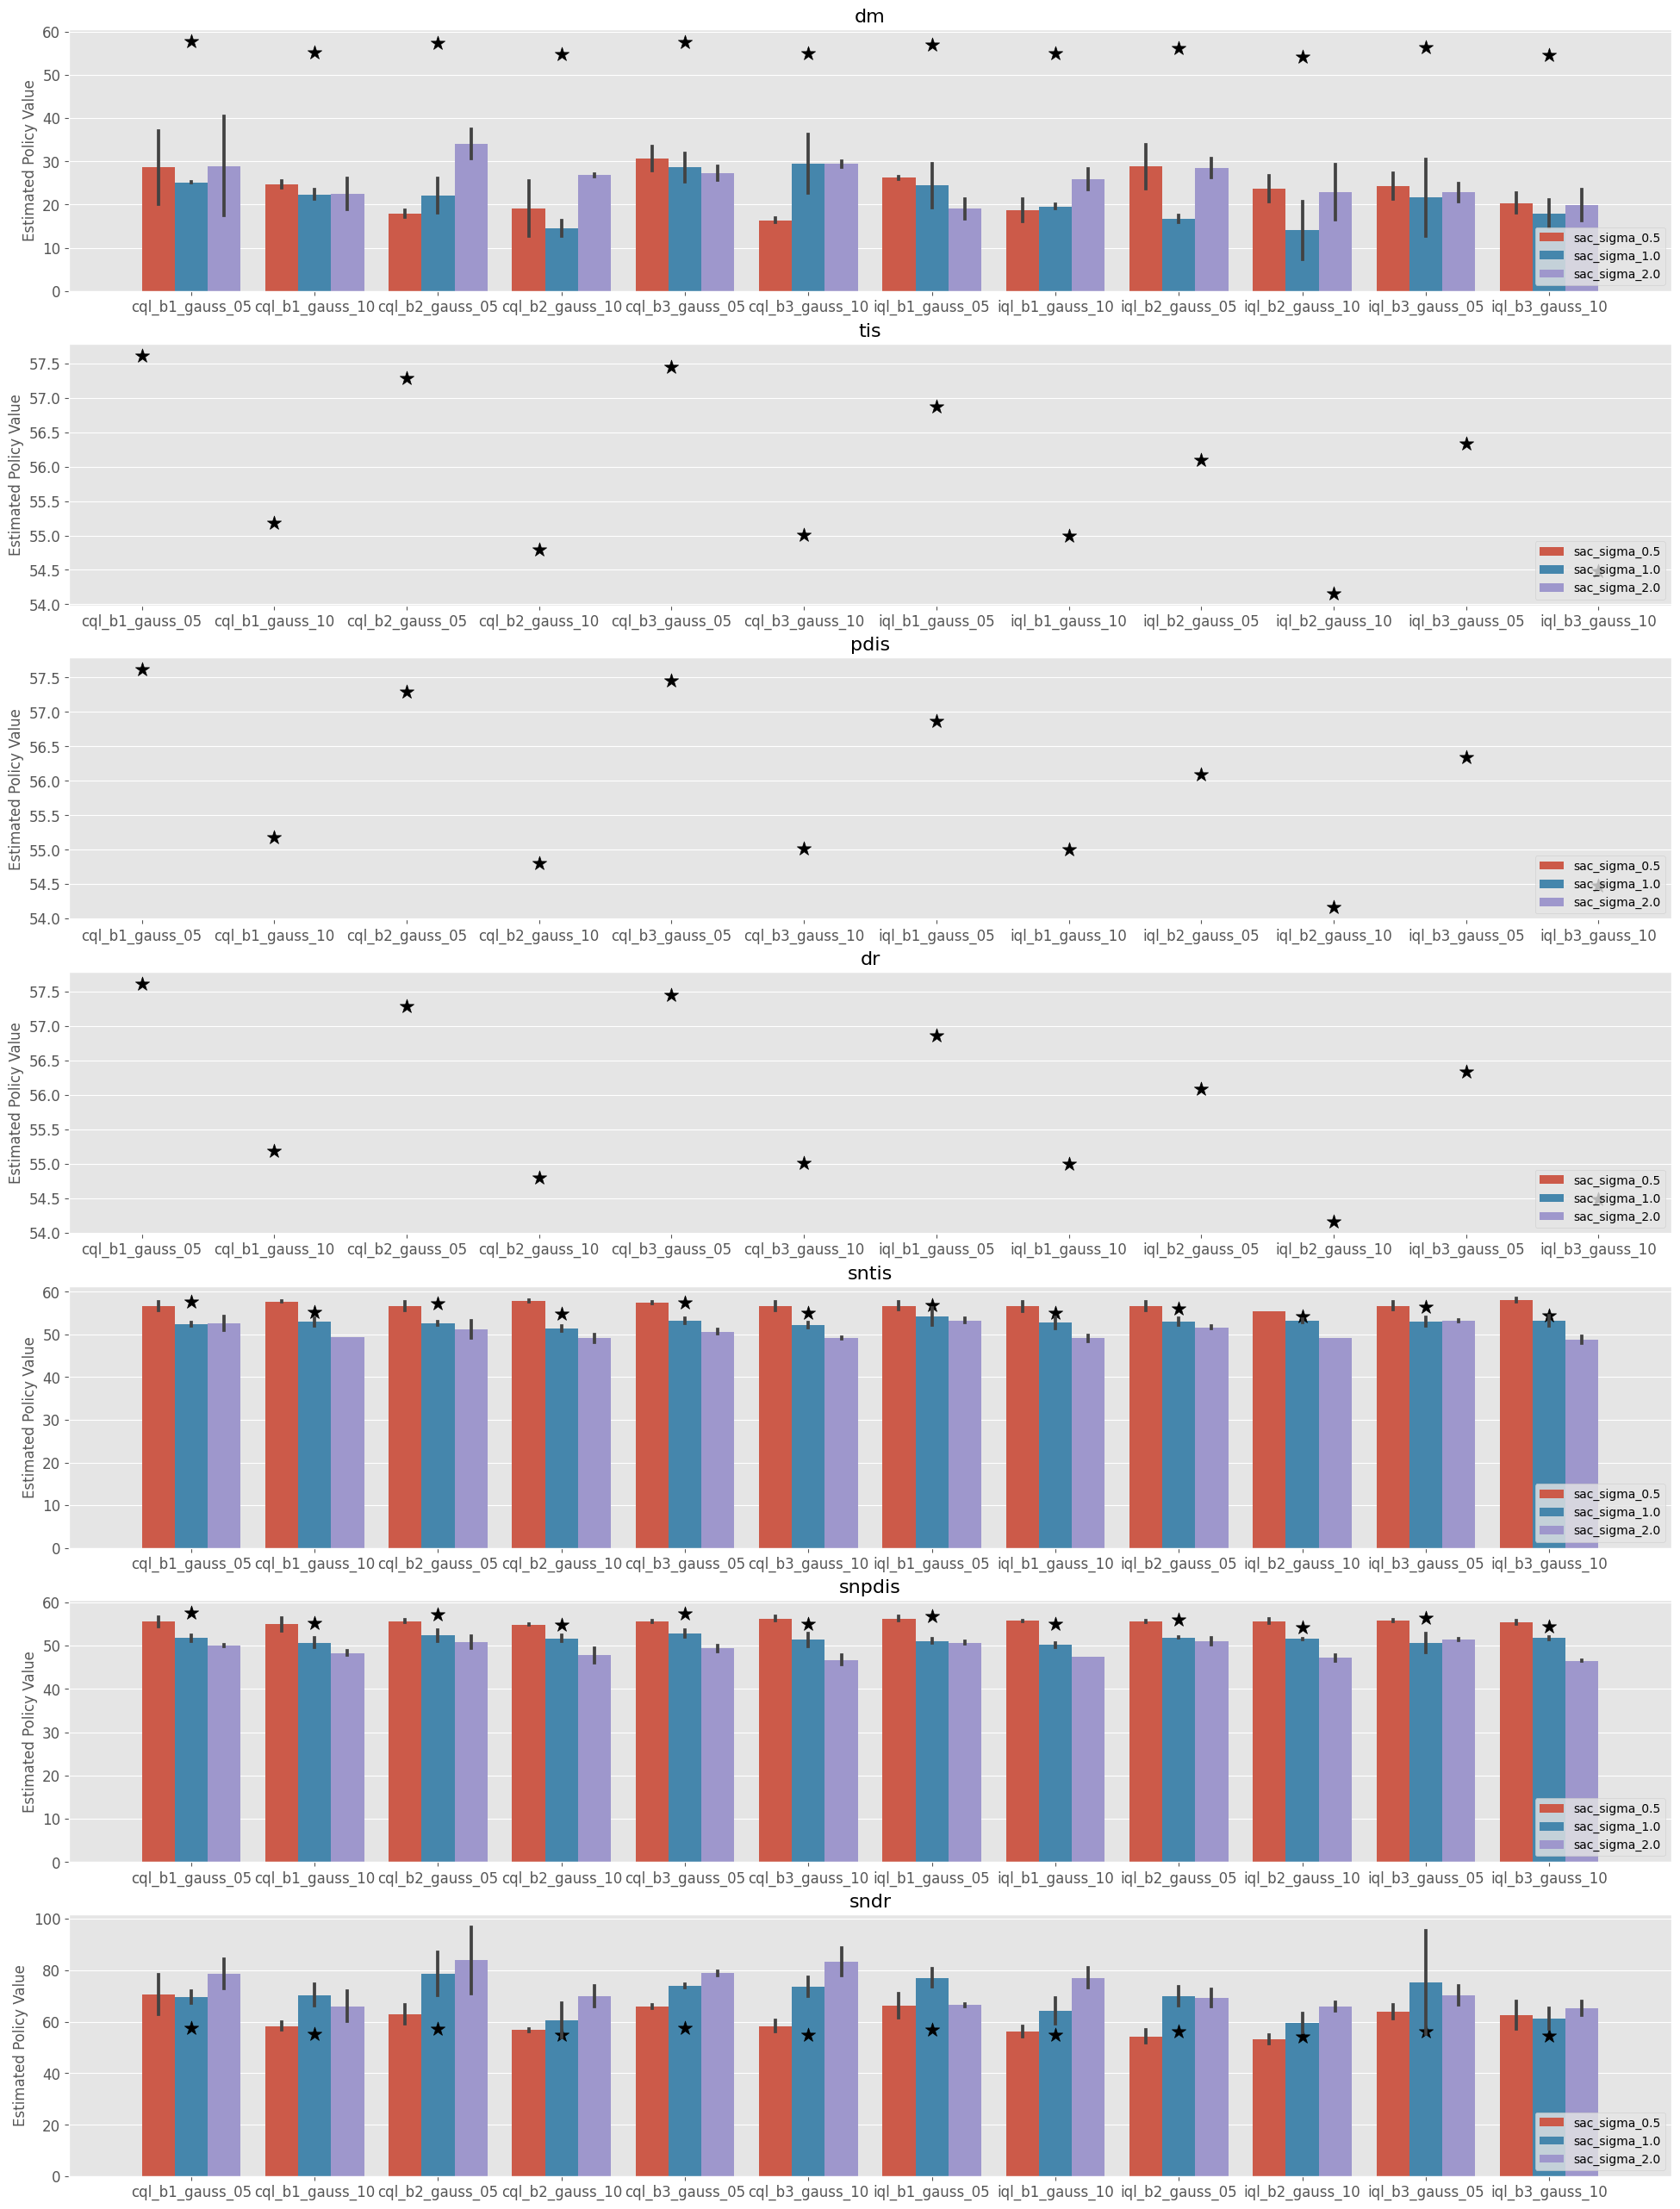

In [38]:
ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="ci",
    hue="policy",
)

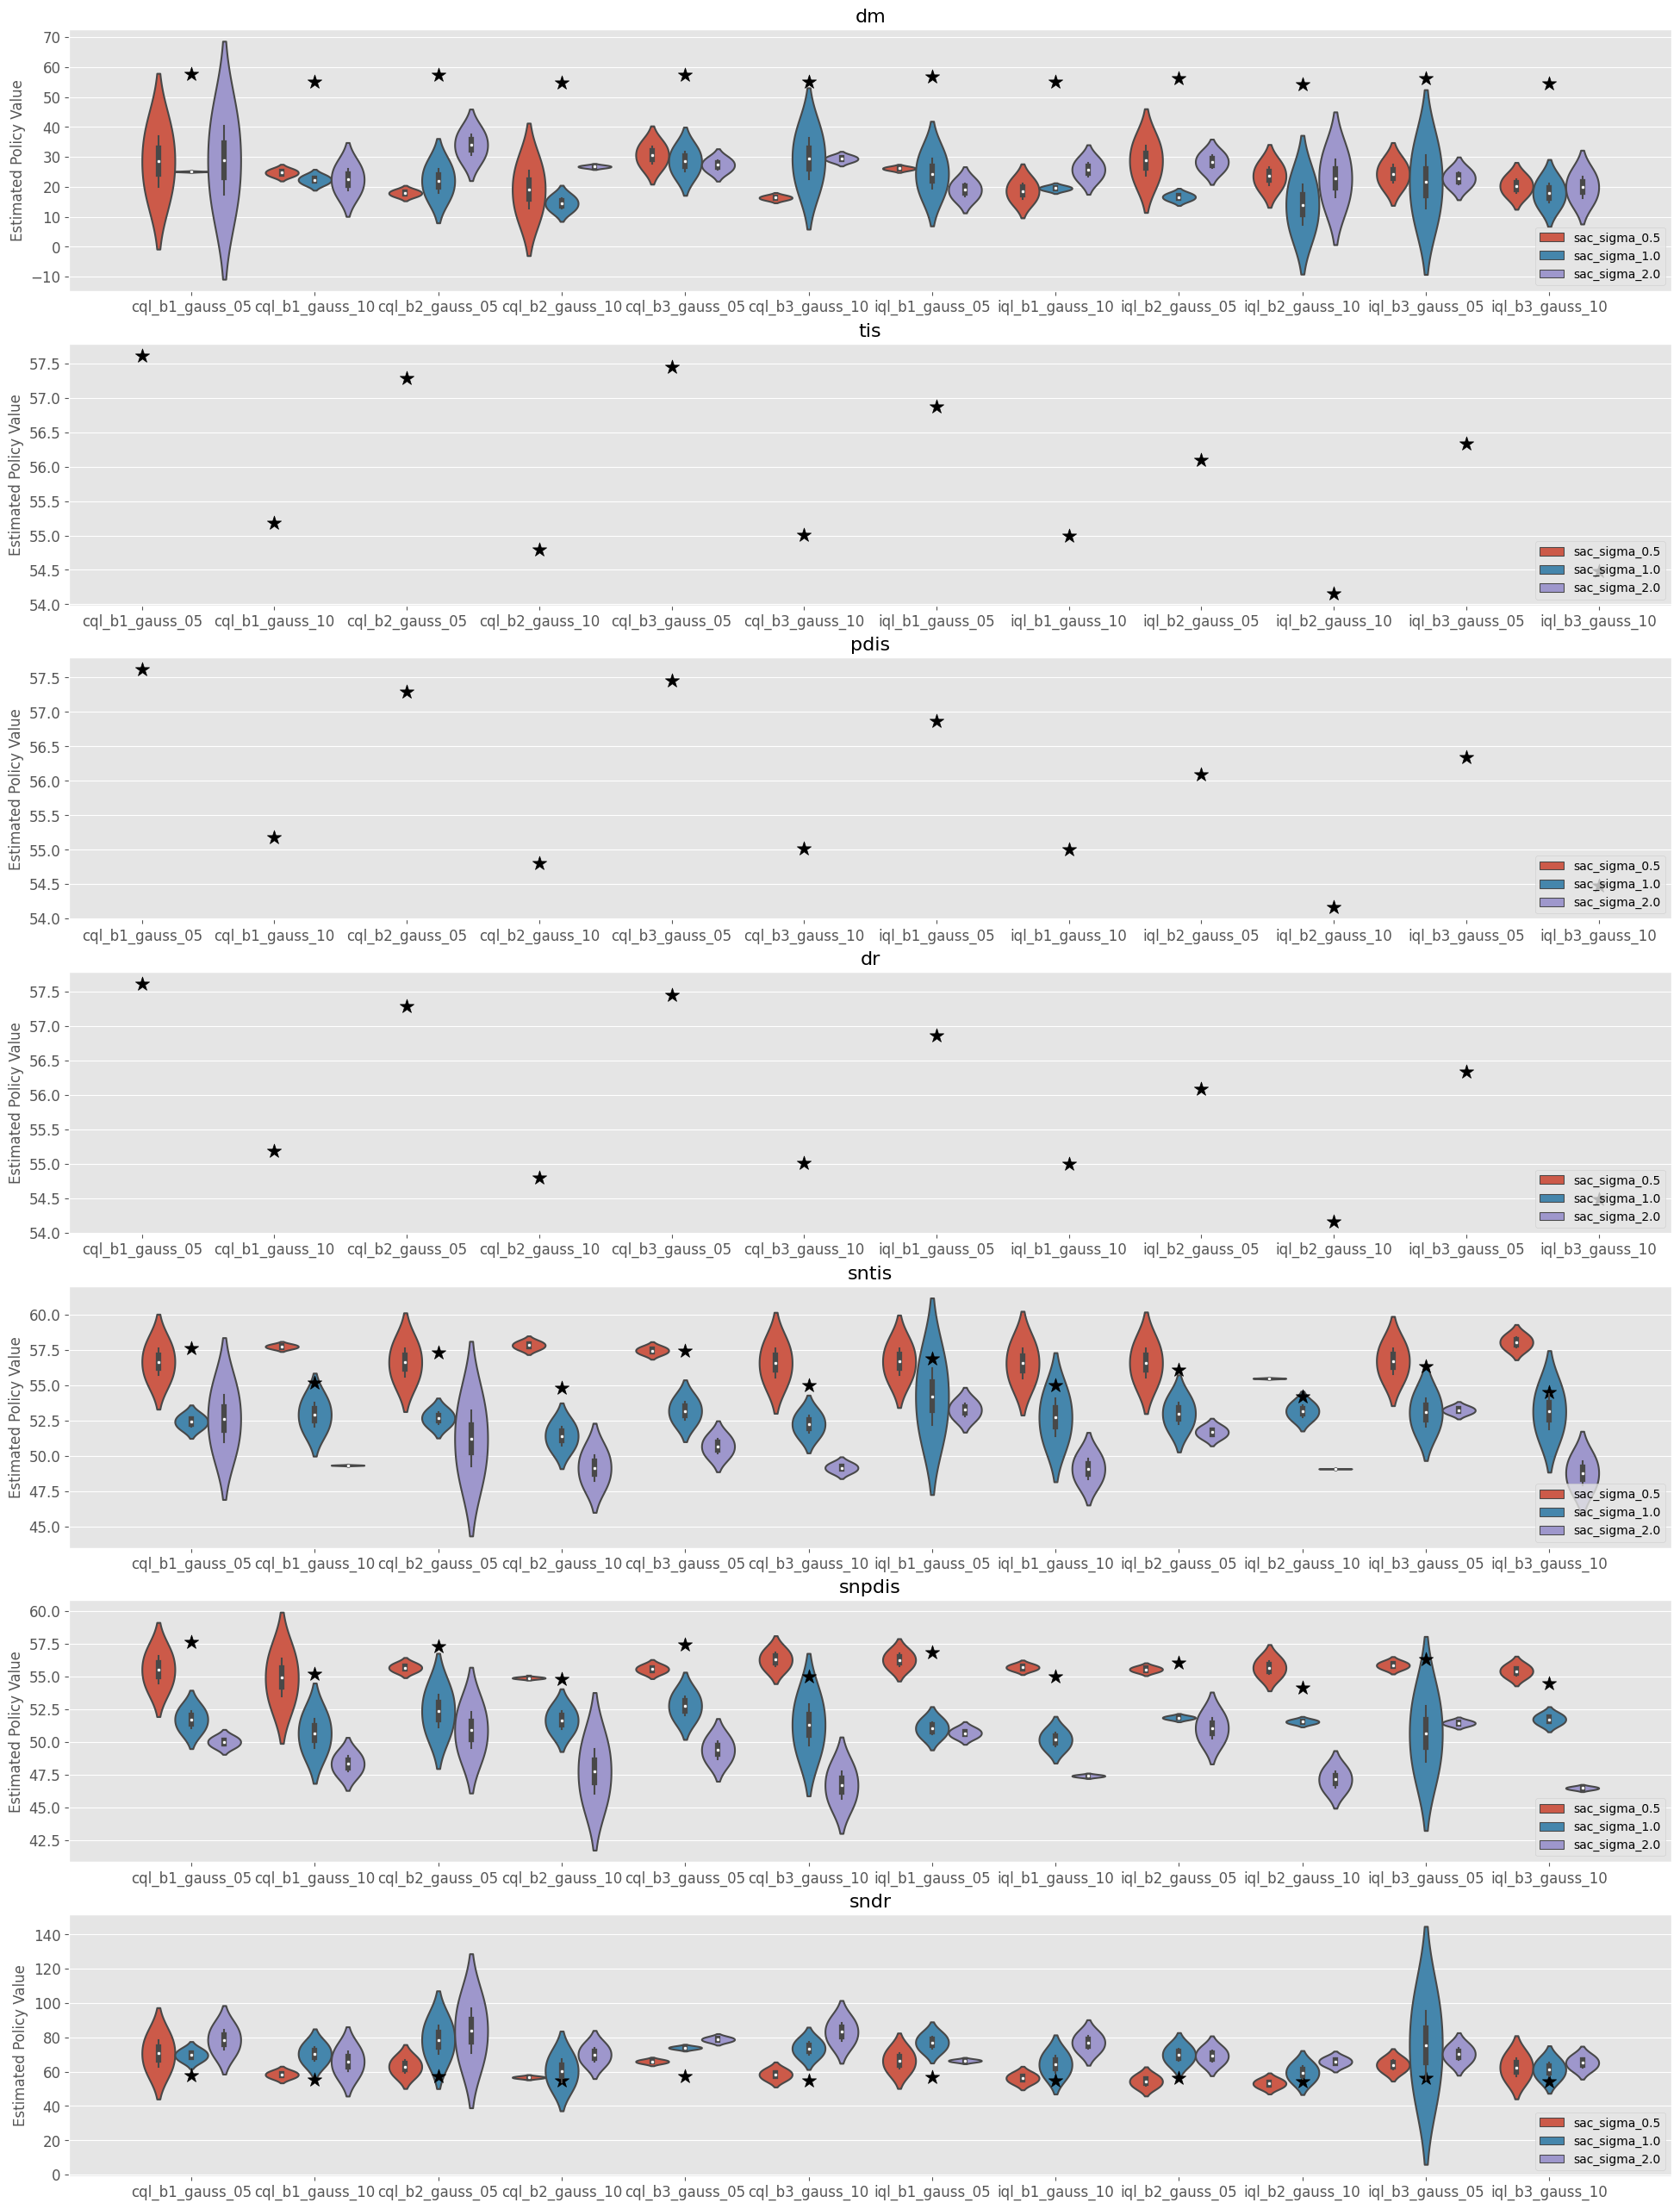

In [39]:
ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="violin",
    hue="policy",
)

KeyError: 'y'

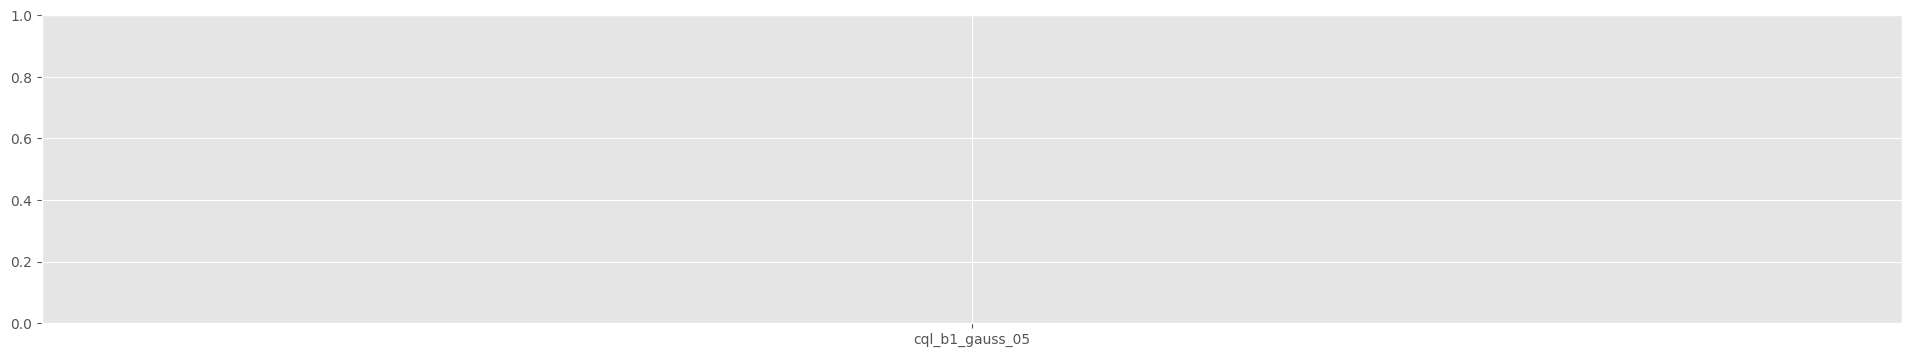

In [79]:
ope.visualize_policy_value_with_multiple_estimates(
    # compared_estimators=["dm", "tis", "pdis", "dr","sntis", "snpdis", "sndr"],
    compared_estimators=["tis"],
    input_dict=input_dict,
    plot_type="scatter",
    hue="policy",
)

#### Cumulative Distribution Function Estimation
We can also estimate various statistics regarding the policy performance based on the cumulative distribution function of the trajectory wise reward.

$$ F(t, \pi) := \mathbb{E}\left[ \mathbb{I} \left \{ \sum_{t=1}^T \gamma^{t-1} r_t \leq t \right \} \mid \pi \right] $$

Specifically, we can estimate the following performance metrics.
- Cumulative Distribution Function
- Mean of the return (i.e., policy value)
- Variance of the return
- Conditional Value at Risk
- Interquartile Range

In [41]:
from ofrl.ope import CumulativeDistributionOffPolicyEvaluation as CumulativeDistributionOPE
from ofrl.ope import ContinuousCumulativeDistributionDirectMethod as CD_DM
from ofrl.ope import ContinuousCumulativeDistributionTrajectoryWiseImportanceSampling as CD_IS
from ofrl.ope import ContinuousCumulativeDistributionTrajectoryWiseDoublyRobust as CD_DR
from ofrl.ope import ContinuousCumulativeDistributionSelfNormalizedTrajectoryWiseImportanceSampling as CD_SNIS
from ofrl.ope import ContinuousCumulativeDistributionSelfNormalizedTrajectoryWiseDoublyRobust as CD_SNDR

In [42]:
cd_ope = CumulativeDistributionOPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=[
        CD_DM(estimator_name="cdf_dm"), 
        CD_IS(estimator_name="cdf_is"), 
        CD_DR(estimator_name="cdf_dr"), 
        CD_SNIS(estimator_name="cdf_snis"), 
        CD_SNDR(estimator_name="cdf_sndr"),
    ],
)

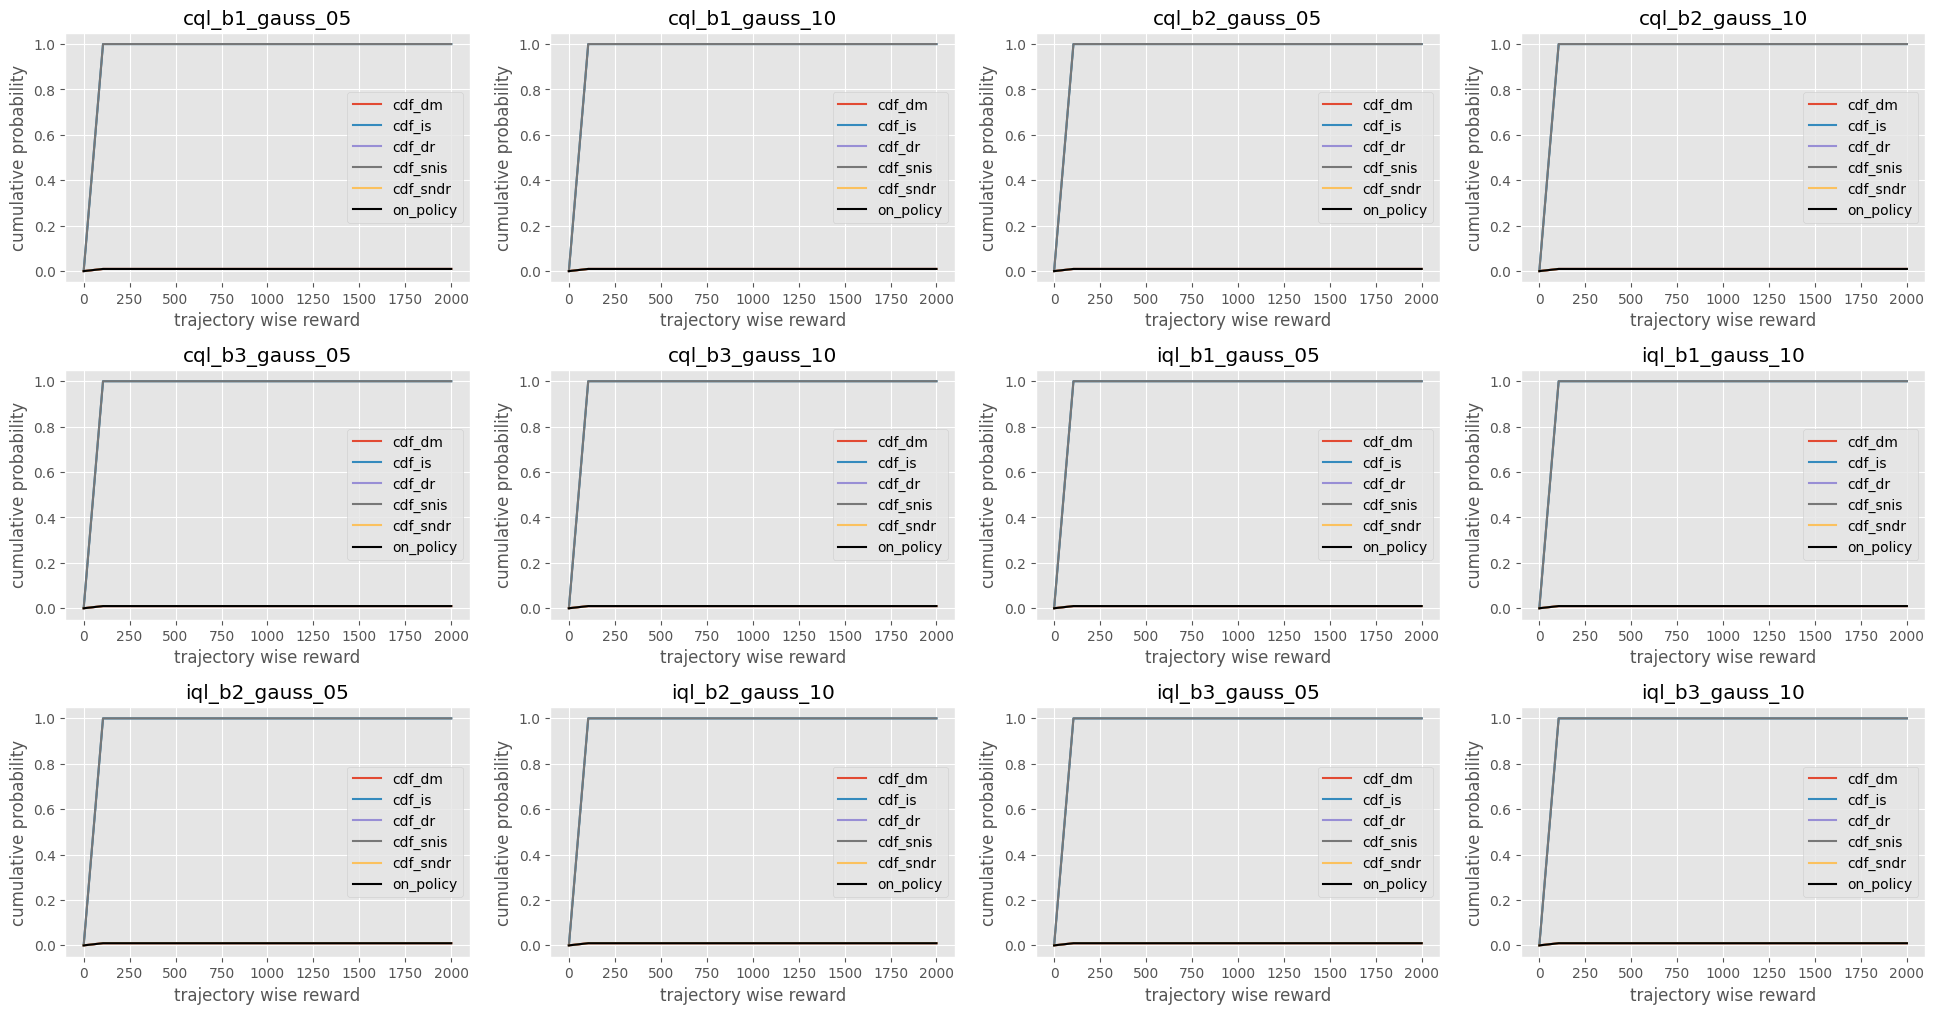

In [43]:
# cumulative distribution function
cd_ope.visualize_cumulative_distribution_function_with_multiple_estimates(
    input_dict, 
    behavior_policy_name="sac_sigma_1.0",
    plot_type="ci_hue",
    scale_min=0.0, 
    scale_max=2000.0, 
    n_partition=20, 
    n_cols=4,
)

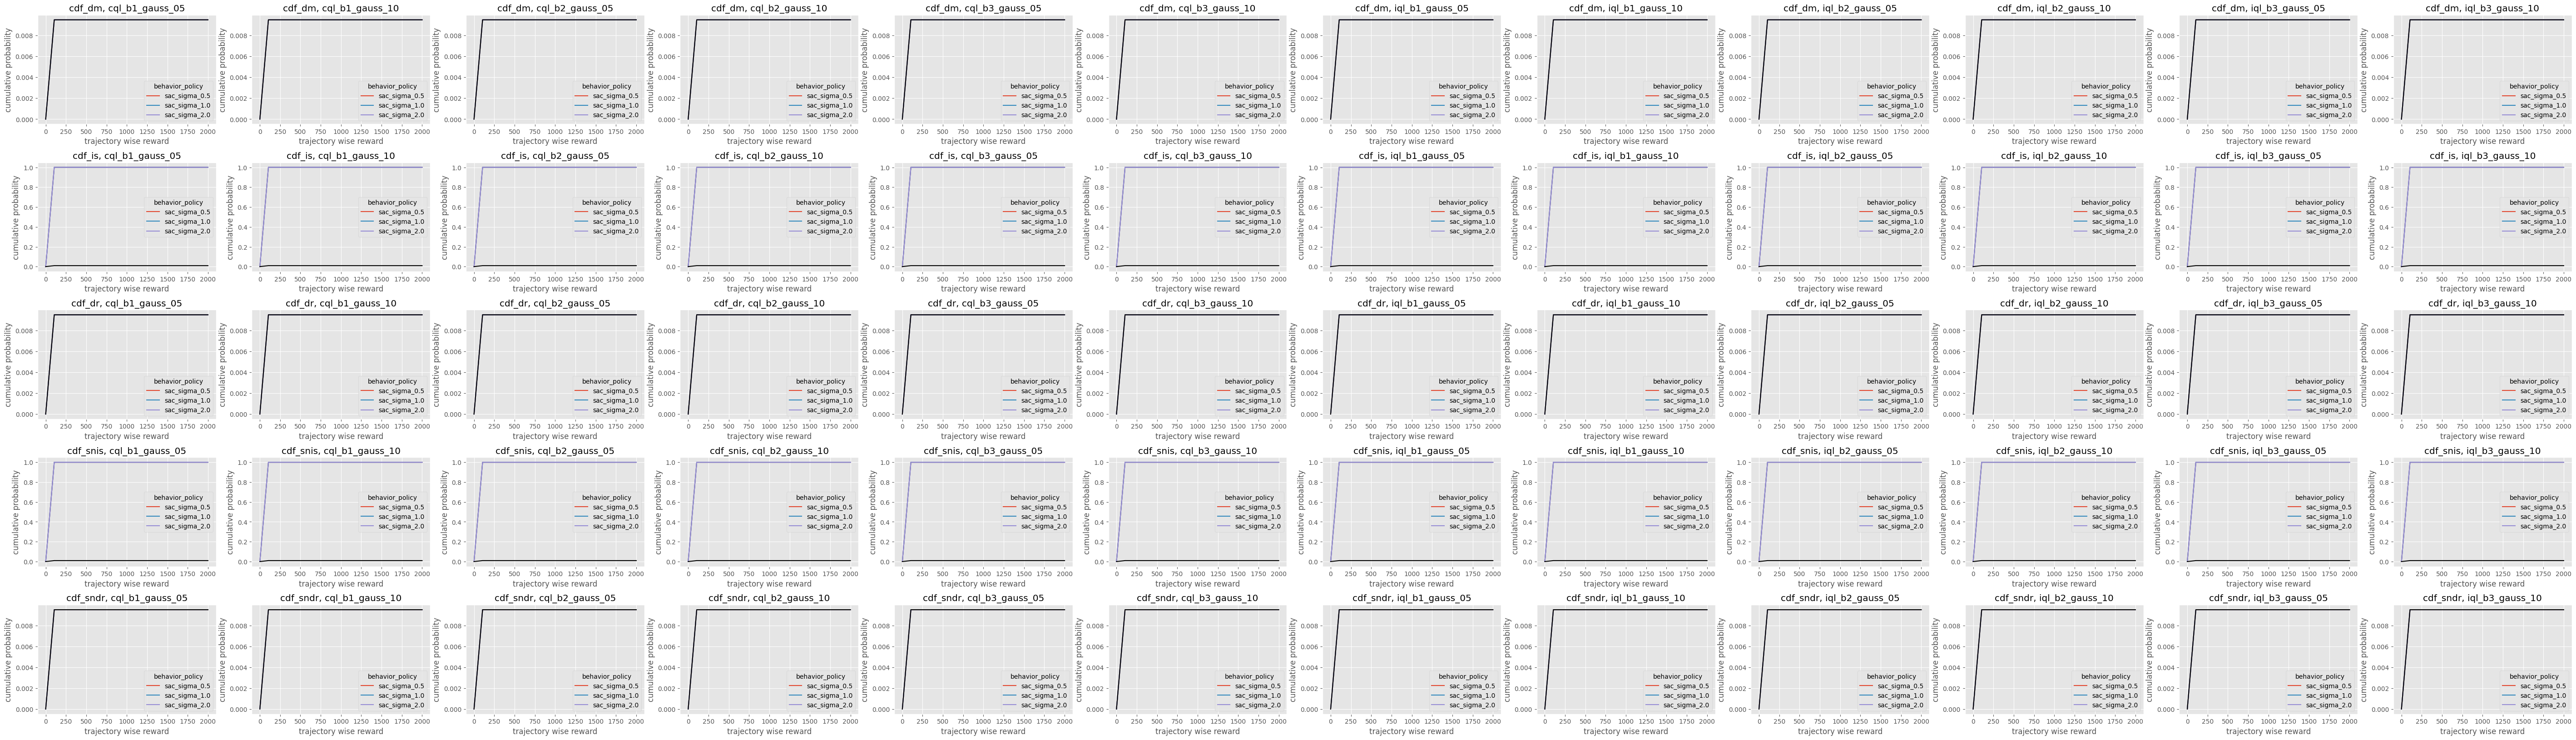

In [44]:
# cumulative distribution function
cd_ope.visualize_cumulative_distribution_function_with_multiple_estimates(
    input_dict, 
    plot_type="ci_behavior_policy",
    hue="policy",
    scale_min=0.0, 
    scale_max=2000.0, 
    n_partition=20, 
)

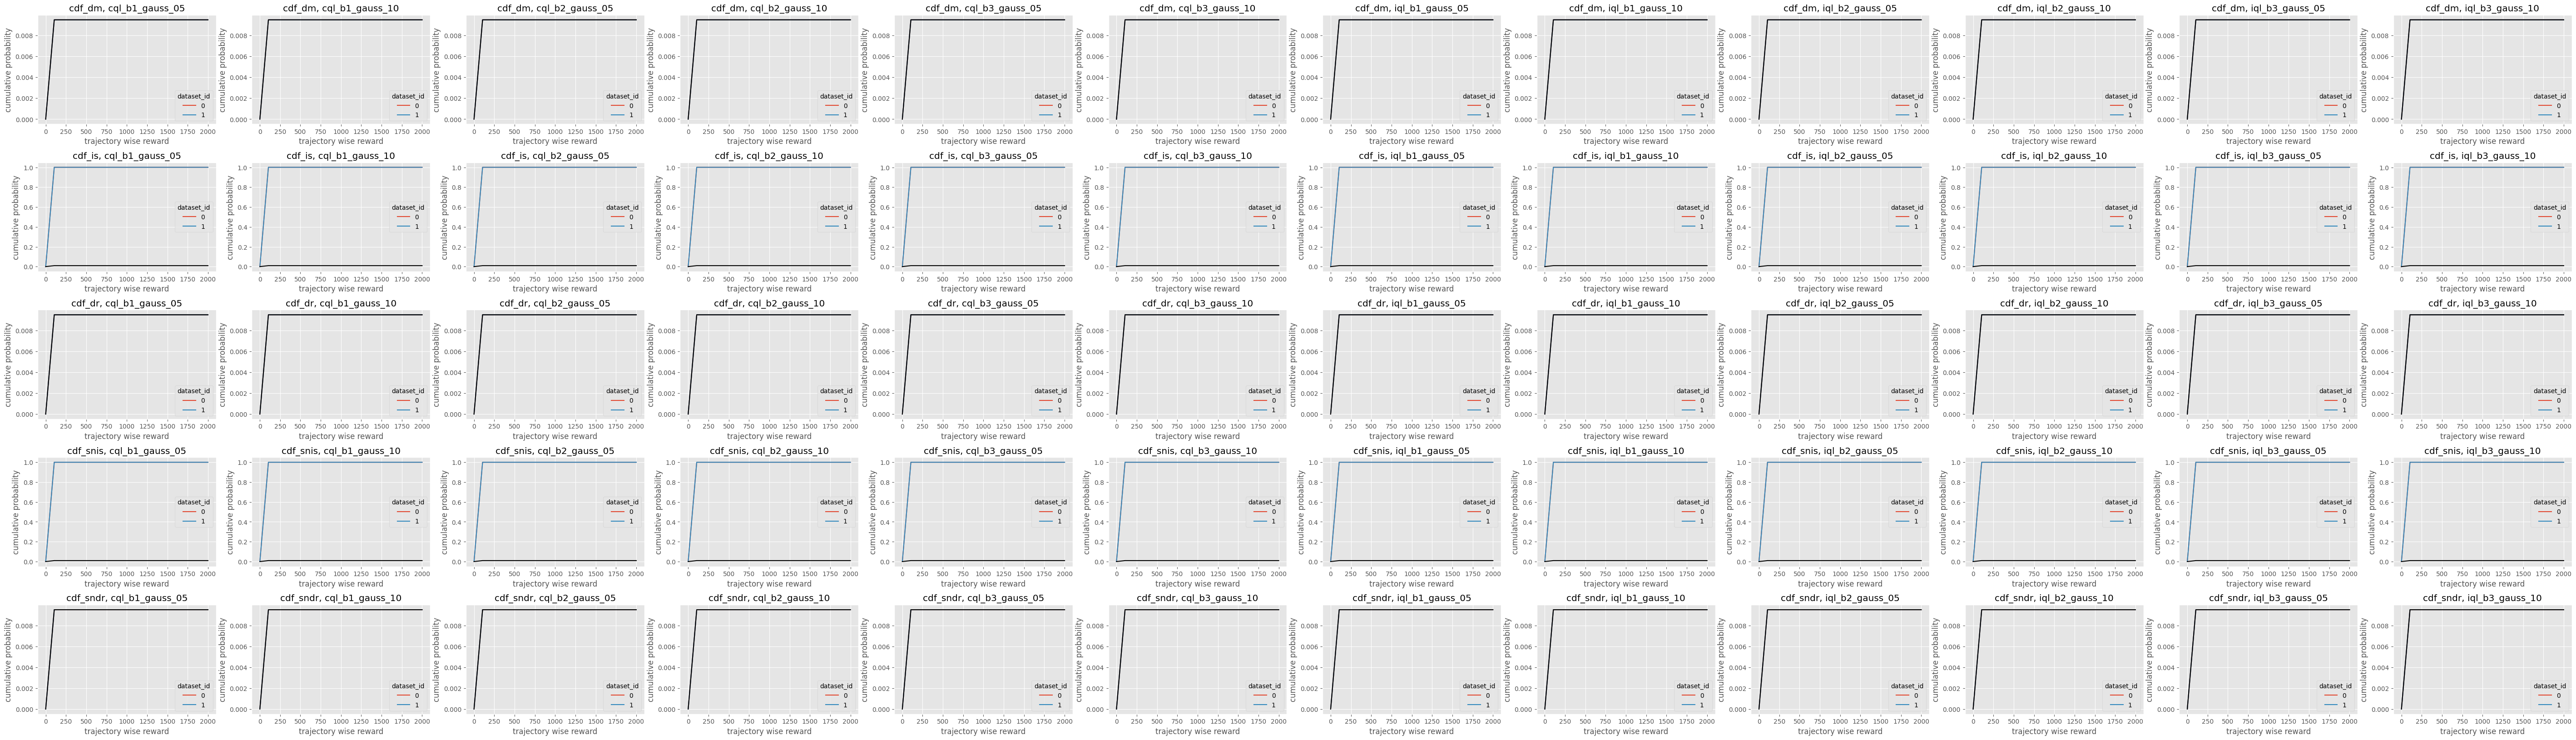

In [45]:
# cumulative distribution function
cd_ope.visualize_cumulative_distribution_function_with_multiple_estimates(
    input_dict, 
    behavior_policy_name="sac_sigma_1.0",
    plot_type="enumerate",
    hue="policy",
    scale_min=0.0, 
    scale_max=2000.0, 
    n_partition=20, 
)

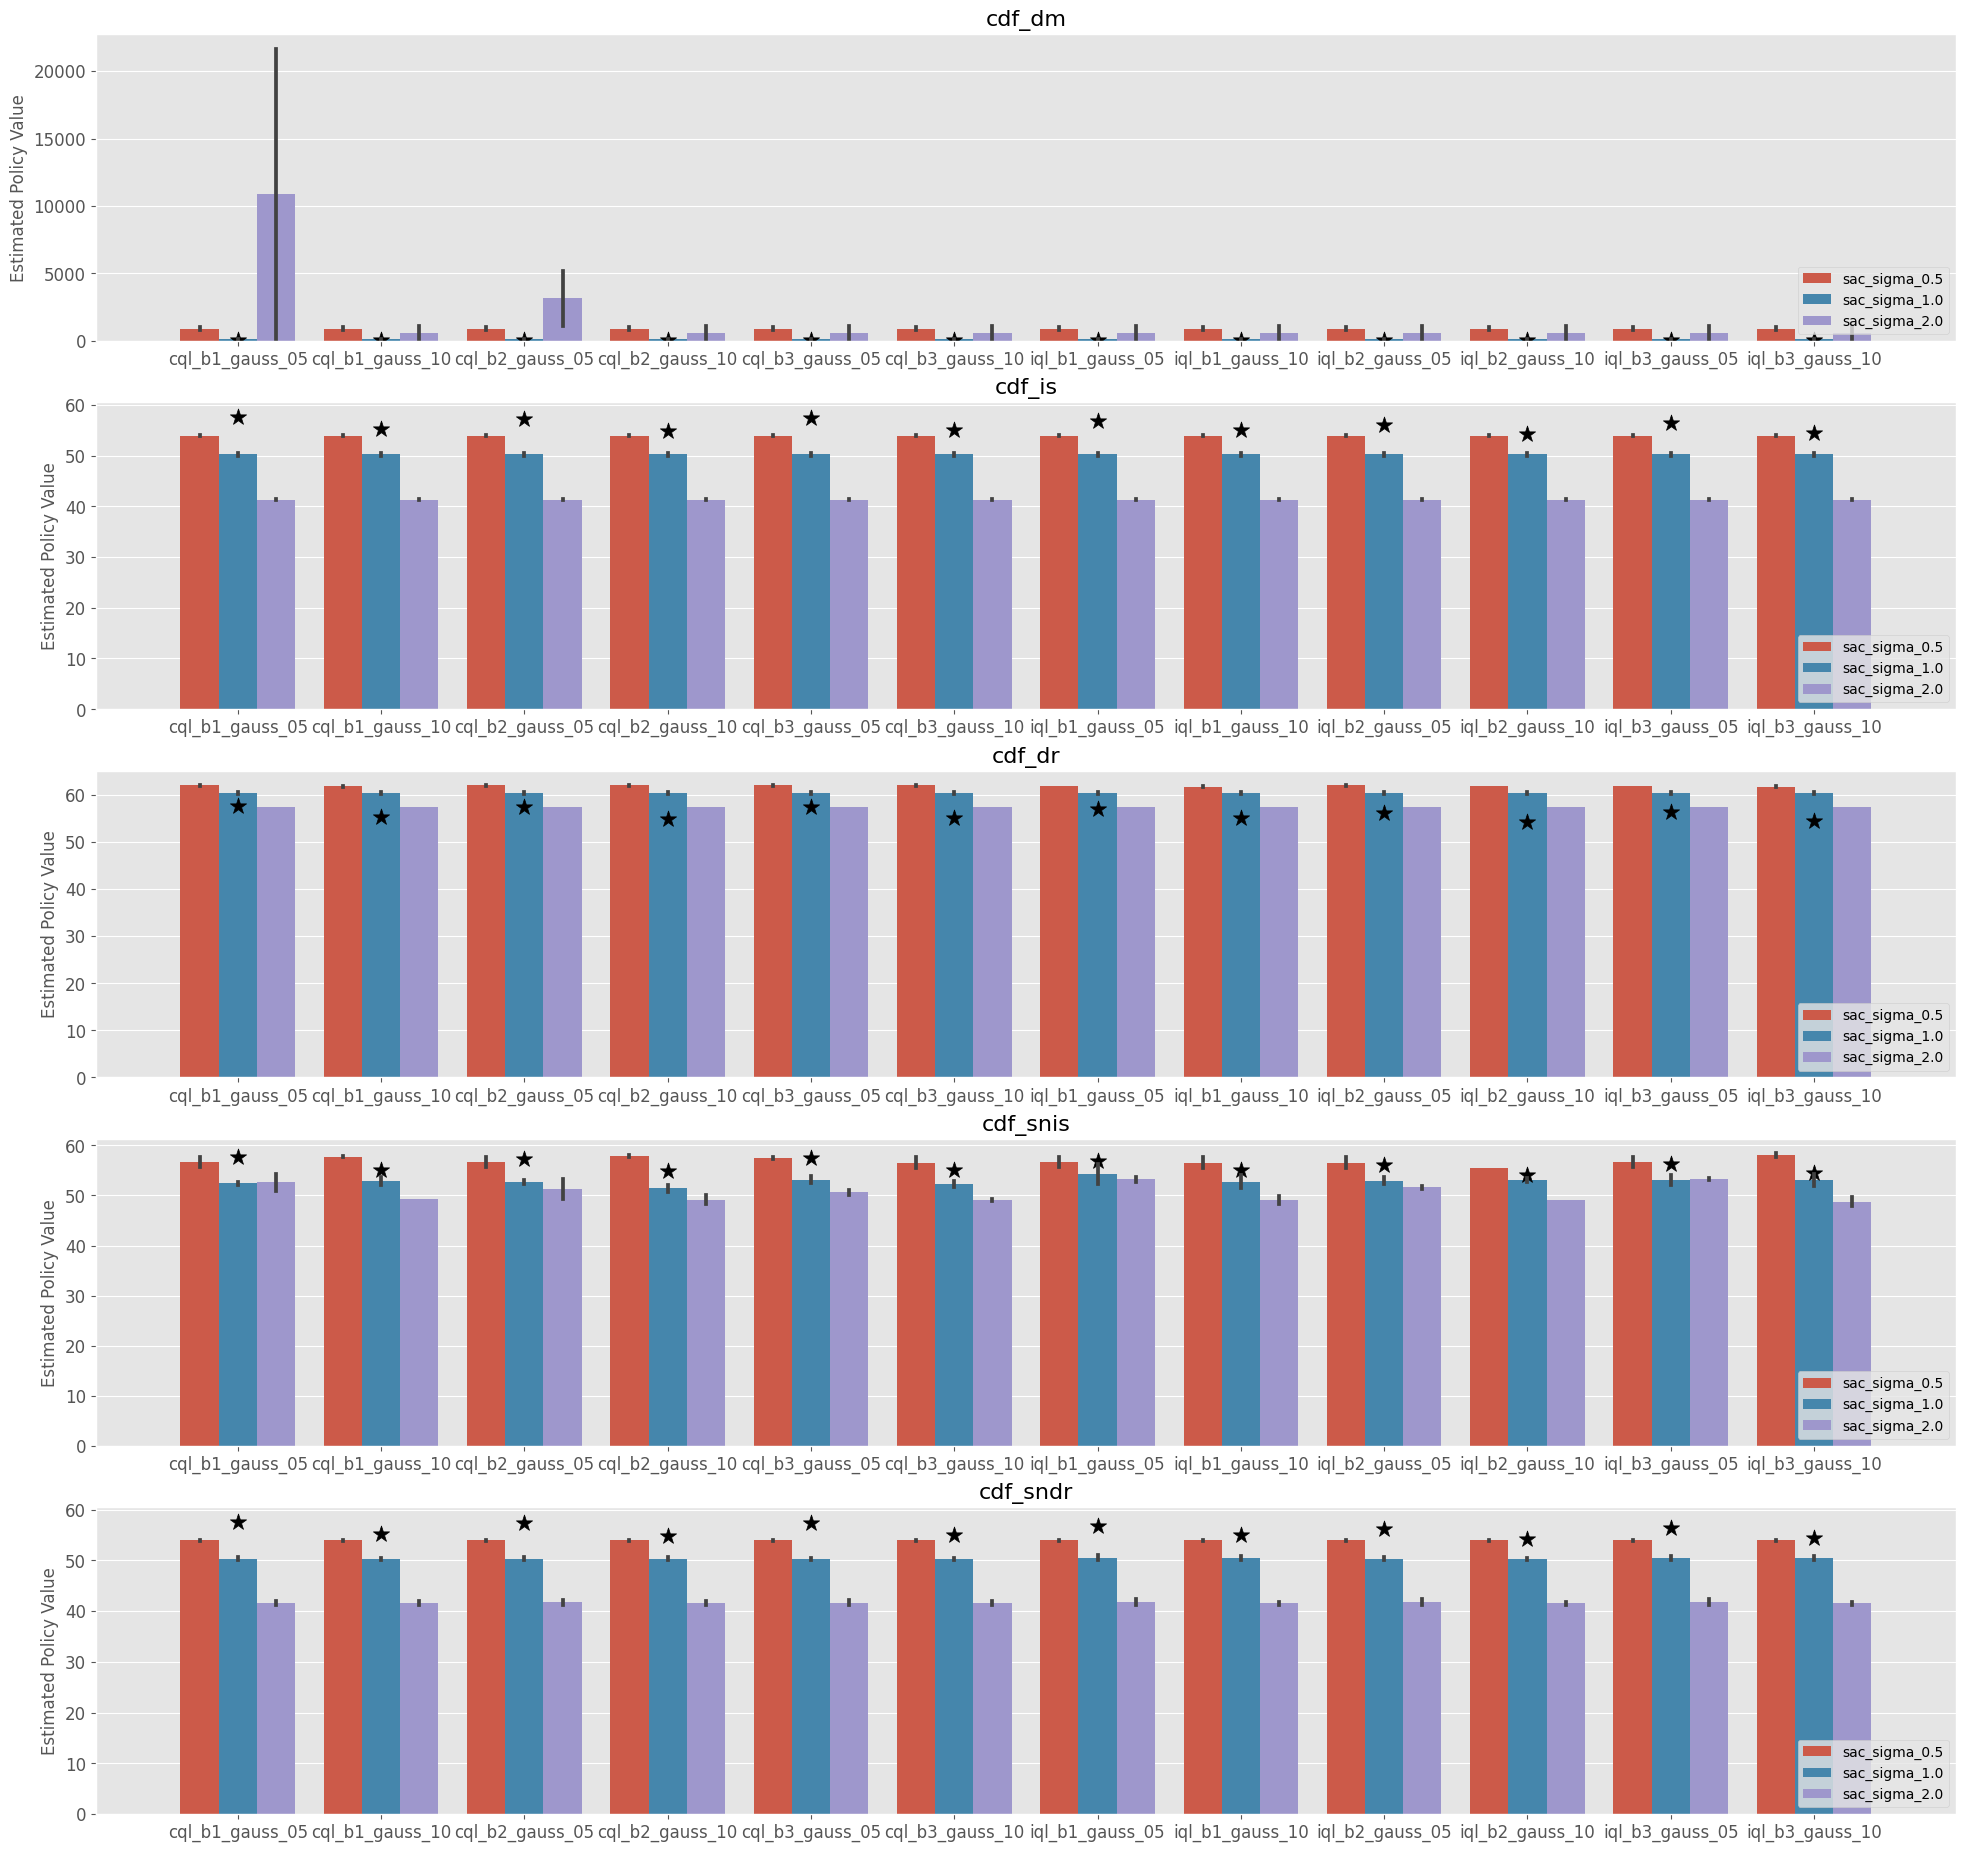

In [46]:
cd_ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="ci",
    hue="policy",
)

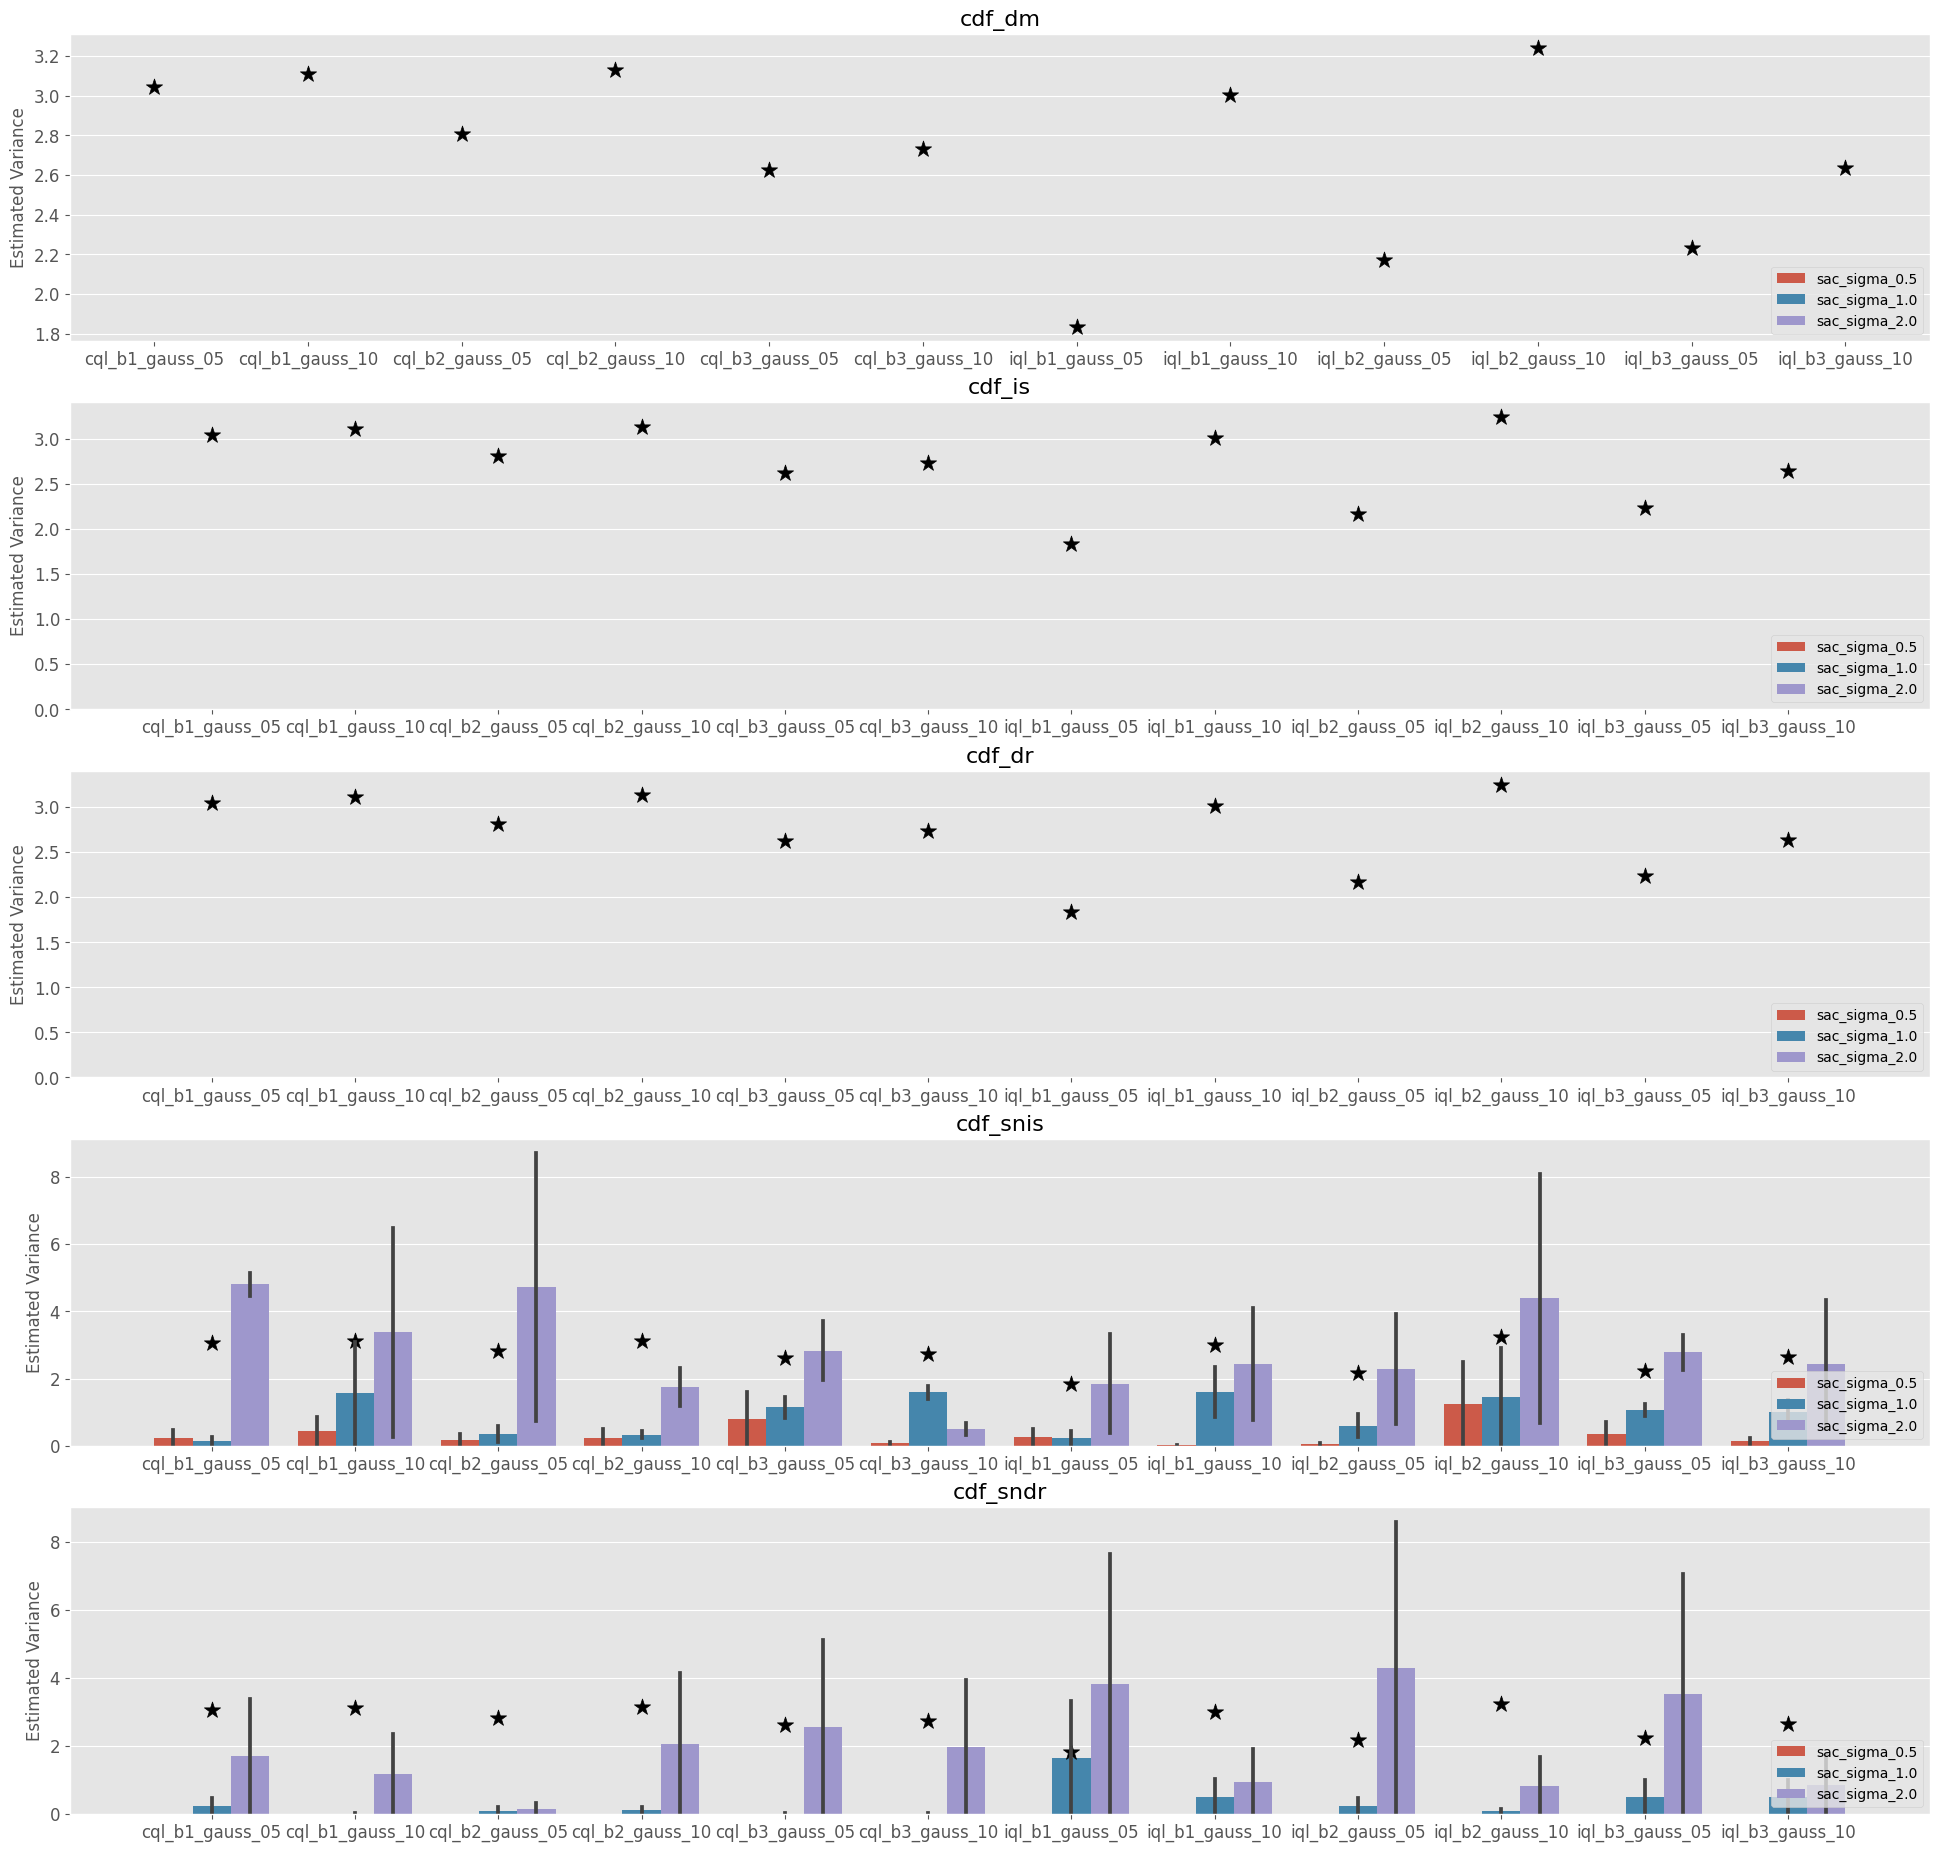

In [47]:
cd_ope.visualize_variance_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="ci",
    hue="policy",
)

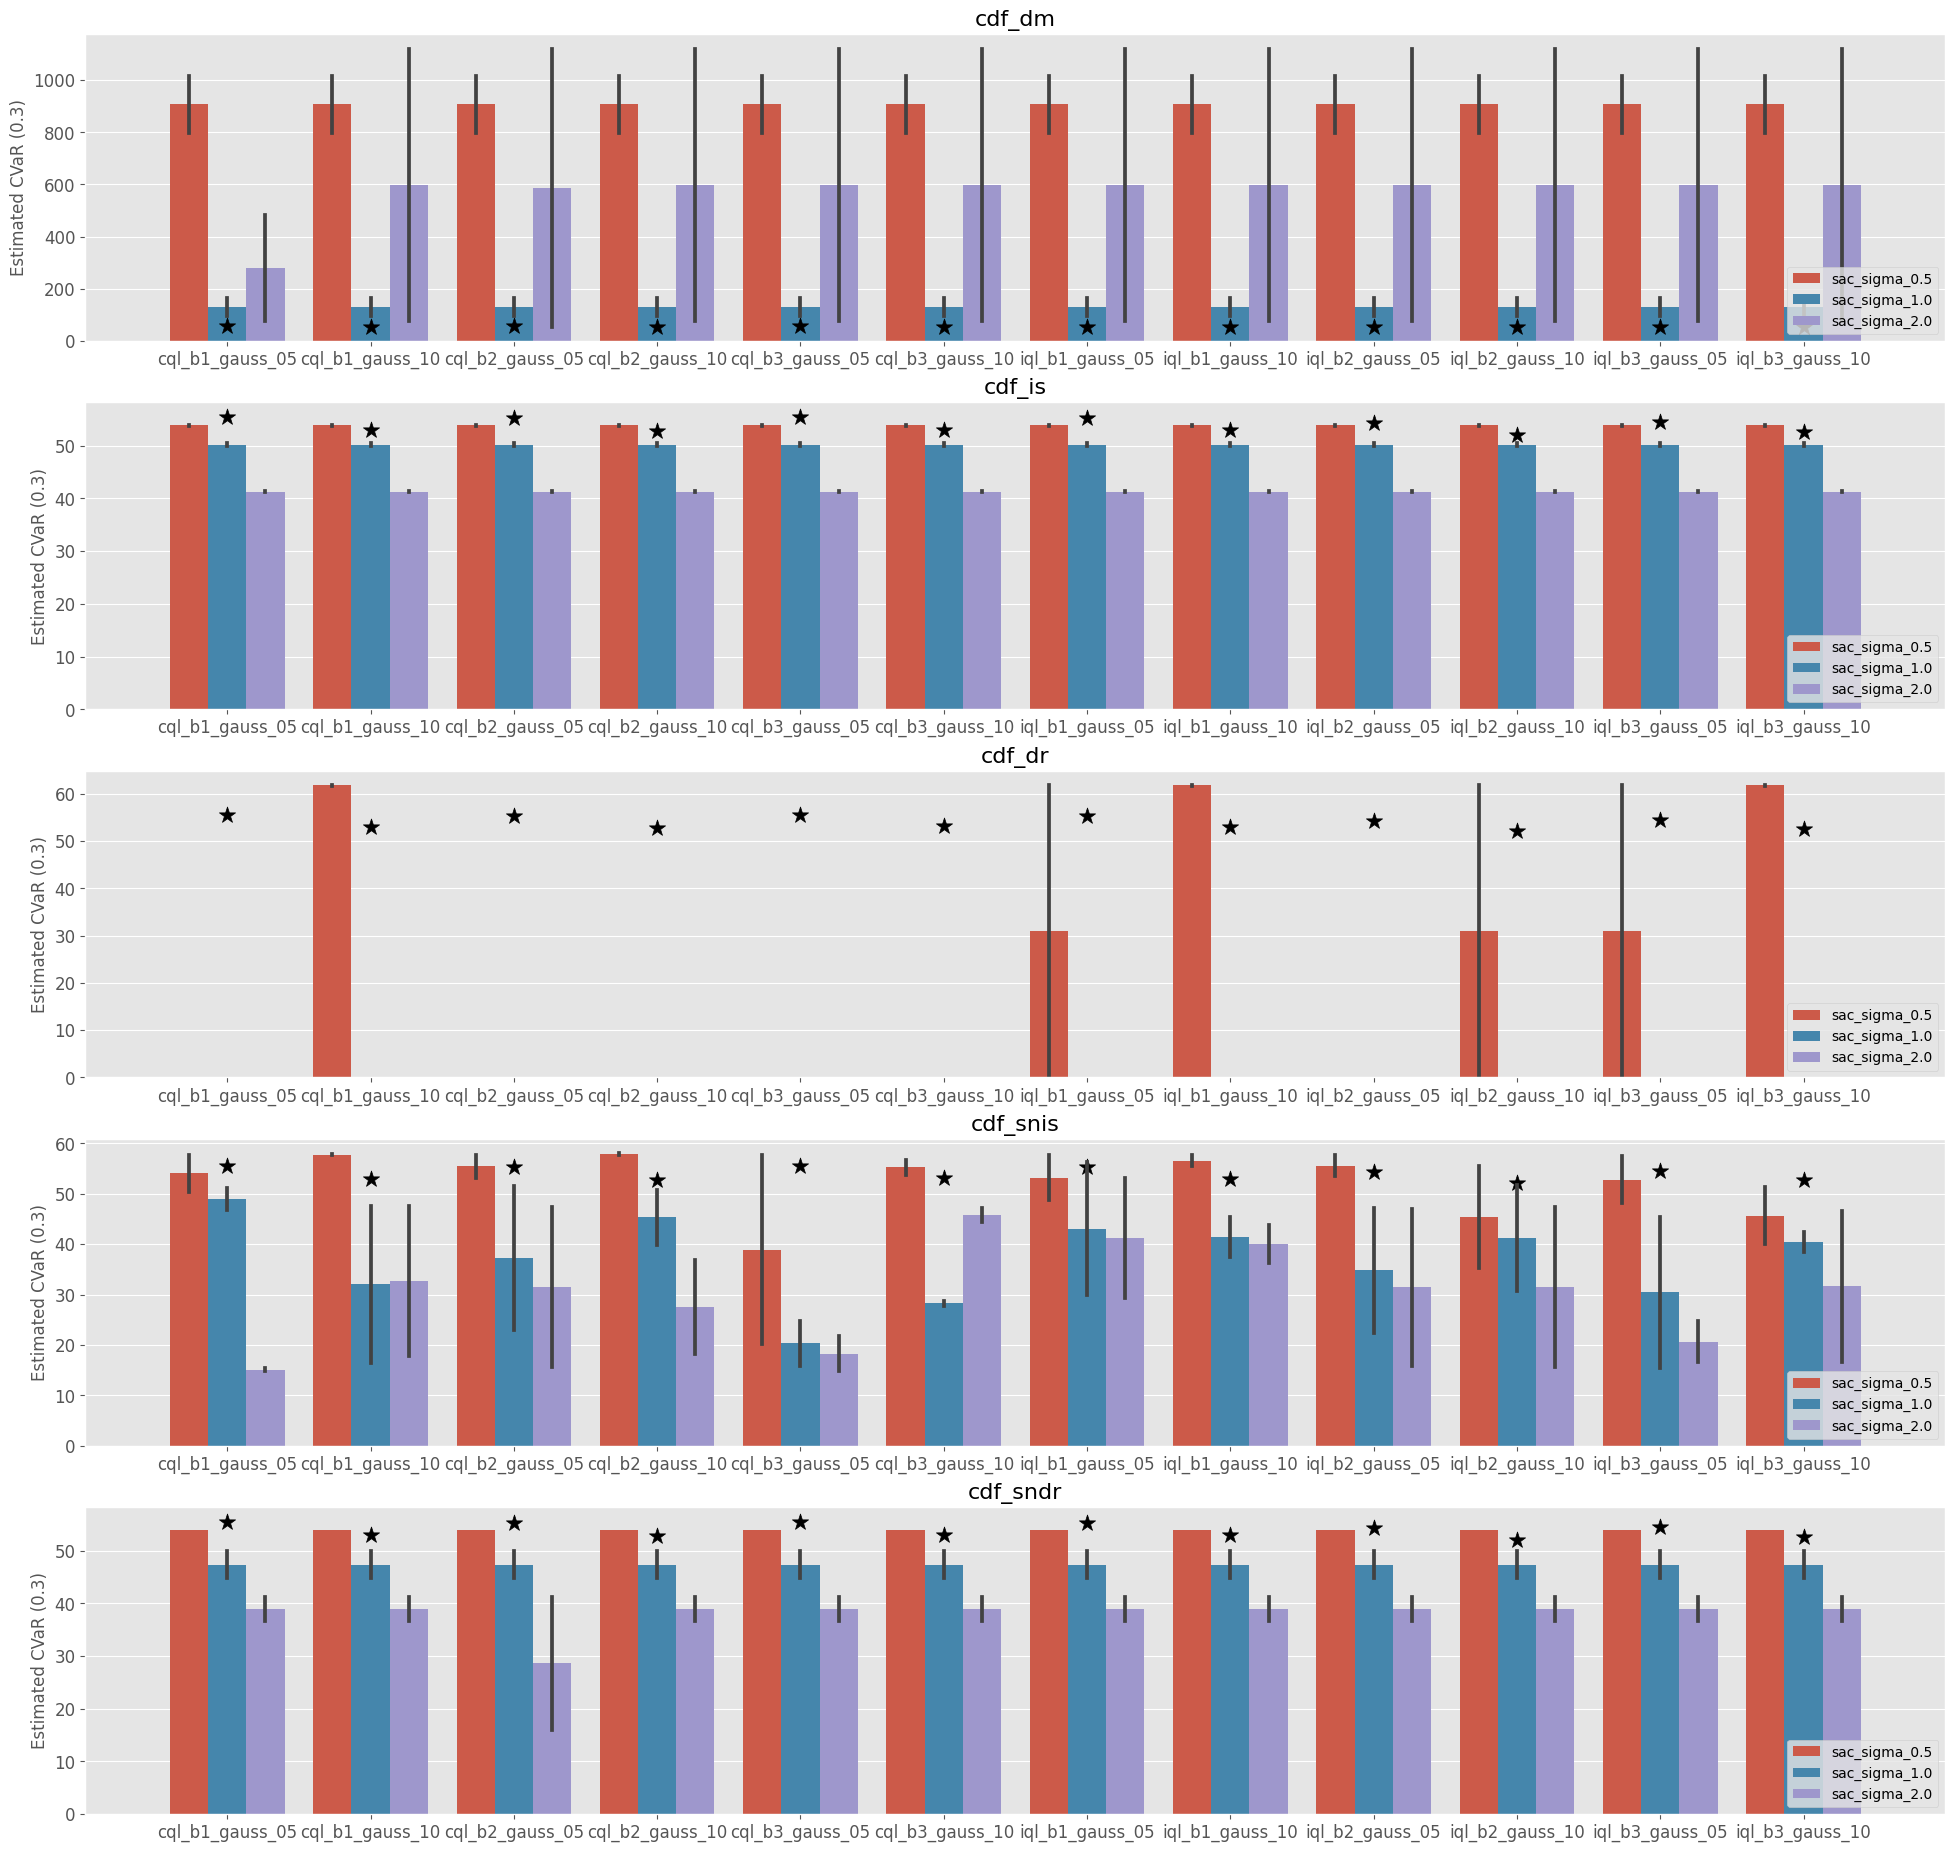

In [48]:
cd_ope.visualize_conditional_value_at_risk_with_multiple_estimates(
    input_dict=input_dict,
    alpha=0.3,
    plot_type="ci",
    hue="policy",
)

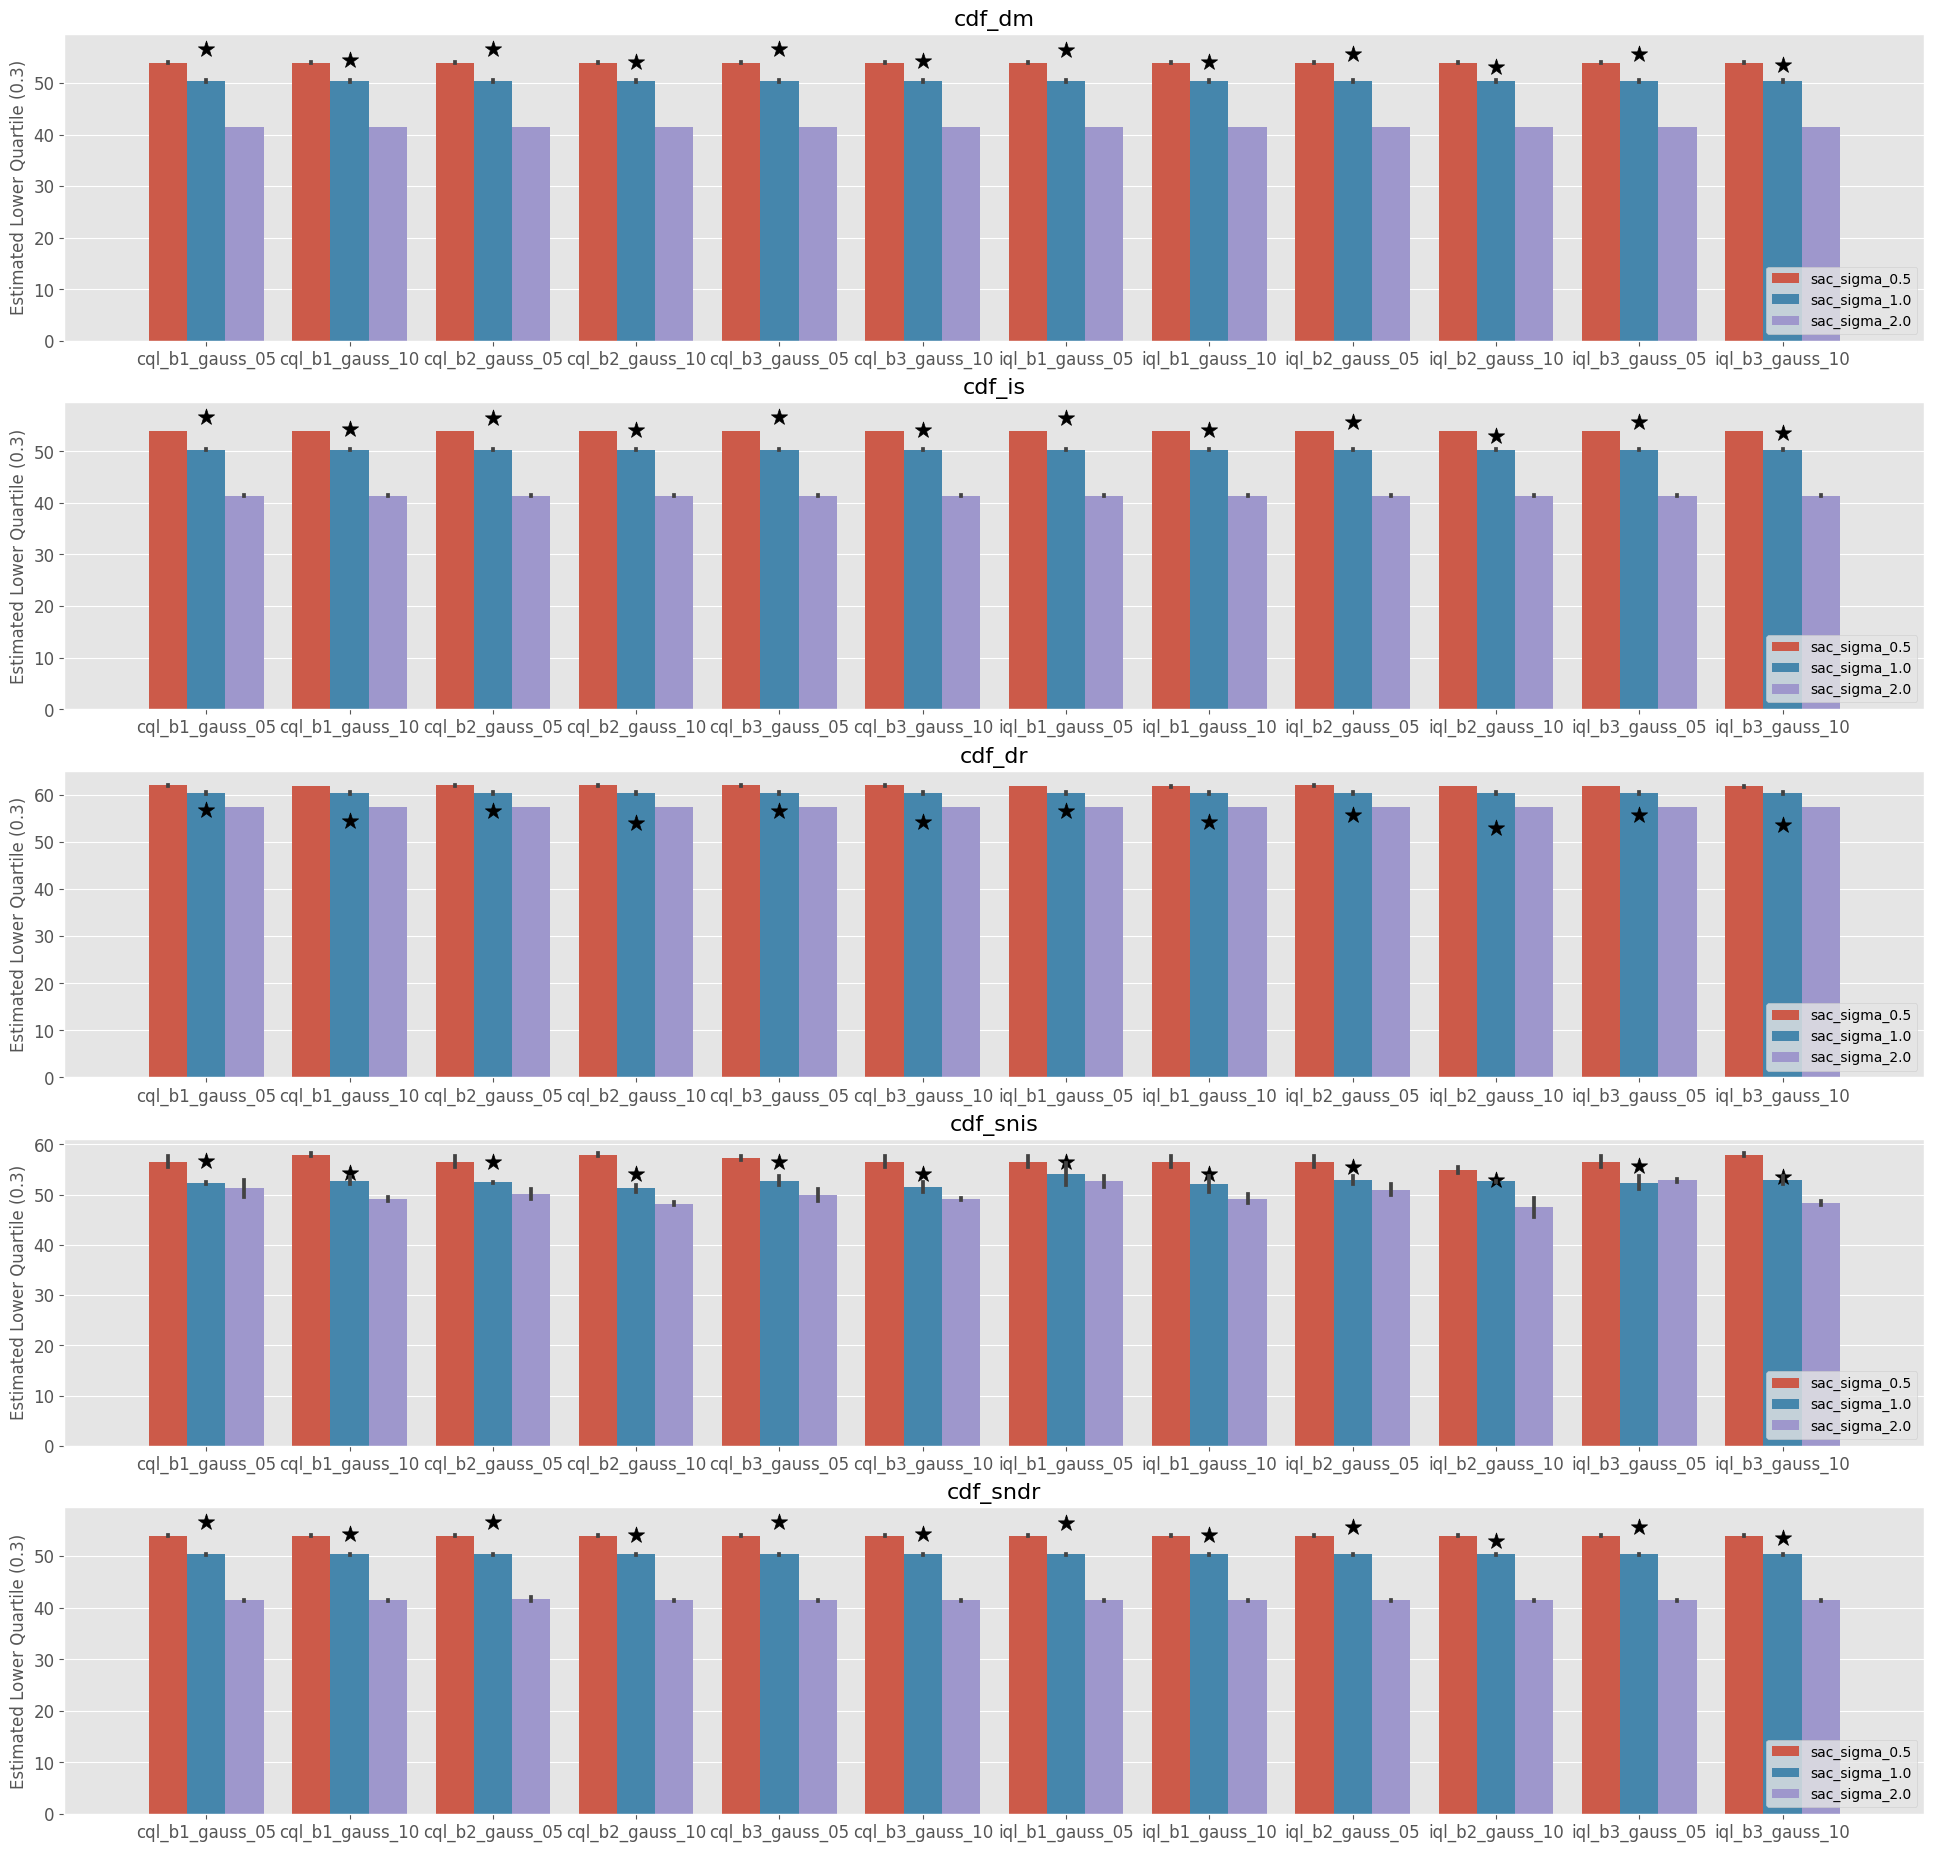

In [49]:
cd_ope.visualize_lower_quartile_with_multiple_estimates(
    input_dict=input_dict,
    alpha=0.3,
    plot_type="ci",
    hue="policy",
)

## 3. Off-Policy Selection

Off Policy Selection aims to select the ''best'' policy among several candidate policies based on some metrics.

In [50]:
from ofrl.ope import OffPolicySelection

In [51]:
ops = OffPolicySelection(
    ope=ope,
    cumulative_distribution_ope=cd_ope,
)

In [52]:
true_selection_result = ops.obtain_true_selection_result(
    input_dict=input_dict,
    return_variance=True,
    return_lower_quartile=True,
    return_conditional_value_at_risk=True,
    return_by_dataframe=True,
)
true_selection_result[behavior_policies[0].name][0]

ranking  policy_value  relative_policy_value  variance  \
0   cql_b1_gauss_05     57.615818               1.148566  3.042638   
1   cql_b3_gauss_05     57.451167               1.145284  2.623799   
2   cql_b2_gauss_05     57.290145               1.142074  2.807722   
3   iql_b1_gauss_05     56.869009               1.133679  1.834471   
4   iql_b3_gauss_05     56.337105               1.123075  2.234826   
5   iql_b2_gauss_05     56.089034               1.118130  2.169840   
6   cql_b1_gauss_10     55.182377               1.100056  3.110576   
7   cql_b3_gauss_10     55.010839               1.096636  2.731114   
8   iql_b1_gauss_10     54.997060               1.096362  3.005005   
9   cql_b2_gauss_10     54.797879               1.092391  3.129203   
10  iql_b3_gauss_10     54.479191               1.086038  2.638085   
11  iql_b2_gauss_10     54.157917               1.079633  3.240973   

   ranking_by_lower_quartile  lower_quartile  \
0            cql_b1_gauss_05       54.798530   
1            cql_b1_gauss_10       54.737530   
2            cql_b2_gauss_05       54.585969   
3            cql_b2_gauss_10       54.475632   
4            cql_b3_gauss_05       53.730036   
5            cql_b3_gauss_10       53.411385   
6            iql_b1_gauss_05       52.452434   
7            iql_b1_gauss_10       52.258973   
8            iql_b2_gauss_05       52.105652   
9            iql_b2_gauss_10       52.065507   
10           iql_b3_gauss_05       52.062714   
11           iql_b3_gauss_10       51.330941   

   ranking_by_conditional_value_at_risk  conditional_value_at_risk  
0                       cql_b3_gauss_05                  54.331540  
1                       cql_b1_gauss_05                  54.219396  
2                       cql_b2_gauss_05                  54.108208  
3                       iql_b1_gauss_05                  53.816843  
4                       iql_b3_gauss_05                  53.292076  
5                       iql_b2_gauss_05                  52.614960  
6                       cql_b3_gauss_10                  51.906914  
7                       cql_b1_gauss_10                  51.571206  
8                       iql_b1_gauss_10                  51.415306  
9                       iql_b3_gauss_10                  51.169935  
10                      cql_b2_gauss_10                  50.941702  
11                      iql_b2_gauss_10                  50.319080

In [53]:
ranking_df, metric_df = ops.select_by_policy_value(
    input_dict=input_dict,
    return_true_values=True,
    return_metrics=True,
    return_by_dataframe=True,
)

In [54]:
ranking_df[behavior_policies[0].name][0]

{'dm':    estimated_ranking  estimated_policy_value  estimated_relative_policy_value  \
 0    iql_b2_gauss_05               33.762442                         0.673051   
 1    cql_b3_gauss_05               33.436135                         0.666546   
 2    iql_b3_gauss_05               27.327438                         0.544770   
 3    iql_b1_gauss_05               25.769136                         0.513706   
 4    cql_b1_gauss_10               25.549882                         0.509335   
 5    iql_b3_gauss_10               22.593812                         0.450406   
 6    iql_b1_gauss_10               21.258883                         0.423794   
 7    iql_b2_gauss_10               20.613190                         0.410922   
 8    cql_b1_gauss_05               20.081578                         0.400325   
 9    cql_b2_gauss_05               17.164542                         0.342174   
 10   cql_b3_gauss_10               15.885457                         0.316675   
 11   cql_

In [55]:
metric_df[behavior_policies[0].name][0]

estimator  mean_squared_error  rank_correlation    pvalue  regret@1  \
0        dm        1.113206e+03          0.286713  0.366251  1.526783   
1       tis        5.539735e+60         -0.055944  0.862898  1.526783   
2      pdis        5.819033e+58         -0.055944  0.862898  1.526783   
3        dr        8.595682e+59          0.041958  0.896986  2.604979   
4     sntis        3.627794e+00          0.055944  0.862898  3.136627   
5    snpdis        1.161036e+00          0.545455  0.066612  2.604979   
6      sndr        1.533445e+01          0.734266  0.006543  0.164650   

   type_i_error_rate  type_ii_error_rate  
0                0.0                 0.0  
1                0.0                 0.0  
2                0.0                 0.0  
3                1.0                 0.0  
4                0.0                 0.0  
5                0.0                 0.0  
6                0.0                 0.0

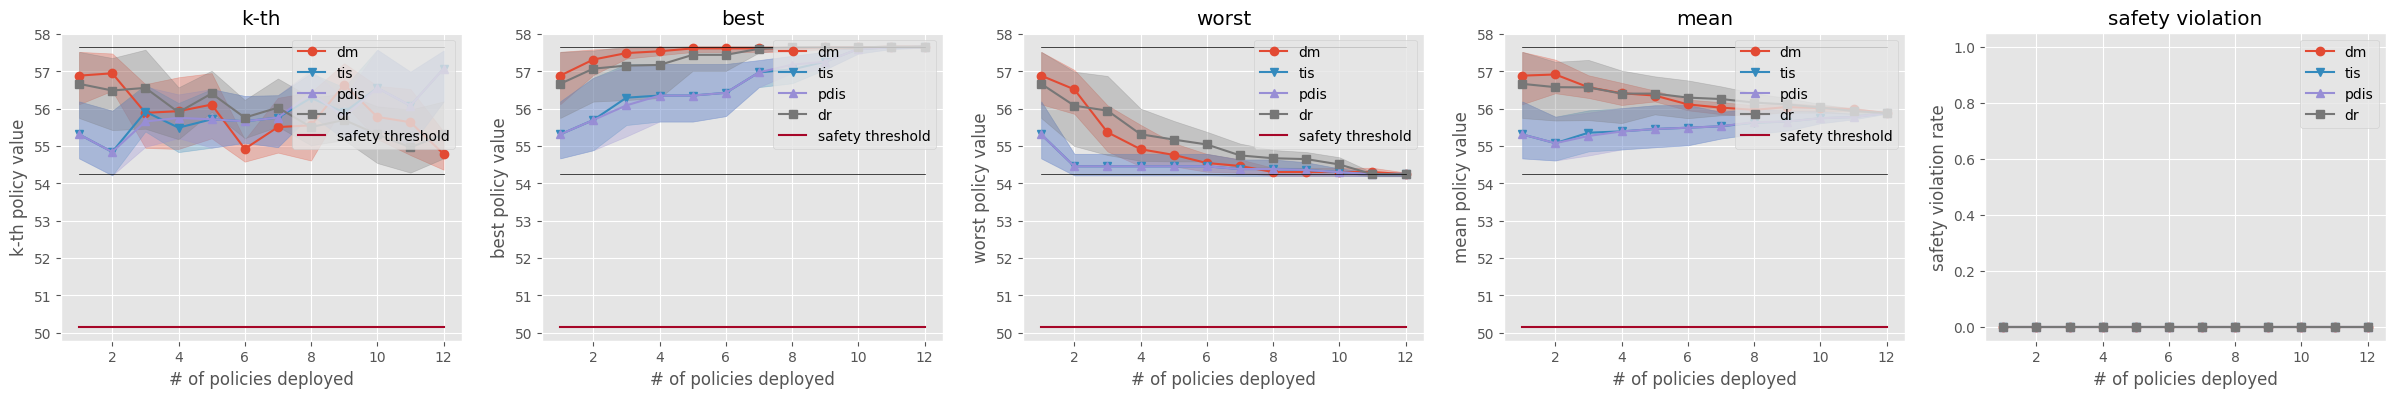

In [56]:
ops.visualize_topk_policy_value_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    visualize_ci=True,
    safety_criteria=1.0,
    legend=True,
    random_state=random_state,
)

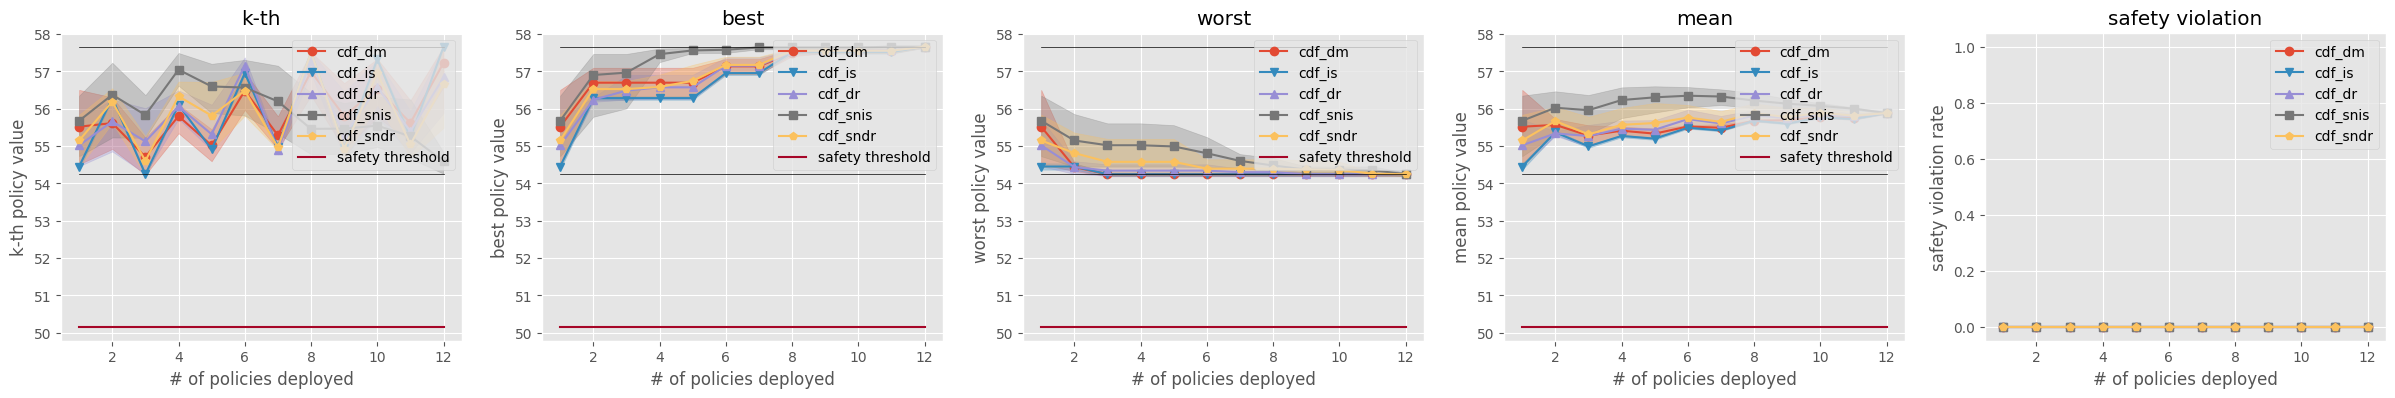

In [57]:
ops.visualize_topk_policy_value_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    visualize_ci=True,
    safety_criteria=1.0,
    legend=True,
    random_state=random_state,
)

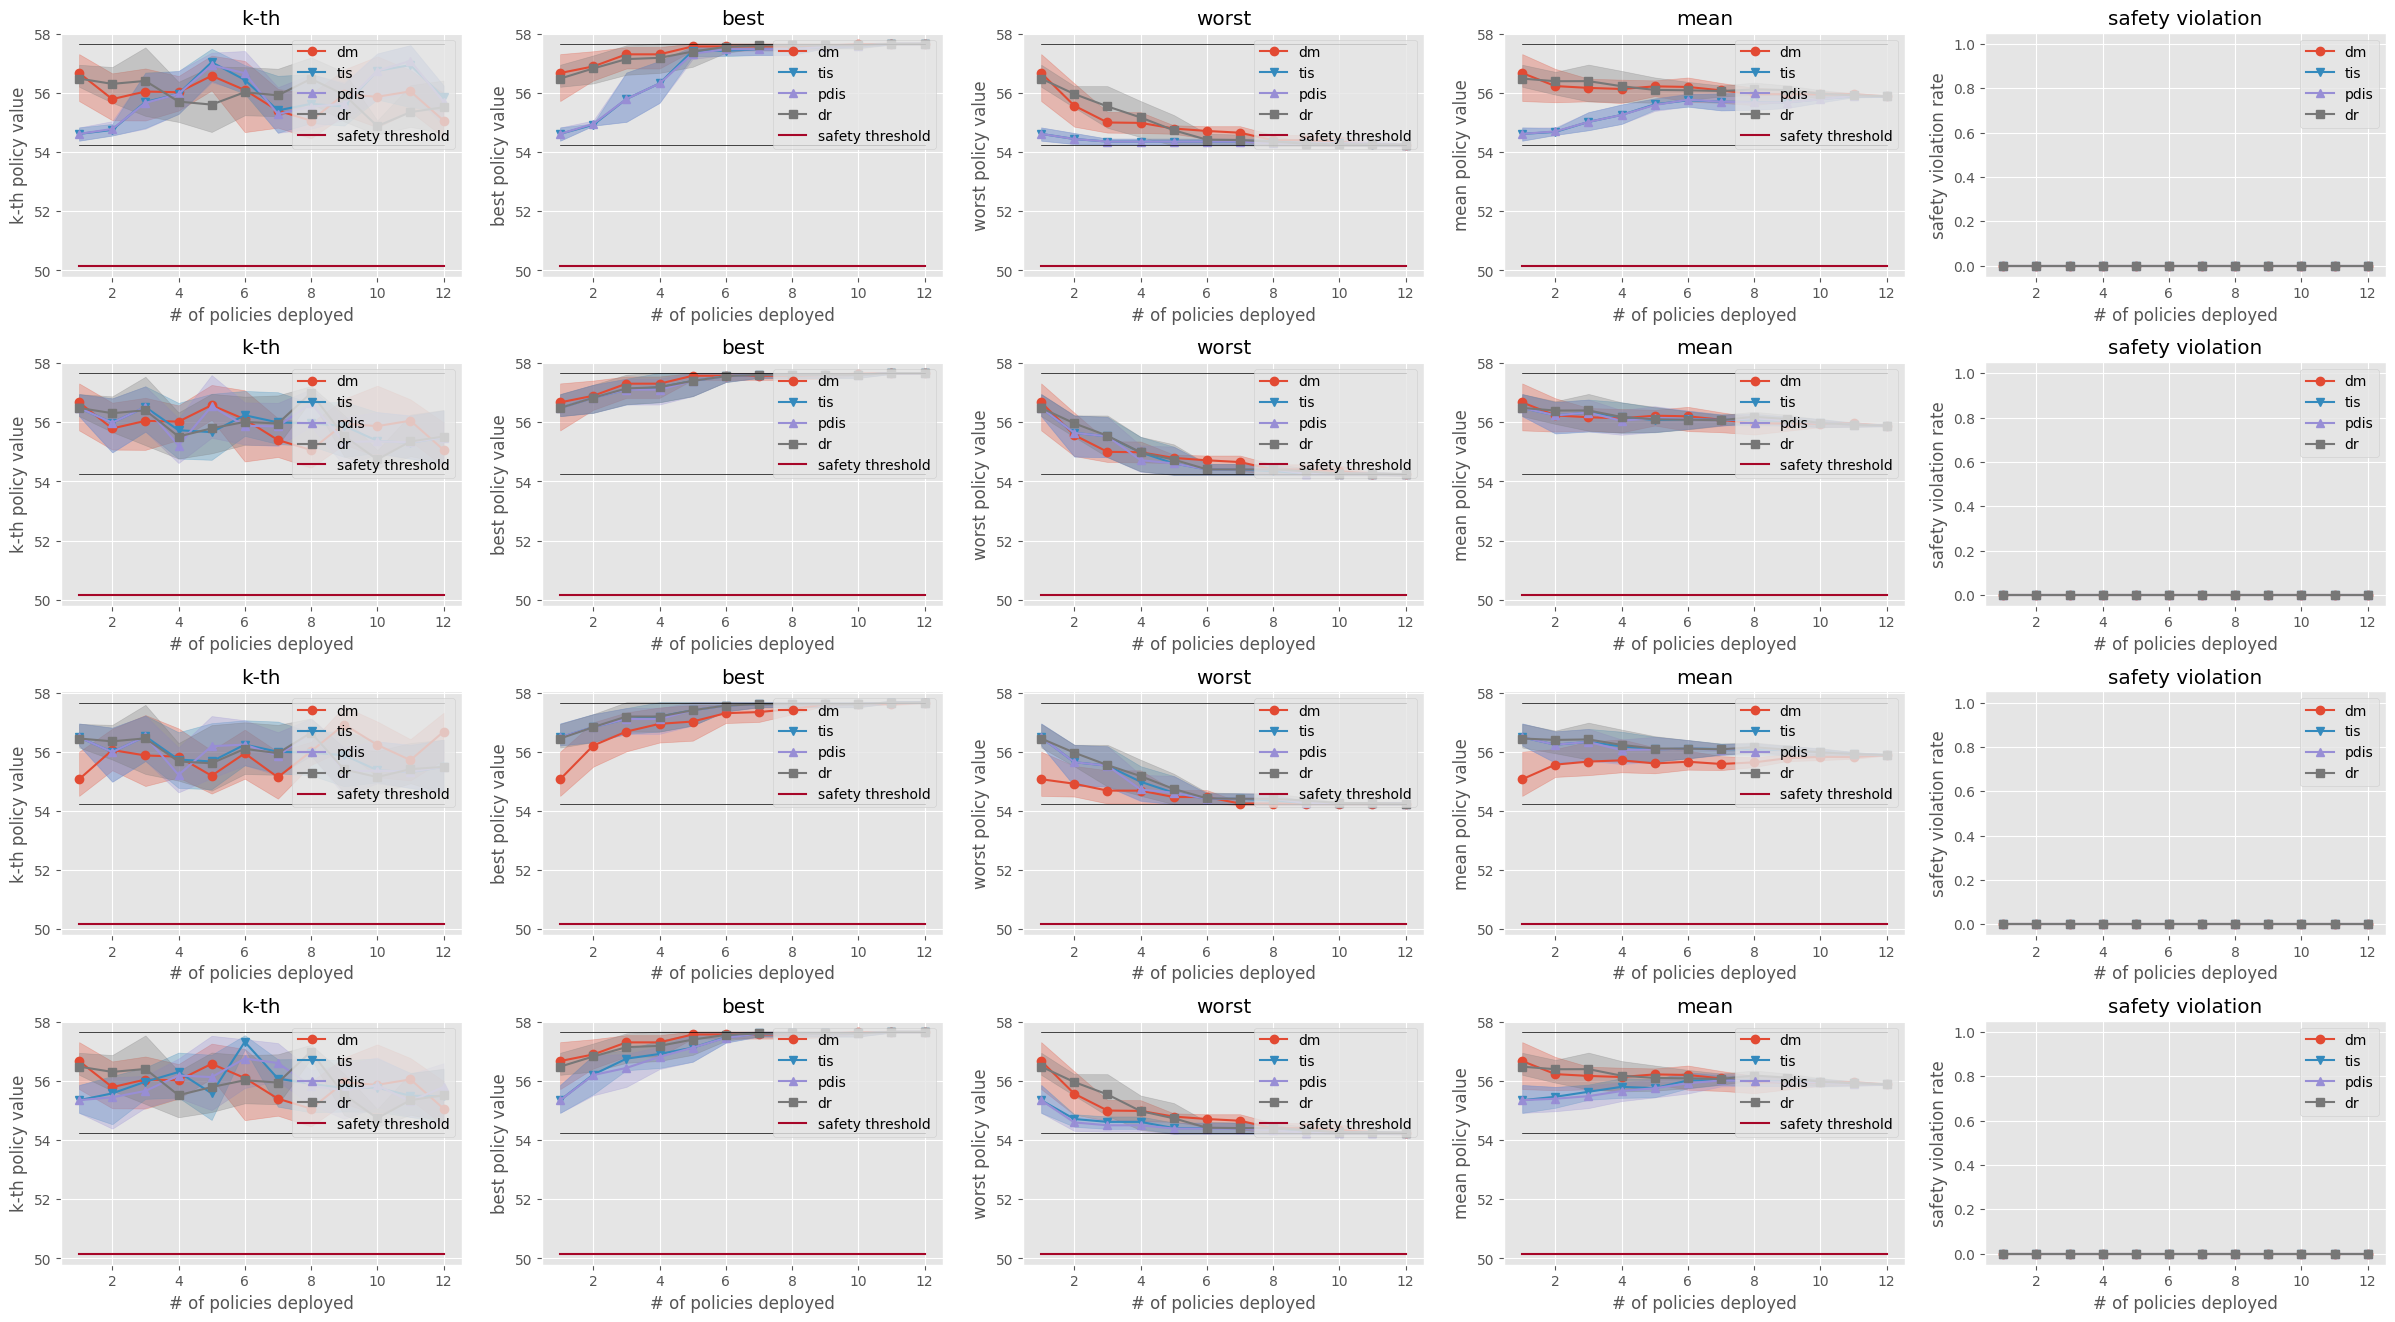

In [58]:
ops.visualize_topk_policy_value_selected_by_lower_bound(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    ope_cis=["bootstrap", "bernstein", "hoeffding", "ttest"],
    visualize_ci=True,
    safety_criteria=1.0,
    legend=True,
    random_state=random_state,
)

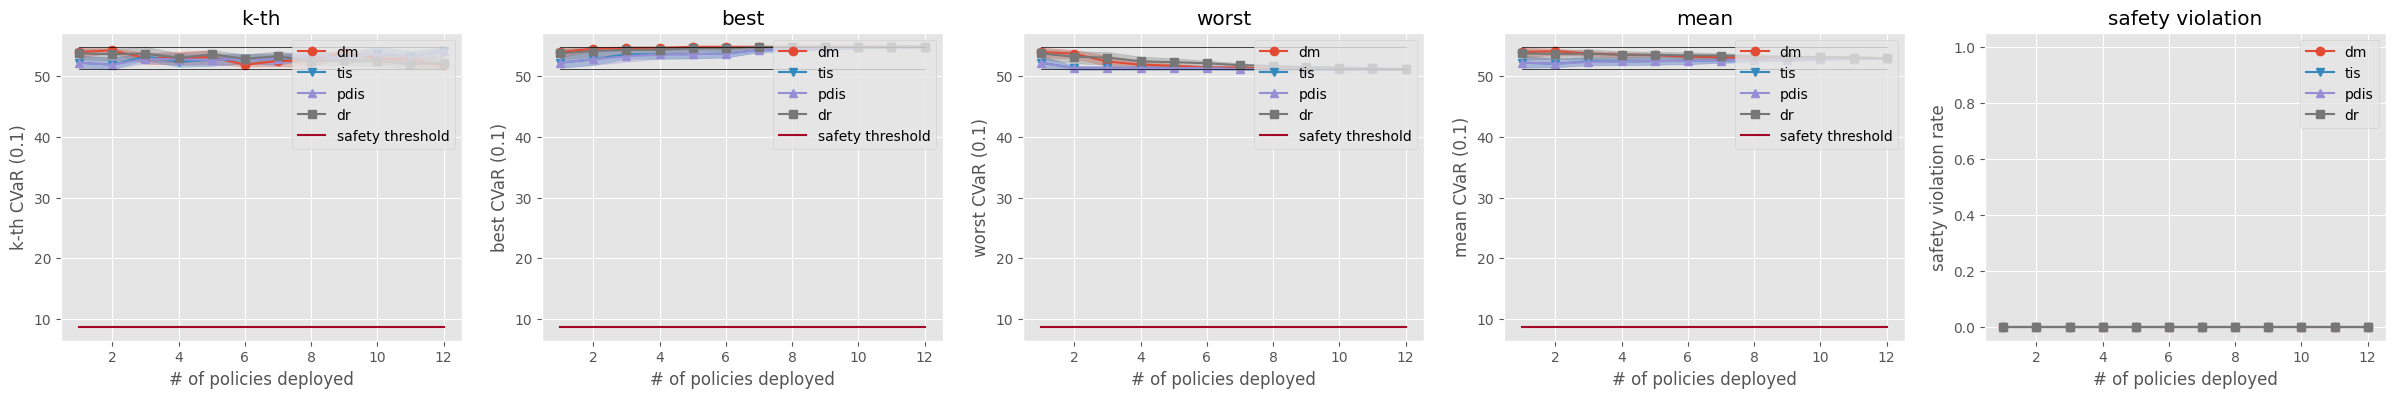

In [59]:
ops.visualize_topk_conditional_value_at_risk_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=8.75,
    legend=True,
    random_state=random_state,
)

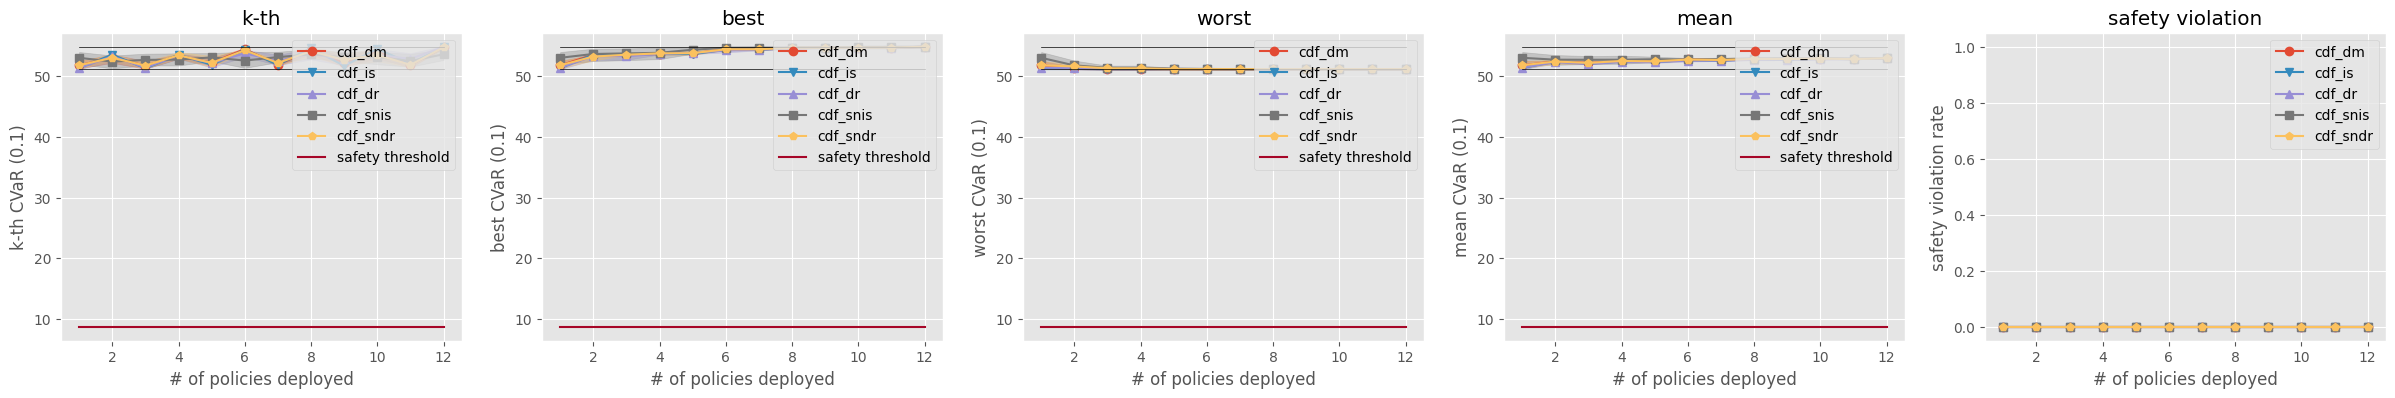

In [60]:
ops.visualize_topk_conditional_value_at_risk_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=8.75,
    legend=True,
    random_state=random_state,
)

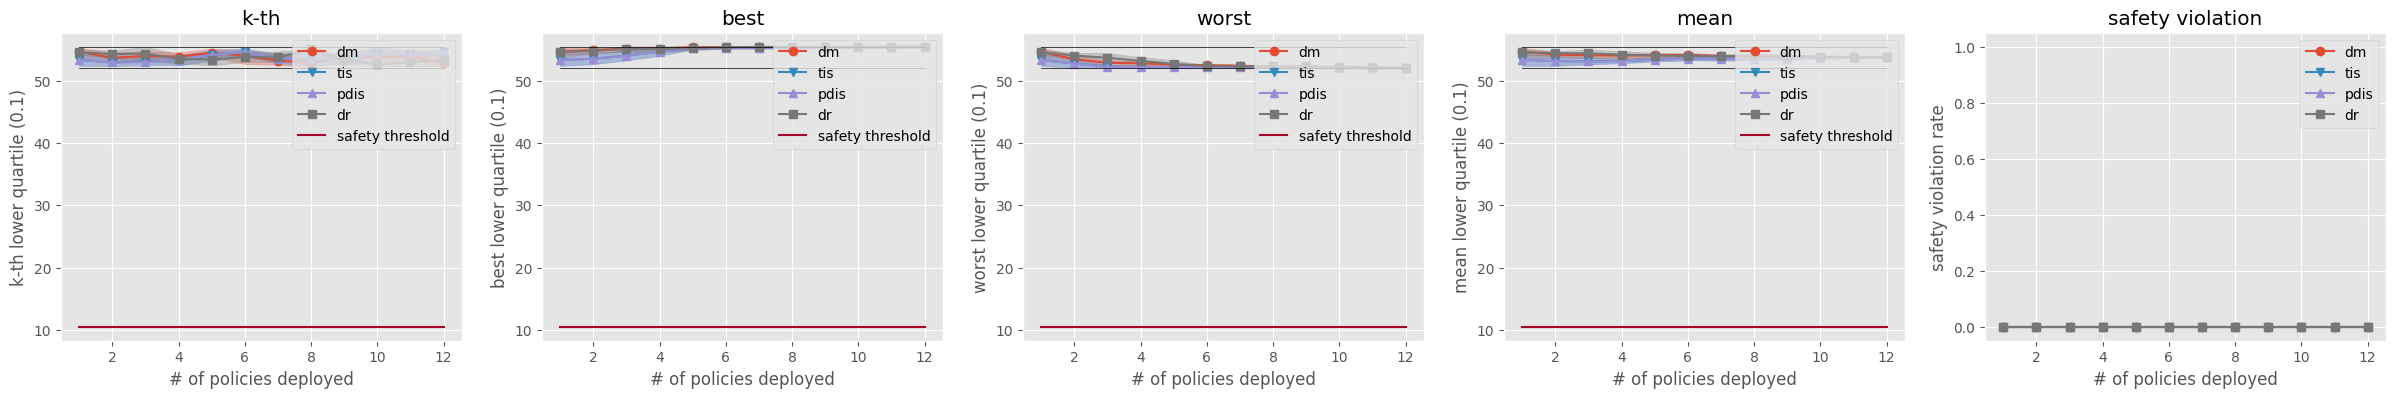

In [61]:
ops.visualize_topk_lower_quartile_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=10.5,
    legend=True,
    random_state=random_state,
)

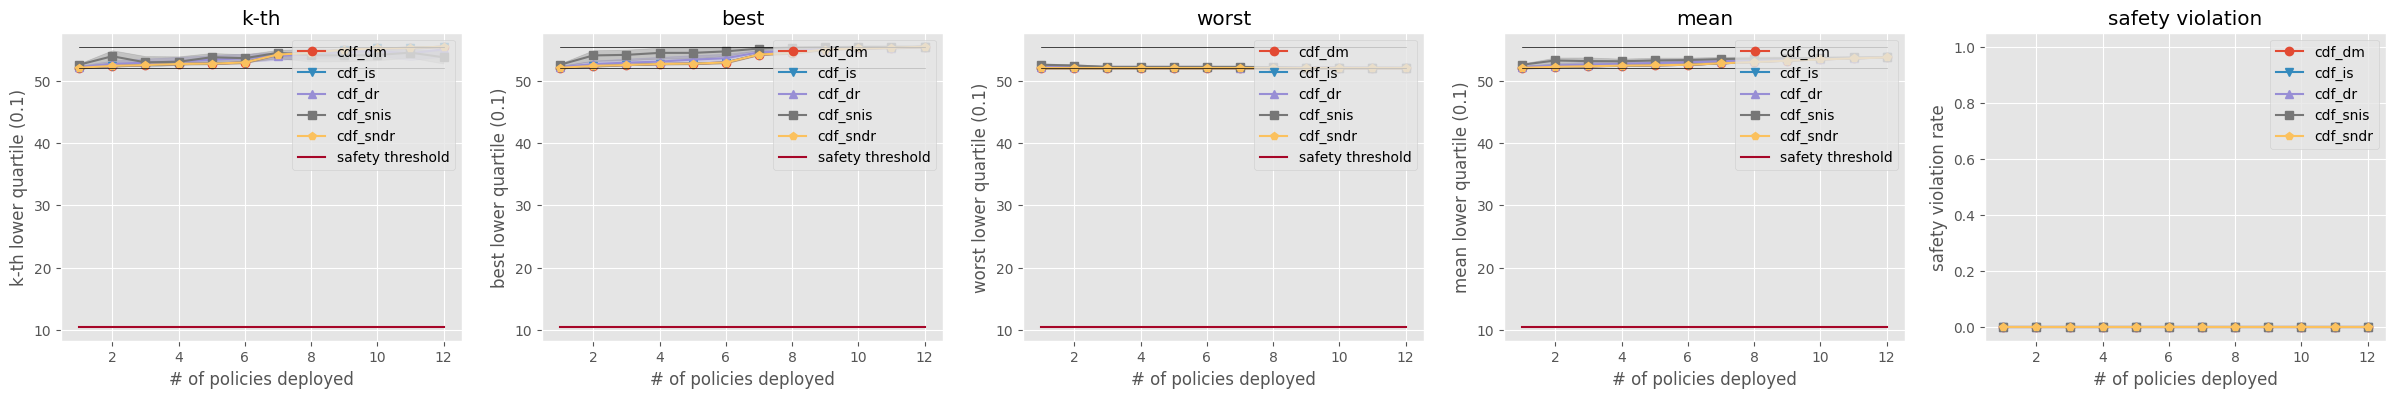

In [62]:
ops.visualize_topk_lower_quartile_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=10.5,
    legend=True,
    random_state=random_state,
)

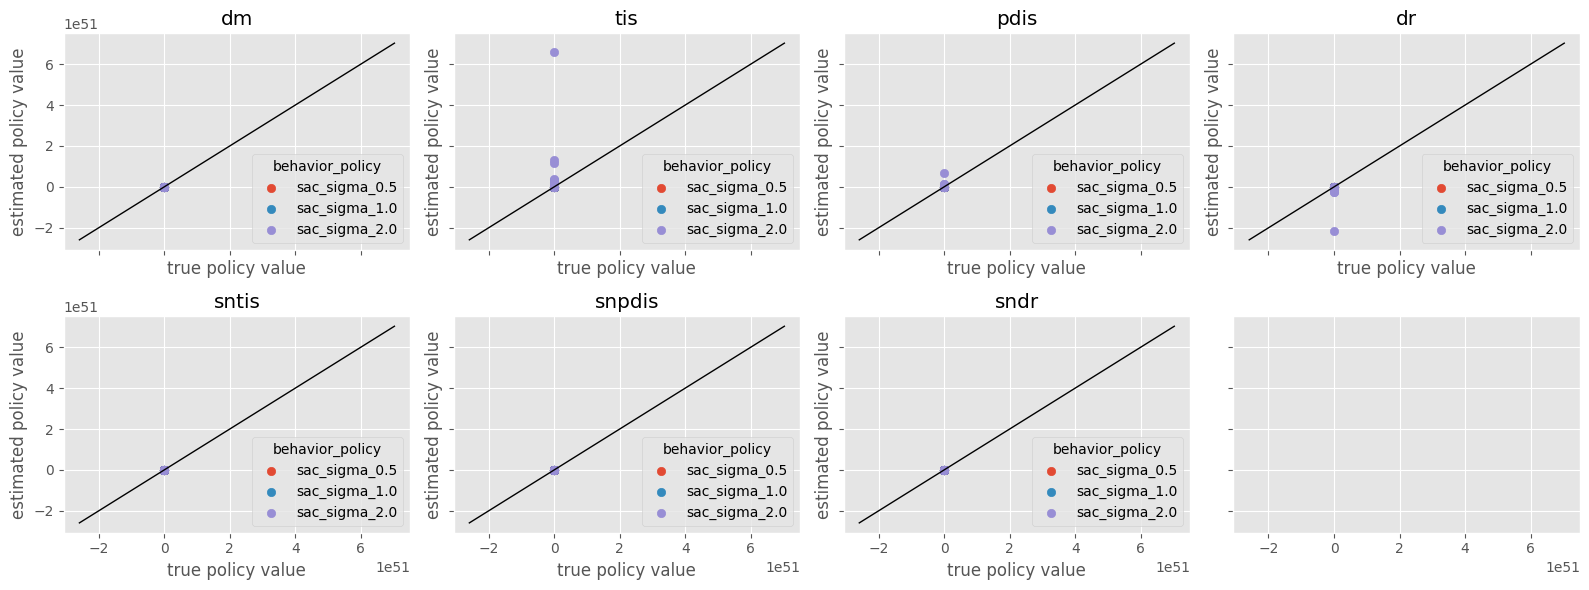

In [63]:
ops.visualize_policy_value_for_validation(
    input_dict=input_dict,
    n_cols=4,
    share_axes=True,
)

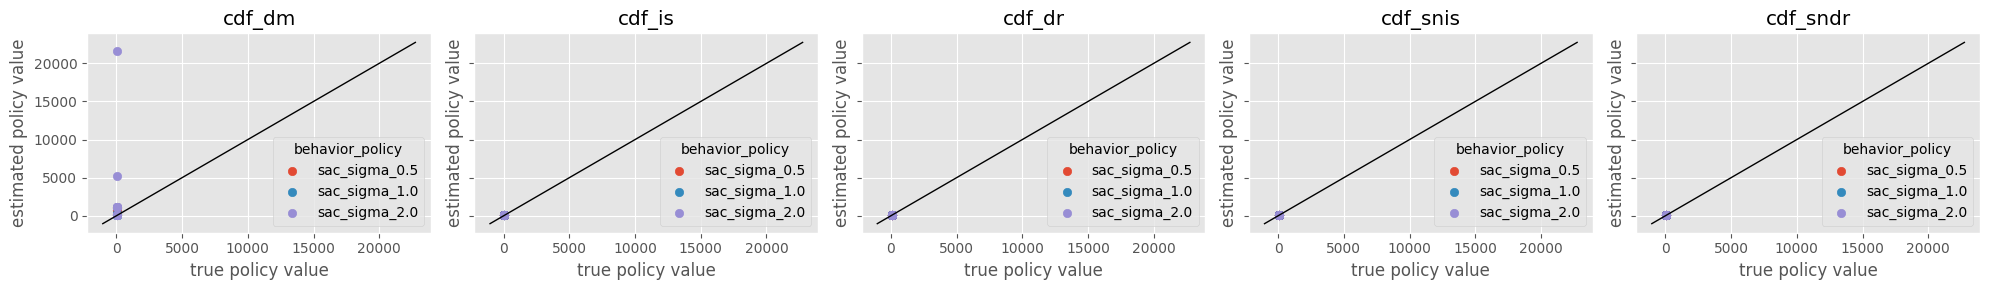

In [64]:
ops.visualize_policy_value_of_cumulative_distribution_ope_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

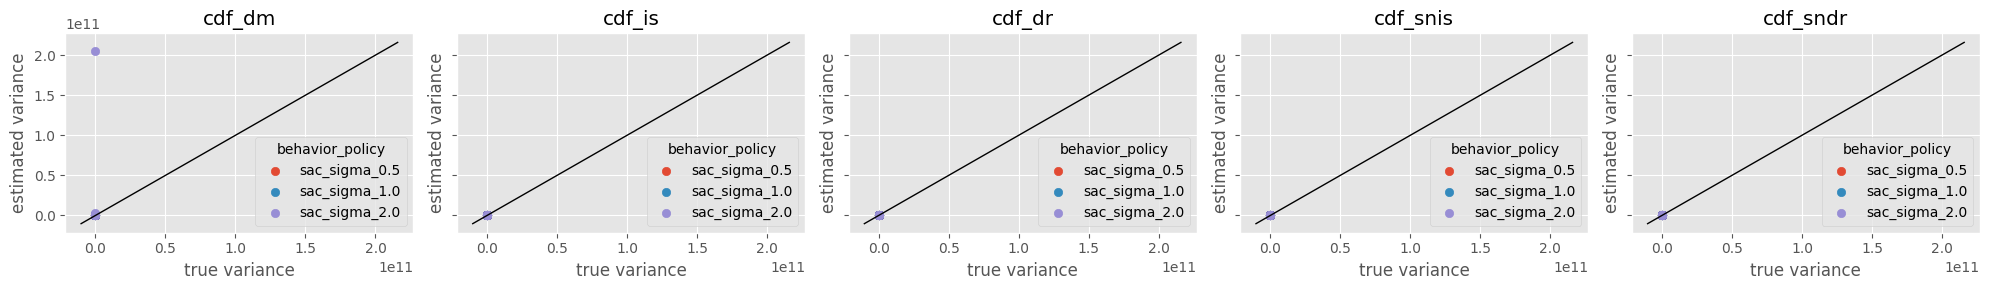

In [65]:
ops.visualize_variance_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

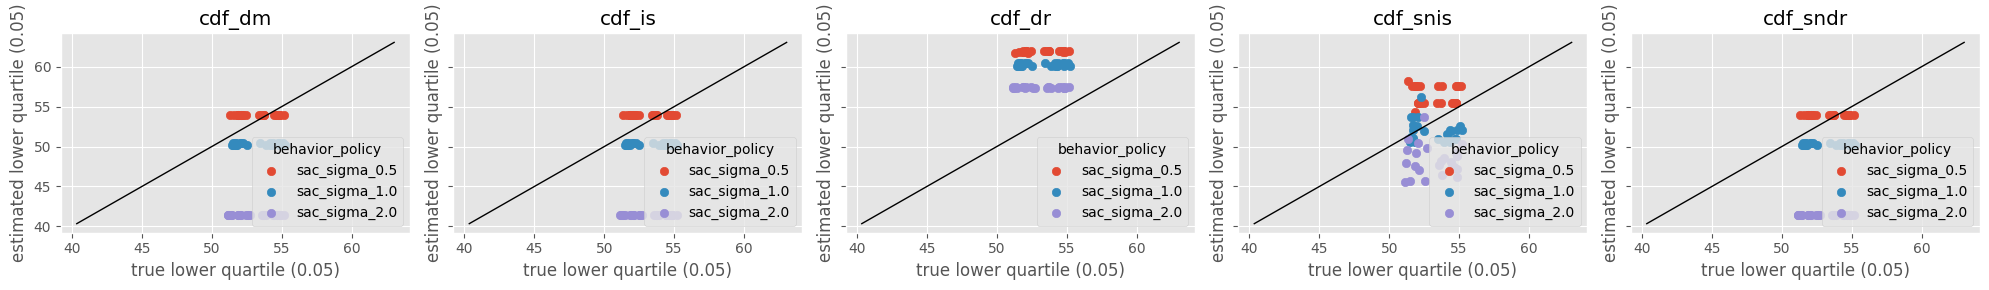

In [66]:
ops.visualize_lower_quartile_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

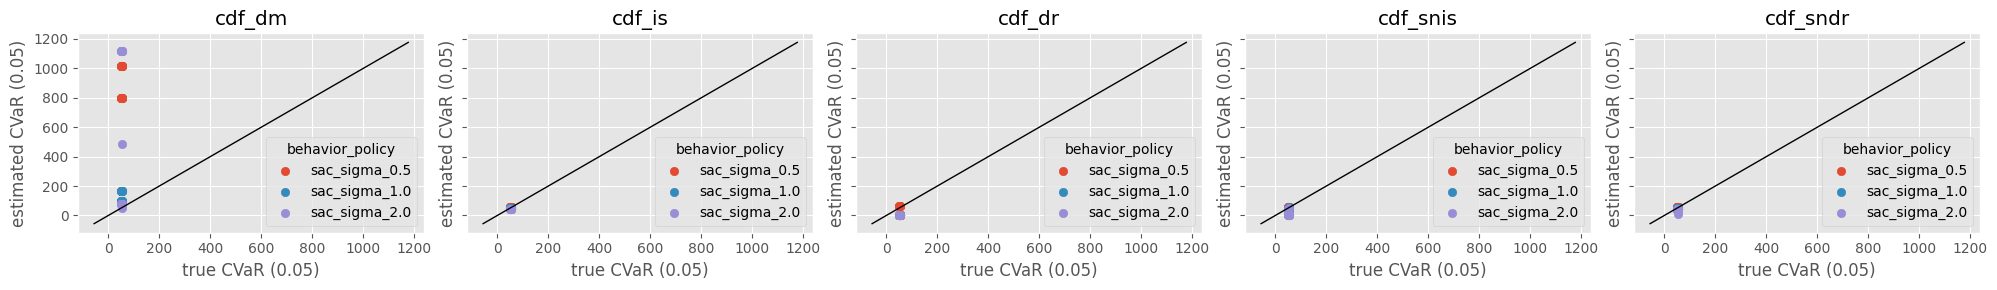

In [67]:
ops.visualize_conditional_value_at_risk_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

For the examples in the continuous action space, please refer to [examples/quickstart/synthetic_synthetic_continuous_multiple_datasets.ipynb](https://github.com/negocia-inc/synthetic_reinforcement_learing/blob/ope/examples/quickstart/synthetic_synthetic_continuous_multiple_datasets.ipynb).

## Reference

- Vladislav Kurenkov and Sergey Kolesnikov. \
"Showing Your Offline Reinforcement Learning Work: Online Evaluation Budget Matters.", 2022.

- Audrey Huang, Liu Leqi, Zachary C. Lipton, and Kamyar Azizzadenesheli. \
"Off-Policy Risk Assessment for Markov Decision Processes.", 2022.

- Yuta Saito, Shunsuke Aihara, Megumi Matsutani, and Yusuke Narita. \
"Open Bandit Dataset and Pipeline: Towards Realistic and Reproducible Off-Policy Evaluation.", 2021.

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- Shengpu Tang and Jenna Wiens. \
"Model Selection for Offline Reinforcement Learning: Practical Considerations for Healthcare Settings.", 2021.

- Justin Fu, Mohammad Norouzi, Ofir Nachum, George Tucker, Ziyu Wang, Alexander Novikov, Mengjiao Yang, Michael R. Zhang, Yutian Chen, Aviral Kumar, Cosmin Paduraru, Sergey Levine, and Tom Le Paine. \
"Benchmarks for Deep Off-Policy Evaluation.", 2021.

- Audrey Huang, Liu Leqi, Zachary C. Lipton, and Kamyar Azizzadenesheli. \
"Off-Policy Risk Assessment in Contextual Bandits.", 2021.

- Yash Chandak, Scott Niekum, Bruno Castro da Silva, Erik Learned-Miller, Emma Brunskill, and Philip S. Thomas. \
"Universal Off-Policy Evaluation.", 2021.

- Sergey Levine, Aviral Kumar, George Tucker, and Justin Fu. \
"Offline Reinforcement Learning: Tutorial, Review, and Perspectives on Open Problems." 2020.

- Tom Le Paine, Cosmin Paduraru, Andrea Michi, Caglar Gulcehre, Konrad Zolna, Alexander Novikov, Ziyu Wang, and Nando de Freitas. \
"Hyperparameter Selection for Offline Reinforcement Learning.", 2020.

- Aviral Kumar, Aurick Zhou, George Tucker, and Sergey Levine. \
"Conservative Q-Learning for Offline Reinforcement Learning.", 2020.

- Nathan Kallus and Masatoshi Uehara. \
"Intrinsically Efficient, Stable, and Bounded Off-Policy Evaluation for Reinforcement Learning.", 2019.

- Hoang Le, Cameron Voloshin, and Yisong Yue. \
"Batch Policy Learning under Constraints.", 2019.

- Di Wu, Xiujun Chen, Xun Yang, Hao Wang, Qing Tan, Xiaoxun Zhang, Jian Xu, and Kun Gai. \
"Budget Constrained Bidding by Model-free Reinforcement Learning in Display Advertising.", 2018.

- Jun Zhao, Guang Qiu, Ziyu Guan, Wei Zhao, and Xiaofei He. \
"Deep Reinforcement Learning for Sponsored Search Real-time Bidding.", 2018.

- Josiah P. Hanna, Peter Stone, and Scott Niekum. \
"Bootstrapping with Models: Confidence Intervals for Off-Policy Evaluation.", 2017.

- Nan Jiang and Lihong Li. \
"Doubly Robust Off-policy Value Evaluation for Reinforcement Learning.", 2016.

- Philip S. Thomas and Emma Brunskill. \
"Data-Efficient Off-Policy Policy Evaluation for Reinforcement Learning.", 2016.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Policy Improvement.", 2015.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Off-Policy Evaluation.", 2015.

- Adith Swaminathan and Thorsten Joachims. \
"The Self-Normalized Estimator for Counterfactual Learning.", 2015.

- Hado van Hasselt, Arthur Guez, and David Silver. \
"Deep Reinforcement Learning with Double Q-learning.", 2015.

- Miroslav Dudík, Dumitru Erhan, John Langford, and Lihong Li. \
"Doubly Robust Policy Evaluation and Optimization.", 2014.

- Alex Strehl, John Langford, Sham Kakade, and Lihong Li. \
"Learning from Logged Implicit Exploration Data.", 2010.

- Alina Beygelzimer and John Langford. \
"The Offset Tree for Learning with Partial Labels.", 2009.

- Doina Precup, Richard S. Sutton, and Satinder P. Singh. \
"Eligibility Traces for Off-Policy Policy Evaluation.", 2000.